In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 45
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [6]:
experiment_name = "semi_sup_gaussian_mah_k10"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=10,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [9]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prio

Epoch: 0/47, Nll_loss : 205.4307861328125 KLD:1.3618052005767822  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 205.4202423095703 KLD:1.3084423542022705  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 210.61817932128906 KLD:1.2518086433410645  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 208.67538452148438 KLD:1.258589267730713  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 209.03726196289062 KLD:1.1738855838775635  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 201.60675048828125 KLD:1.2198481559753418  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 204.88563537597656 KLD:1.1786320209503174  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 212.36859130859375 KLD:1.2865041494369507  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 213.76821899414062 KLD:1.1317059993743896  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 213.0615692138672 KLD:1.0556336641311646  Supervised loss:0.0
Epoch: 0/57, Nll_loss : 221.7668914794922 KLD:0.9978770017623901  Supervised loss:0.0
Epoch: 0/58, Nll_loss : 207.9312286376953 KLD:1.

Epoch: 0/142, Nll_loss : 190.4742889404297 KLD:2.4976484775543213  Supervised loss:0.0
Epoch: 0/143, Nll_loss : 187.94387817382812 KLD:2.663790225982666  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 180.86074829101562 KLD:2.6700313091278076  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 177.2204132080078 KLD:2.498424768447876  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 181.12481689453125 KLD:2.6275739669799805  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 185.10646057128906 KLD:2.7781004905700684  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 188.14808654785156 KLD:2.643077850341797  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 178.90460205078125 KLD:2.43715238571167  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 188.92620849609375 KLD:2.373711347579956  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 183.200927734375 KLD:2.2600088119506836  Supervised loss:0.0
Epoch: 0/152, Nll_loss : 182.73080444335938 KLD:2.2020018100738525  Supervised loss:0.0
Epoch: 0/153, Nll_loss : 181.4043273925781

Epoch: 0/238, Nll_loss : 160.38369750976562 KLD:3.6992106437683105  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 164.71694946289062 KLD:3.7221837043762207  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 159.75885009765625 KLD:3.6812596321105957  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 162.57823181152344 KLD:3.8932695388793945  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 163.35699462890625 KLD:3.8608226776123047  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 156.3817596435547 KLD:3.807264804840088  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 166.28634643554688 KLD:3.9557578563690186  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 168.5142059326172 KLD:3.9885871410369873  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 169.54627990722656 KLD:4.044175148010254  Supervised loss:0.0
Epoch: 0/247, Nll_loss : 164.2862091064453 KLD:4.174623012542725  Supervised loss:0.0
Epoch: 0/248, Nll_loss : 162.41189575195312 KLD:3.7944560050964355  Supervised loss:0.0
Epoch: 0/249, Nll_loss : 157.689636230

Epoch: 0/333, Nll_loss : 153.0699462890625 KLD:5.434868812561035  Supervised loss:0.0
Epoch: 0/334, Nll_loss : 152.7254638671875 KLD:5.218182563781738  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 146.60385131835938 KLD:4.911712646484375  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 151.40512084960938 KLD:4.994024276733398  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 154.94683837890625 KLD:4.615286827087402  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 156.31211853027344 KLD:4.3492937088012695  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 167.1040802001953 KLD:4.243068695068359  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 159.46551513671875 KLD:4.284050464630127  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 152.91018676757812 KLD:4.652496337890625  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 154.53025817871094 KLD:4.457942008972168  Supervised loss:0.0
Epoch: 0/343, Nll_loss : 148.34909057617188 KLD:4.955976486206055  Supervised loss:0.0
Epoch: 0/344, Nll_loss : 159.3230438232422 KL

Epoch: 0/428, Nll_loss : 141.37161254882812 KLD:5.591512680053711  Supervised loss:0.0
Epoch: 0/429, Nll_loss : 155.24246215820312 KLD:5.3502278327941895  Supervised loss:0.0
Epoch: 0/430, Nll_loss : 148.58016967773438 KLD:5.287106513977051  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 140.8031005859375 KLD:4.810756683349609  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 146.8289337158203 KLD:4.860279083251953  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 155.56028747558594 KLD:5.086349010467529  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 148.3417510986328 KLD:4.859095096588135  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 145.10037231445312 KLD:5.032951354980469  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 147.9022216796875 KLD:5.5717973709106445  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 155.9390869140625 KLD:5.288386344909668  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 145.69485473632812 KLD:5.434192657470703  Supervised loss:0.0
Epoch: 0/439, Nll_loss : 140.64569091796875 KL

Epoch: 0/523, Nll_loss : 162.3009796142578 KLD:5.106510162353516  Supervised loss:0.0
Epoch: 0/524, Nll_loss : 140.72698974609375 KLD:5.065234184265137  Supervised loss:0.0
Epoch: 0/525, Nll_loss : 141.5449676513672 KLD:5.709567070007324  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 139.40267944335938 KLD:5.514684200286865  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 136.83615112304688 KLD:5.7513580322265625  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 128.47525024414062 KLD:5.661181449890137  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 139.73089599609375 KLD:5.689630031585693  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 143.09942626953125 KLD:5.5832366943359375  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 137.56202697753906 KLD:5.487957000732422  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 148.7470703125 KLD:5.552735328674316  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 141.43798828125 KLD:5.573543071746826  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 150.06011962890625 KLD:5.

Epoch: 0/618, Nll_loss : 138.53553771972656 KLD:5.29516077041626  Supervised loss:0.0
Epoch: 0/619, Nll_loss : 144.23812866210938 KLD:5.519206523895264  Supervised loss:0.0
Epoch: 0/620, Nll_loss : 144.86282348632812 KLD:5.466326713562012  Supervised loss:0.0
Epoch: 0/621, Nll_loss : 147.38621520996094 KLD:5.603303909301758  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 135.455810546875 KLD:5.598086357116699  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 131.72894287109375 KLD:5.825695037841797  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 147.00282287597656 KLD:5.7269511222839355  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 150.15554809570312 KLD:5.593654155731201  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 144.8646240234375 KLD:5.356339454650879  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 134.77078247070312 KLD:5.210456848144531  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 139.83876037597656 KLD:5.222973823547363  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 142.598388671875 KLD:

Epoch: 0/714, Nll_loss : 135.4405517578125 KLD:6.233180999755859  Supervised loss:0.0
Epoch: 0/715, Nll_loss : 135.3072509765625 KLD:5.83889102935791  Supervised loss:0.0
Epoch: 0/716, Nll_loss : 134.61776733398438 KLD:5.854719161987305  Supervised loss:0.0
Epoch: 0/717, Nll_loss : 143.50747680664062 KLD:6.114748954772949  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 131.98983764648438 KLD:5.476176738739014  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 147.251953125 KLD:5.204532623291016  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 141.87283325195312 KLD:5.419003486633301  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 141.96060180664062 KLD:5.5784406661987305  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 134.86148071289062 KLD:5.6373090744018555  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 139.82159423828125 KLD:5.893874168395996  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 144.43655395507812 KLD:5.985341548919678  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 138.4552001953125 KLD:5.

Epoch: 0/809, Nll_loss : 139.8638916015625 KLD:5.592782974243164  Supervised loss:0.0
Epoch: 0/810, Nll_loss : 143.7288818359375 KLD:5.579649925231934  Supervised loss:0.0
Epoch: 0/811, Nll_loss : 140.74903869628906 KLD:5.335188865661621  Supervised loss:0.0
Epoch: 0/812, Nll_loss : 140.37283325195312 KLD:5.52208137512207  Supervised loss:0.0
Epoch: 0/813, Nll_loss : 140.40591430664062 KLD:5.390530586242676  Supervised loss:0.0
Epoch: 0/814, Nll_loss : 133.29034423828125 KLD:5.622446060180664  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 144.63002014160156 KLD:5.931332588195801  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 140.2012939453125 KLD:6.009008884429932  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 137.86526489257812 KLD:6.158496856689453  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 122.3389892578125 KLD:6.381263732910156  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 144.22598266601562 KLD:6.824465751647949  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 138.54977416992188 KLD:

Epoch: 0/904, Nll_loss : 138.36636352539062 KLD:5.932762622833252  Supervised loss:0.0
Epoch: 0/905, Nll_loss : 137.60830688476562 KLD:5.925219535827637  Supervised loss:0.0
Epoch: 0/906, Nll_loss : 131.05154418945312 KLD:6.216721534729004  Supervised loss:0.0
Epoch: 0/907, Nll_loss : 143.94338989257812 KLD:6.358794689178467  Supervised loss:0.0
Epoch: 0/908, Nll_loss : 136.42544555664062 KLD:6.206221580505371  Supervised loss:0.0
Epoch: 0/909, Nll_loss : 130.11985778808594 KLD:5.803619384765625  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 141.0544891357422 KLD:5.948662281036377  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 132.50497436523438 KLD:5.583712577819824  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 141.73367309570312 KLD:5.436575889587402  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 137.1671905517578 KLD:5.5267839431762695  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 134.533203125 KLD:5.951581001281738  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 145.0040283203125 KLD:5.

# Load the trained model

In [10]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [11]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.9415407 z_max=4.492721599999999
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

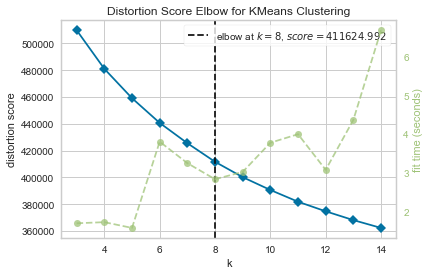

In [13]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [14]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [15]:
num_clusters

10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


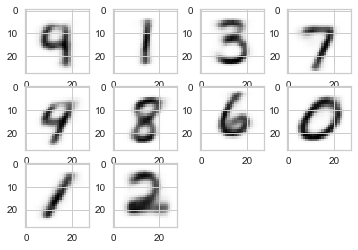

In [16]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [17]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [-1,1,3,7,
                                               -1,8,6,0,
                                               1,2
                                              ]
    manual_annotation_json["manual_confidence"] = [0, 1, 0.7, 0.7,
                                                  0, 0.8, 0.9, 1,
                                                  0.9, 0.9]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [18]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [19]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [20]:
cluster_group_dict

{'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7f921aa93f10>,
 None: <clearn.analysis.ClusterGroup at 0x7f921aa93e10>,
 'good_clusters': <clearn.analysis.ClusterGroup at 0x7f921aa93c50>}

In [21]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


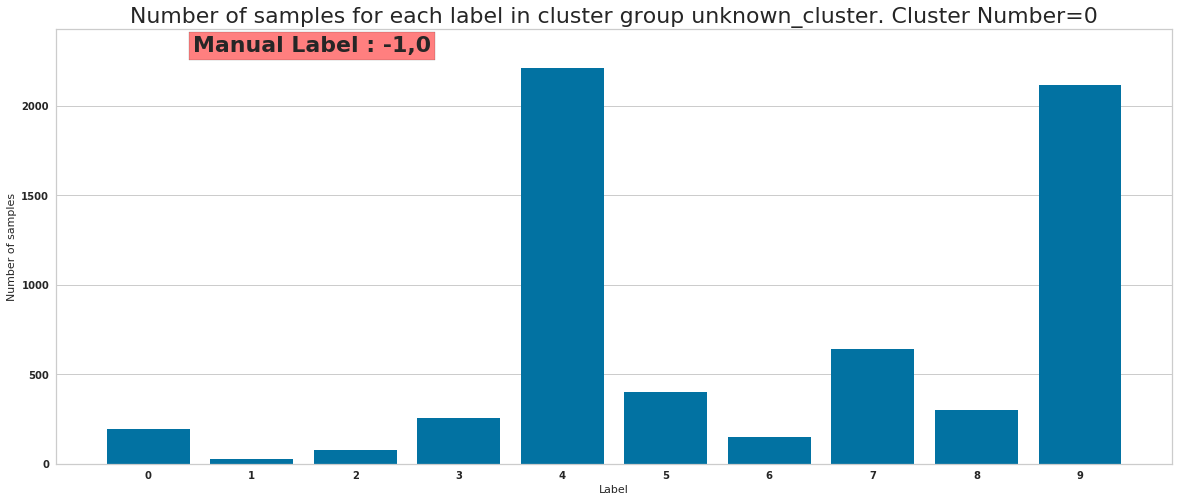

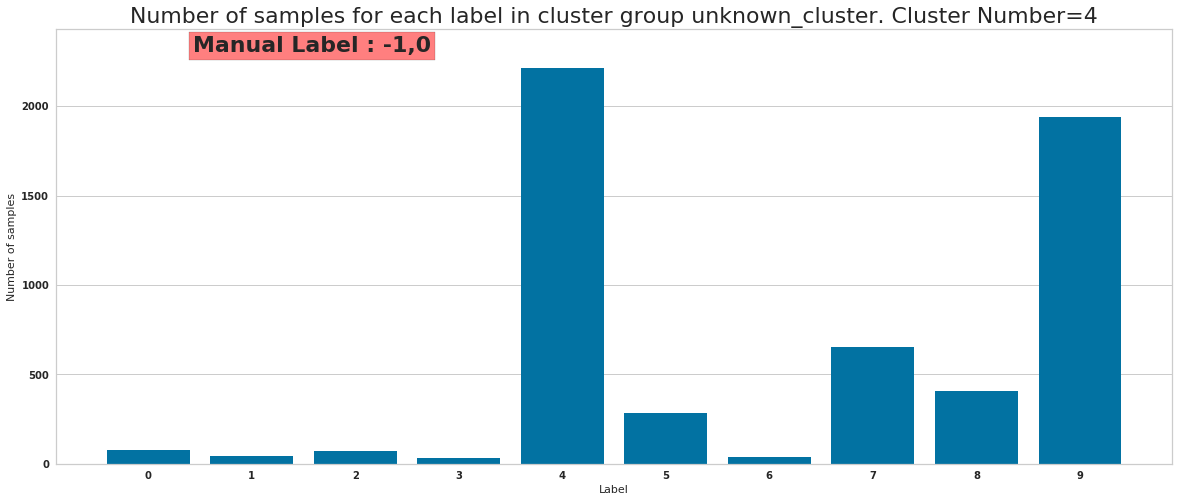

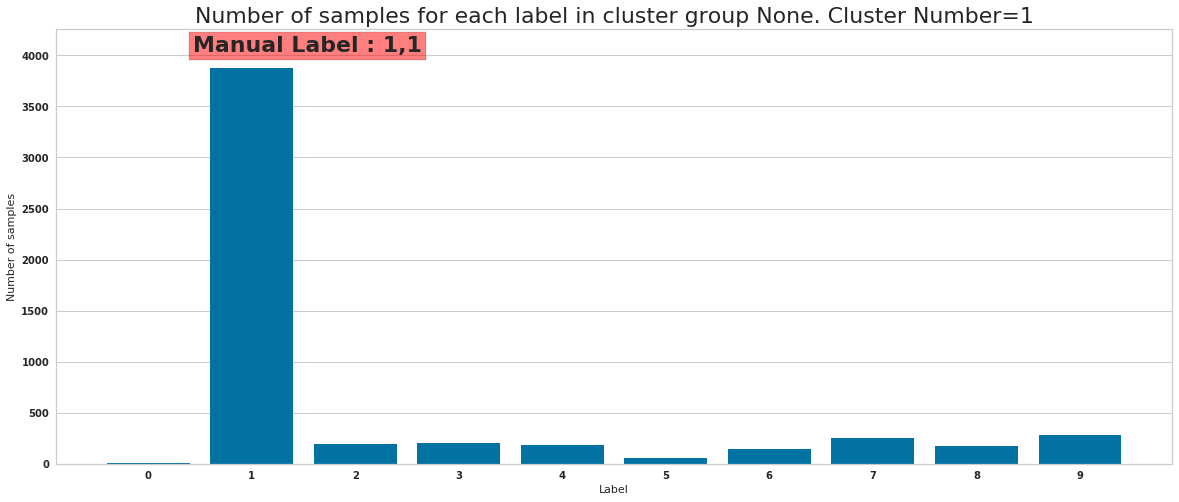

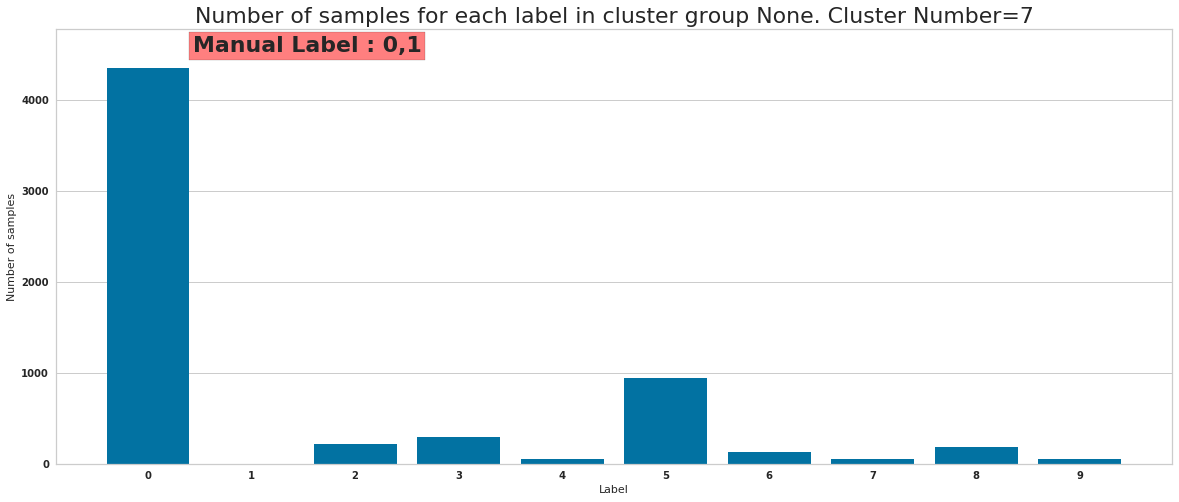

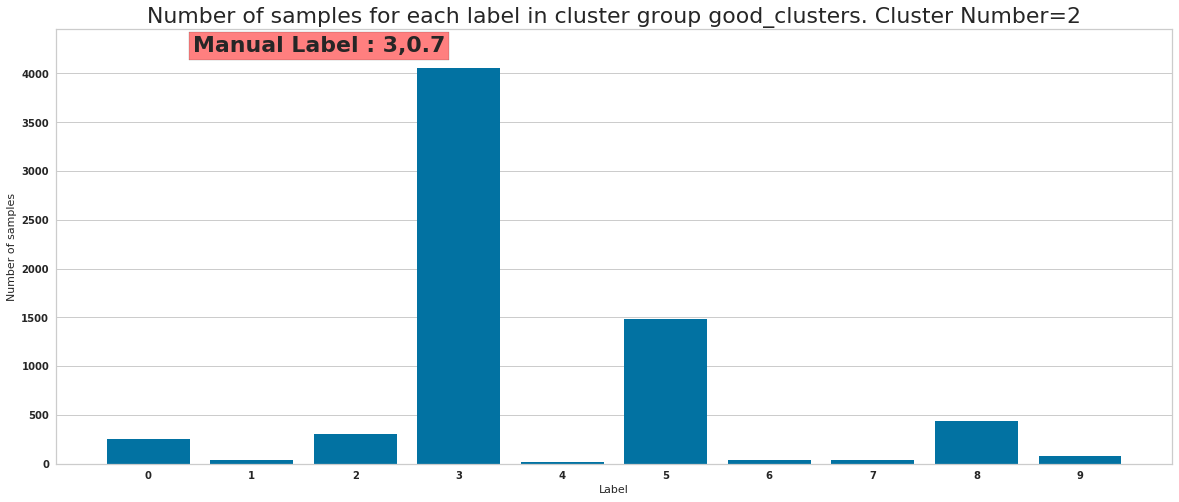

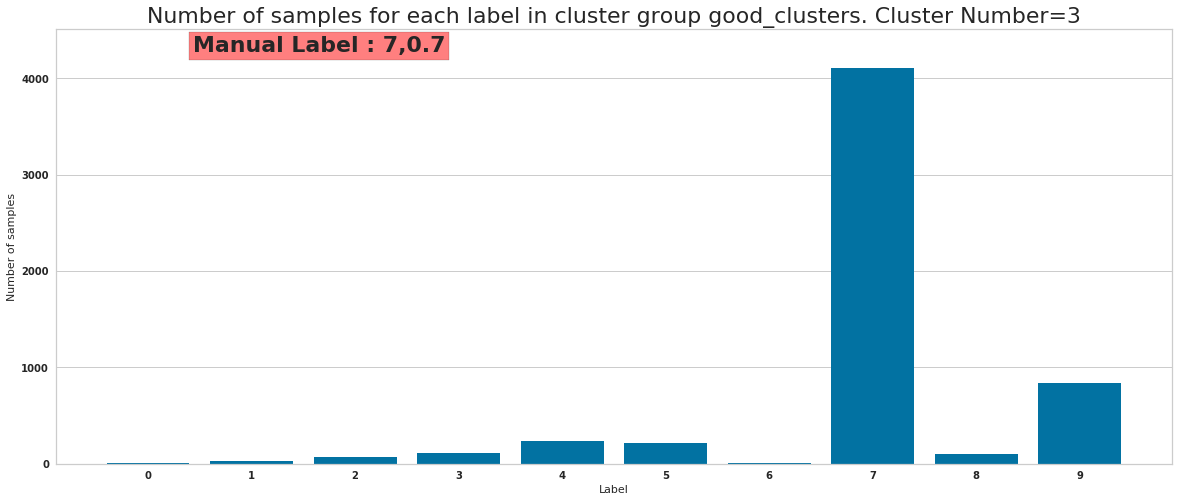

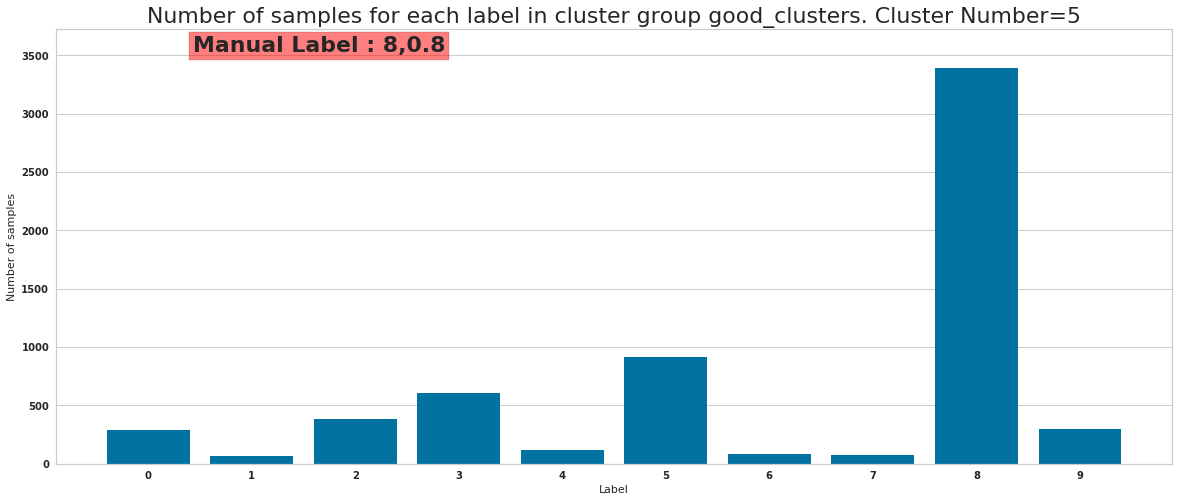

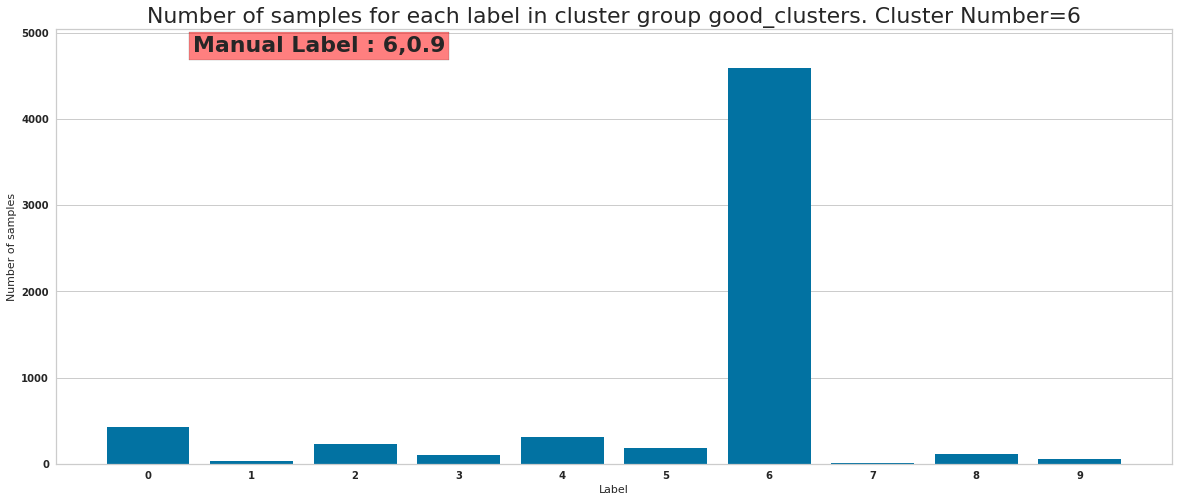

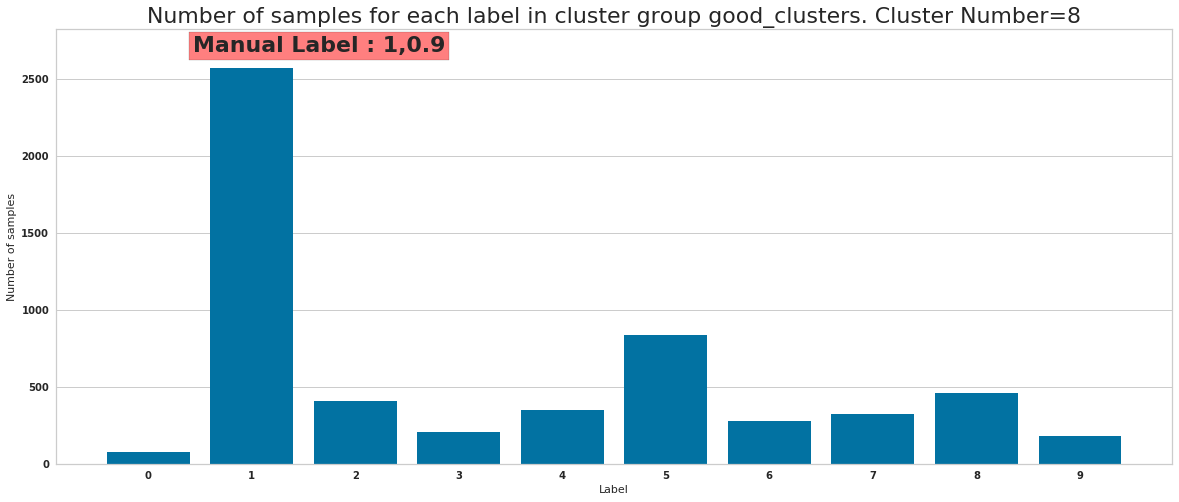

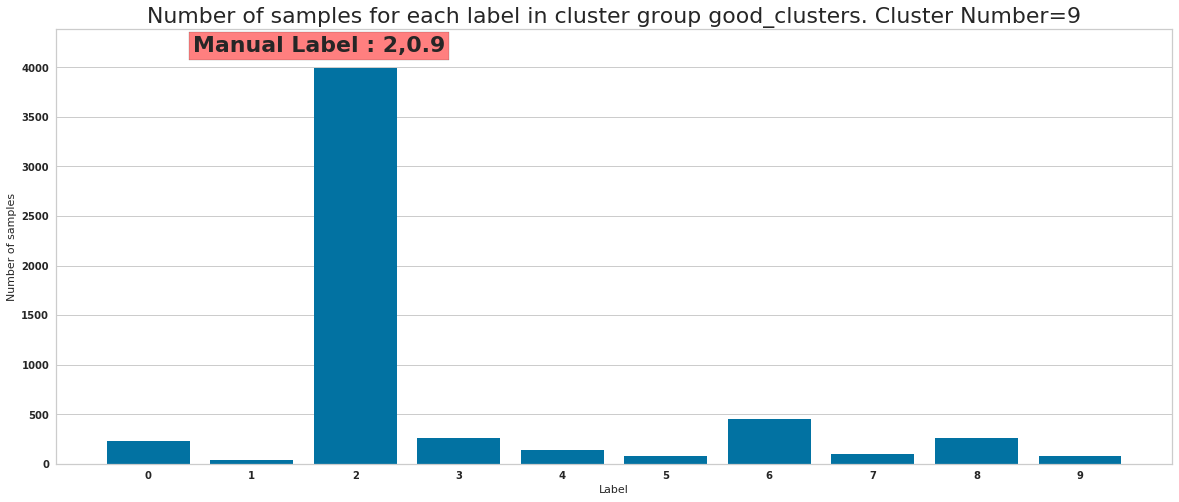

In [22]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [23]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(6365, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5380, 10)
(6765, 10)
(5723, 10)
(5749, 10)
(6231, 10)
(6039, 10)
(6288, 10)
(5686, 10)
(5614, 10)


0
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


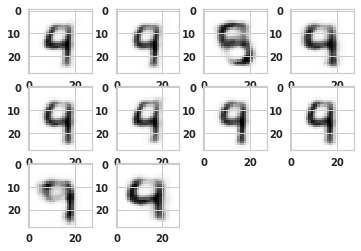

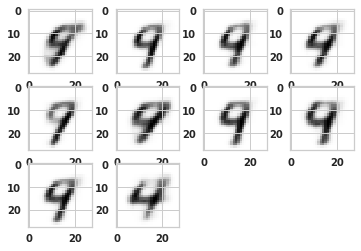

In [24]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [26]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [4, 9, -1, -1,
                                         -1, -1, -1, -1,
                                         -1,-1]
level_2_cluster_dict["manual_confidences"] = [0.6,0.7,0,0,
                                              0, 0, 0, 0,
                                              0, 0]
level2_manual_annotations[0] = level_2_cluster_dict


level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, 9, -1,-1,
                                        -1,-1,-1,-1,
                                        -1,4]
level_2_cluster_dict["manual_confidences"] = [0, 0.7, 0, 0,
                                              0 , 0 , 0, 0,
                                              0, 0.6
                                             ]

level2_manual_annotations[4] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,9,4,7,
#                                         9,4,9,4,
#                                         4, 9]
# level_2_cluster_dict["manual_confidences"] = [0,0.9,0.6,0.6,
#                                               0.9,0.8,0.8,0.8,
#                                               0.7,0.8
#                                              ]
# level2_manual_annotations[9] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [27]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

0
4


In [28]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
0 (569,)
1 (650,)
Skipping distance computation for unknown cluster
10
Skipping distance computation for unknown cluster
1 (544,)
9 (586,)


In [29]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [31]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [32]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [33]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [34]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

unknown
<class 'dict'>
['average_clusters', 'good_clusters', 'unknown_cluster']
********4*******
Manual_label 4
********9*******
Manual_label 9
********-1*******
Annotating individual samples (569,)
********-1*******
Annotating individual samples (606,)
********-1*******
Annotating individual samples (657,)
********-1*******
Annotating individual samples (646,)
********-1*******
Annotating individual samples (678,)
********-1*******
Annotating individual samples (754,)
********-1*******
Annotating individual samples (564,)
********-1*******
Annotating individual samples (672,)
********************************
Manual Label 1
(5394, 67) (5380, 33)
Num correct=3886
Cluster 1 Manual Label 1 Percentage correct 72.04301075268818
********************************
Manual Label 3
(6990, 67) (6765, 33)
Num correct=4276
Cluster 2 Manual Label 3 Percentage correct 61.17310443490701
********************************
Manual Label 7
(6277, 67) (5723, 33)
Num correct=4656
Cluster 3 Manual Label 7 Percen

# Save the dataframe with manual annotations

In [35]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([6365., 5380., 6765., 5723., 5749., 6231., 6039., 6288., 5686.,
        5614.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

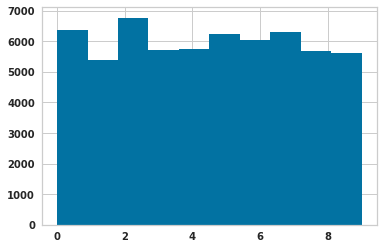

In [36]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [37]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


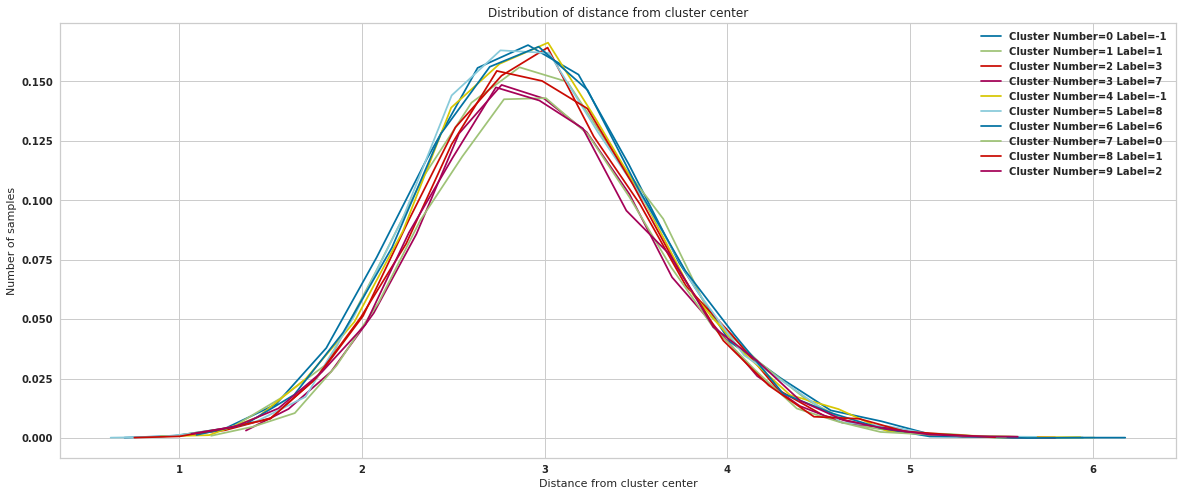

In [38]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

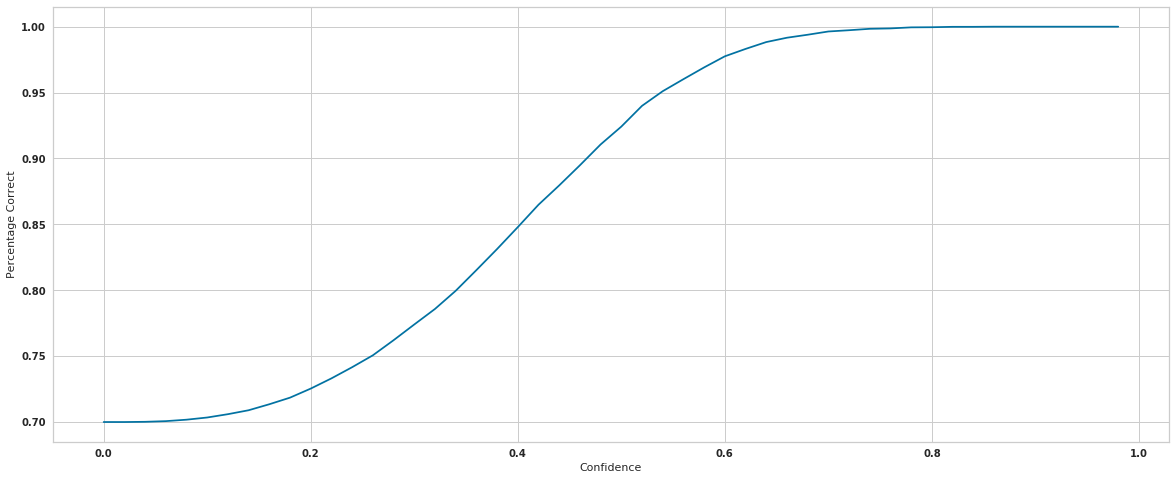

In [39]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

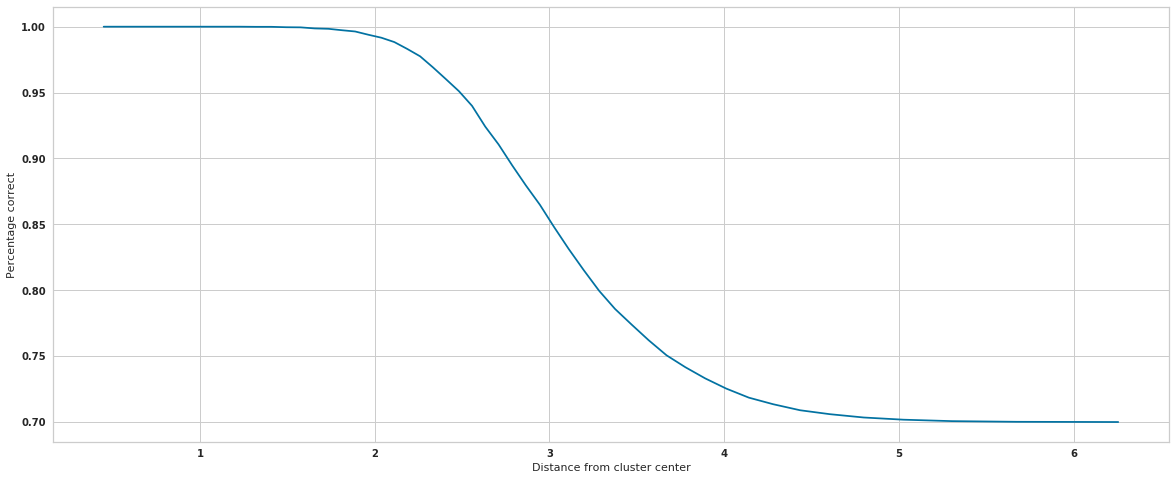

In [40]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [41]:
from shutil import copy2

In [42]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

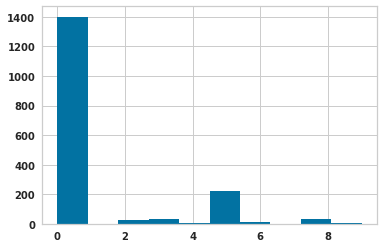

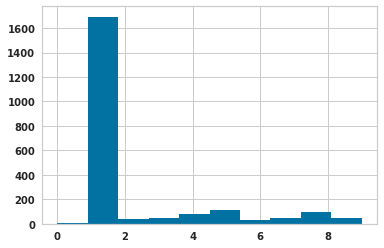

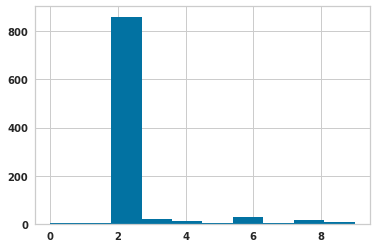

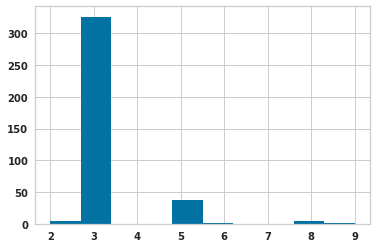

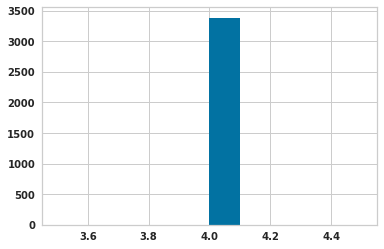

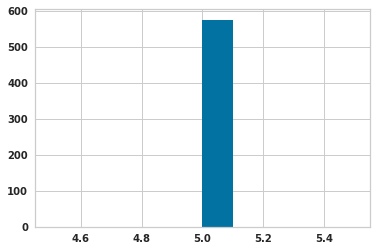

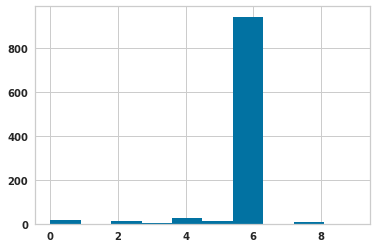

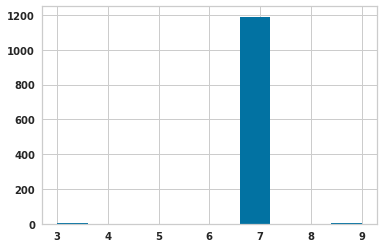

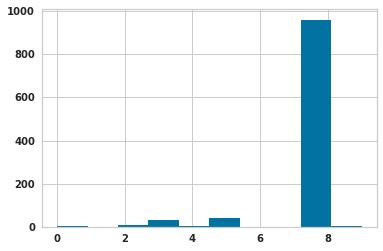

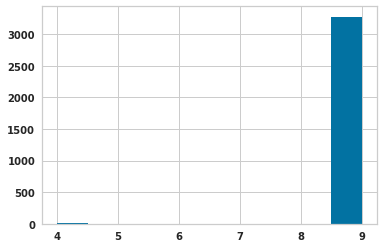

In [43]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [44]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'cluster_level_2',
       'distance_level_2_0_0', 'distance_level_2_0_1', 'distance_level_2_0_2',
       'distance_level_2_0_3', 'distance_level_2_0_4', 'distance_level_2_0_5',
       'distance_level_2_0_6', 'distance_level_2_0_7', 'distance_level_2_0_8',
       'distance_level_2_0_9', 'distance_level_2_4_0', 'distance_level_2_4_1',
       'distance_level_2_4_2', 'distance_level_2_4_3', 'distance_level_2_4_4',
       'distance_level_2_4_5', 'distance_level_2_4_6', 'distance_level_2_4_7',
       'dis

# Iteration 2

In [45]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 26666.54887640914
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 1/68, Nll_loss : 128.24790954589844 KLD:9.650392532348633  Supervised loss:0.446756511926651
Epoch: 1/69, Nll_loss : 139.33688354492188 KLD:9.991991996765137  Supervised loss:0.47494596242904663
Epoch: 1/70, Nll_loss : 145.98643493652344 KLD:9.430415153503418  Supervised loss:0.48350989818573
Epoch: 1/71, Nll_loss : 134.87771606445312 KLD:8.918110847473145  Supervised loss:0.4624153971672058
Epoch: 1/72, Nll_loss : 138.30172729492188 KLD:8.960935592651367  Supervised loss:0.553640604019165
Epoch: 1/73, Nll_loss : 140.572265625 KLD:9.055166244506836  Supervised loss:0.3753879964351654
Epoch: 1/74, Nll_loss : 137.63265991210938 KLD:9.46318531036377  Supervised loss:0.37104278802871704
Epoch: 1/75, Nll_loss : 145.38369750976562 KLD:10.01353645324707  Supervised loss:0.3611217141151428
Epoch: 1/76, Nll_loss : 131.77499389648438 KLD:9.765633583068848  Supervised loss:0.41633713245391846
Epoch: 1/77, Nll_loss : 133.2867431640625 KLD:9.962577819824219  Supervised loss:0.349479615688324

Epoch: 1/151, Nll_loss : 144.4812774658203 KLD:8.846449851989746  Supervised loss:0.42130184173583984
Epoch: 1/152, Nll_loss : 135.43365478515625 KLD:8.977410316467285  Supervised loss:0.34316137433052063
Epoch: 1/153, Nll_loss : 139.02676391601562 KLD:8.656167984008789  Supervised loss:0.3508274555206299
Epoch: 1/154, Nll_loss : 130.09378051757812 KLD:9.823324203491211  Supervised loss:0.22341154515743256
Epoch: 1/155, Nll_loss : 134.22853088378906 KLD:9.836517333984375  Supervised loss:0.3965267539024353
Epoch: 1/156, Nll_loss : 139.58412170410156 KLD:9.610692977905273  Supervised loss:0.4956286549568176
Epoch: 1/157, Nll_loss : 131.49221801757812 KLD:9.378154754638672  Supervised loss:0.4113163650035858
Epoch: 1/158, Nll_loss : 134.77835083007812 KLD:9.778804779052734  Supervised loss:0.2574678659439087
Epoch: 1/159, Nll_loss : 132.3594207763672 KLD:9.123488426208496  Supervised loss:0.4040253758430481
Epoch: 1/160, Nll_loss : 139.27621459960938 KLD:9.678937911987305  Supervised los

Epoch: 1/233, Nll_loss : 131.41531372070312 KLD:9.123468399047852  Supervised loss:0.2712990343570709
Epoch: 1/234, Nll_loss : 133.62107849121094 KLD:9.67936897277832  Supervised loss:0.21934625506401062
Epoch: 1/235, Nll_loss : 133.846923828125 KLD:9.135601043701172  Supervised loss:0.34859001636505127
Epoch: 1/236, Nll_loss : 134.4703826904297 KLD:9.551337242126465  Supervised loss:0.3490334153175354
Epoch: 1/237, Nll_loss : 128.4359130859375 KLD:10.124542236328125  Supervised loss:0.33351582288742065
Epoch: 1/238, Nll_loss : 142.58969116210938 KLD:8.808950424194336  Supervised loss:0.4646153450012207
Epoch: 1/239, Nll_loss : 127.12128448486328 KLD:9.279512405395508  Supervised loss:0.36580145359039307
Epoch: 1/240, Nll_loss : 132.0850830078125 KLD:9.057892799377441  Supervised loss:0.30753660202026367
Epoch: 1/241, Nll_loss : 132.11026000976562 KLD:8.816652297973633  Supervised loss:0.3507978022098541
Epoch: 1/242, Nll_loss : 133.77642822265625 KLD:8.529158592224121  Supervised loss

Epoch: 1/315, Nll_loss : 123.84610748291016 KLD:9.580034255981445  Supervised loss:0.27208516001701355
Epoch: 1/316, Nll_loss : 124.6533432006836 KLD:9.887808799743652  Supervised loss:0.3075801730155945
Epoch: 1/317, Nll_loss : 125.60950469970703 KLD:9.94480037689209  Supervised loss:0.33998197317123413
Epoch: 1/318, Nll_loss : 126.51172637939453 KLD:9.663627624511719  Supervised loss:0.33471035957336426
Epoch: 1/319, Nll_loss : 122.94535827636719 KLD:9.57227897644043  Supervised loss:0.22592560946941376
Epoch: 1/320, Nll_loss : 132.32196044921875 KLD:9.36143684387207  Supervised loss:0.3035622239112854
Epoch: 1/321, Nll_loss : 126.62034606933594 KLD:8.450162887573242  Supervised loss:0.3432416021823883
Epoch: 1/322, Nll_loss : 131.43768310546875 KLD:8.538431167602539  Supervised loss:0.3157188296318054
Epoch: 1/323, Nll_loss : 130.84605407714844 KLD:8.635529518127441  Supervised loss:0.47227194905281067
Epoch: 1/324, Nll_loss : 128.0385284423828 KLD:8.808793067932129  Supervised loss

Epoch: 1/397, Nll_loss : 129.74472045898438 KLD:9.018987655639648  Supervised loss:0.2420426607131958
Epoch: 1/398, Nll_loss : 124.3179931640625 KLD:8.297521591186523  Supervised loss:0.3226018249988556
Epoch: 1/399, Nll_loss : 137.71881103515625 KLD:8.680641174316406  Supervised loss:0.3541582226753235
Epoch: 1/400, Nll_loss : 135.93040466308594 KLD:8.672708511352539  Supervised loss:0.29812514781951904
Epoch: 1/401, Nll_loss : 132.50296020507812 KLD:8.5621976852417  Supervised loss:0.3723887801170349
Epoch: 1/402, Nll_loss : 124.51386260986328 KLD:9.257204055786133  Supervised loss:0.34444430470466614
Epoch: 1/403, Nll_loss : 129.62002563476562 KLD:9.109521865844727  Supervised loss:0.5097165107727051
Epoch: 1/404, Nll_loss : 132.6278533935547 KLD:9.277576446533203  Supervised loss:0.30168235301971436
Epoch: 1/405, Nll_loss : 119.74065399169922 KLD:9.242464065551758  Supervised loss:0.38933396339416504
Epoch: 1/406, Nll_loss : 124.27509307861328 KLD:9.448429107666016  Supervised loss

Epoch: 1/478, Nll_loss : 130.54324340820312 KLD:9.845821380615234  Supervised loss:0.3772897720336914
Epoch: 1/479, Nll_loss : 123.54441833496094 KLD:10.135843276977539  Supervised loss:0.39721566438674927
Epoch: 1/480, Nll_loss : 131.69461059570312 KLD:9.906400680541992  Supervised loss:0.3218452036380768
Epoch: 1/481, Nll_loss : 124.39788055419922 KLD:9.728809356689453  Supervised loss:0.20863287150859833
Epoch: 1/482, Nll_loss : 129.1012420654297 KLD:9.285995483398438  Supervised loss:0.2915593683719635
Epoch: 1/483, Nll_loss : 128.49411010742188 KLD:9.20648193359375  Supervised loss:0.4090750217437744
Epoch: 1/484, Nll_loss : 130.67355346679688 KLD:8.777191162109375  Supervised loss:0.35006746649742126
Epoch: 1/485, Nll_loss : 129.09820556640625 KLD:8.593353271484375  Supervised loss:0.35337531566619873
Epoch: 1/486, Nll_loss : 132.50198364257812 KLD:8.385055541992188  Supervised loss:0.33369261026382446
Epoch: 1/487, Nll_loss : 133.667236328125 KLD:8.346658706665039  Supervised lo

Epoch: 1/560, Nll_loss : 123.09928894042969 KLD:9.814849853515625  Supervised loss:0.2879924774169922
Epoch: 1/561, Nll_loss : 121.97650146484375 KLD:9.300363540649414  Supervised loss:0.4047023355960846
Epoch: 1/562, Nll_loss : 121.40229034423828 KLD:9.417983055114746  Supervised loss:0.30512237548828125
Epoch: 1/563, Nll_loss : 128.09449768066406 KLD:8.932868003845215  Supervised loss:0.3121389150619507
Epoch: 1/564, Nll_loss : 127.59490966796875 KLD:9.357145309448242  Supervised loss:0.26679664850234985
Epoch: 1/565, Nll_loss : 130.86932373046875 KLD:9.456680297851562  Supervised loss:0.26064398884773254
Epoch: 1/566, Nll_loss : 118.15646362304688 KLD:9.132804870605469  Supervised loss:0.29678329825401306
Epoch: 1/567, Nll_loss : 127.302978515625 KLD:9.041374206542969  Supervised loss:0.39672884345054626
Epoch: 1/568, Nll_loss : 125.42353820800781 KLD:9.026463508605957  Supervised loss:0.30869174003601074
Epoch: 1/569, Nll_loss : 125.556396484375 KLD:9.084550857543945  Supervised lo

Epoch: 1/642, Nll_loss : 125.45779418945312 KLD:9.36004638671875  Supervised loss:0.3985297381877899
Epoch: 1/643, Nll_loss : 139.40158081054688 KLD:9.612944602966309  Supervised loss:0.3236687183380127
Epoch: 1/644, Nll_loss : 130.62472534179688 KLD:9.18136978149414  Supervised loss:0.36511266231536865
Epoch: 1/645, Nll_loss : 129.9627227783203 KLD:8.980600357055664  Supervised loss:0.2486208975315094
Epoch: 1/646, Nll_loss : 121.93400573730469 KLD:9.063570022583008  Supervised loss:0.3648605942726135
Epoch: 1/647, Nll_loss : 131.80859375 KLD:8.57420825958252  Supervised loss:0.3531181216239929
Epoch: 1/648, Nll_loss : 126.88934326171875 KLD:8.70655345916748  Supervised loss:0.2763618528842926
Epoch: 1/649, Nll_loss : 131.7408447265625 KLD:9.207040786743164  Supervised loss:0.32624197006225586
Epoch: 1/650, Nll_loss : 132.6397247314453 KLD:8.93556022644043  Supervised loss:0.28854256868362427
Epoch: 1/651, Nll_loss : 127.87395477294922 KLD:8.971036911010742  Supervised loss:0.36718189

Epoch: 1/724, Nll_loss : 123.99960327148438 KLD:10.004255294799805  Supervised loss:0.21873322129249573
Epoch: 1/725, Nll_loss : 127.86122131347656 KLD:9.80952262878418  Supervised loss:0.19390910863876343
Epoch: 1/726, Nll_loss : 125.54217529296875 KLD:9.619180679321289  Supervised loss:0.30243444442749023
Epoch: 1/727, Nll_loss : 125.66883087158203 KLD:9.388837814331055  Supervised loss:0.2509167194366455
Epoch: 1/728, Nll_loss : 124.33758544921875 KLD:9.541324615478516  Supervised loss:0.3911880850791931
Epoch: 1/729, Nll_loss : 121.19709777832031 KLD:9.44407844543457  Supervised loss:0.23122970759868622
Epoch: 1/730, Nll_loss : 119.76774597167969 KLD:8.566061019897461  Supervised loss:0.2663397789001465
Epoch: 1/731, Nll_loss : 123.8836669921875 KLD:9.048868179321289  Supervised loss:0.3214174807071686
Epoch: 1/732, Nll_loss : 118.50153350830078 KLD:9.01707649230957  Supervised loss:0.3059937357902527
Epoch: 1/733, Nll_loss : 125.76483154296875 KLD:8.808511734008789  Supervised los

Epoch: 1/805, Nll_loss : 123.45428466796875 KLD:9.693017959594727  Supervised loss:0.25862210988998413
Epoch: 1/806, Nll_loss : 130.12326049804688 KLD:9.022024154663086  Supervised loss:0.3154868483543396
Epoch: 1/807, Nll_loss : 122.14988708496094 KLD:9.358835220336914  Supervised loss:0.20083746314048767
Epoch: 1/808, Nll_loss : 124.86236572265625 KLD:8.580068588256836  Supervised loss:0.2815946936607361
Epoch: 1/809, Nll_loss : 121.79337310791016 KLD:8.727409362792969  Supervised loss:0.30446264147758484
Epoch: 1/810, Nll_loss : 128.44430541992188 KLD:8.599979400634766  Supervised loss:0.39056429266929626
Epoch: 1/811, Nll_loss : 129.654052734375 KLD:8.770844459533691  Supervised loss:0.37847357988357544
Epoch: 1/812, Nll_loss : 131.82786560058594 KLD:8.254707336425781  Supervised loss:0.3900999426841736
Epoch: 1/813, Nll_loss : 126.92117309570312 KLD:8.760069847106934  Supervised loss:0.24268963932991028
Epoch: 1/814, Nll_loss : 124.13204193115234 KLD:9.044281959533691  Supervised 

Epoch: 1/886, Nll_loss : 120.9439468383789 KLD:8.69158935546875  Supervised loss:0.34206491708755493
Epoch: 1/887, Nll_loss : 126.69720458984375 KLD:9.117103576660156  Supervised loss:0.326138973236084
Epoch: 1/888, Nll_loss : 127.11854553222656 KLD:8.977832794189453  Supervised loss:0.3192005157470703
Epoch: 1/889, Nll_loss : 118.99897003173828 KLD:9.349238395690918  Supervised loss:0.32318800687789917
Epoch: 1/890, Nll_loss : 121.33424377441406 KLD:9.923805236816406  Supervised loss:0.2149328589439392
Epoch: 1/891, Nll_loss : 125.25120544433594 KLD:9.933786392211914  Supervised loss:0.3473290205001831
Epoch: 1/892, Nll_loss : 130.67254638671875 KLD:9.962289810180664  Supervised loss:0.334299236536026
Epoch: 1/893, Nll_loss : 118.37144470214844 KLD:10.657827377319336  Supervised loss:0.17146089673042297
Epoch: 1/894, Nll_loss : 112.63119506835938 KLD:10.140497207641602  Supervised loss:0.255002498626709
Epoch: 1/895, Nll_loss : 117.34649658203125 KLD:9.788926124572754  Supervised loss

In [48]:
K

10

In [49]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


In [50]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.491272400000001 z_max=4.6749906999999995
Latent vectors shape (59840, 10)


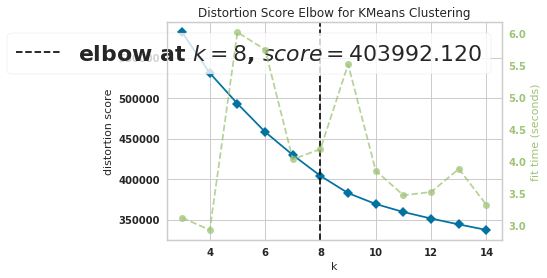

In [51]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


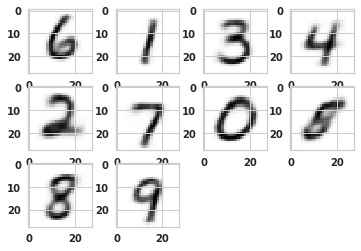

In [52]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [59]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 1, 3, 4,
                                           2, 7, 0, -1,
                                           8, 9
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 0.9, 0.9,
                                               0.9, 0.9, 1, 0,
                                               0.9, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [60]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [61]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

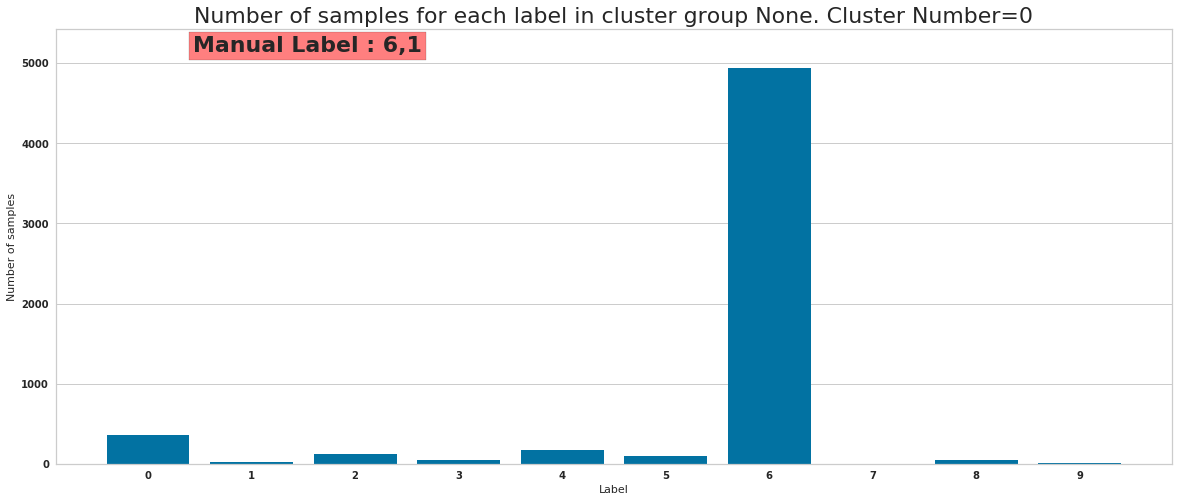

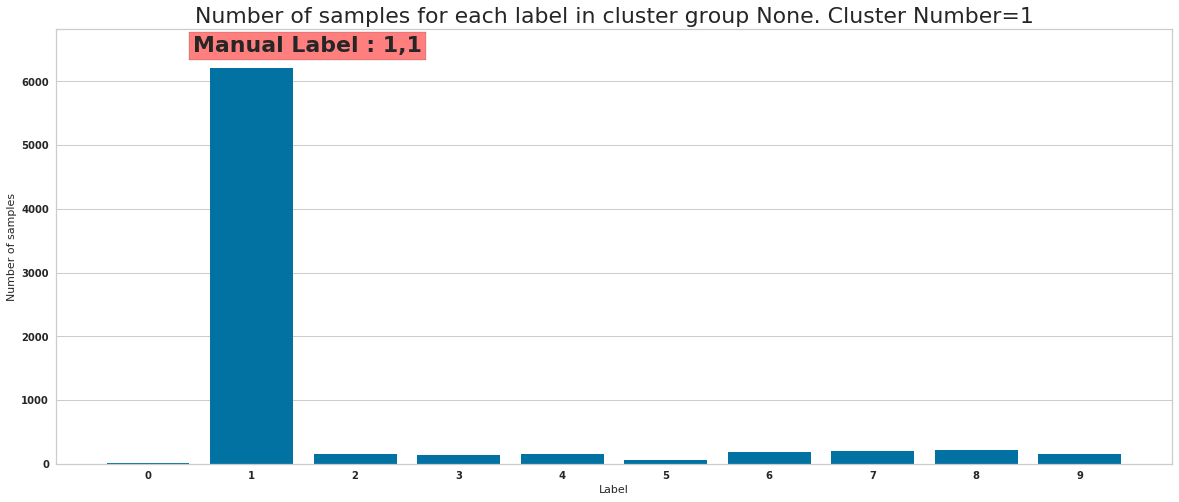

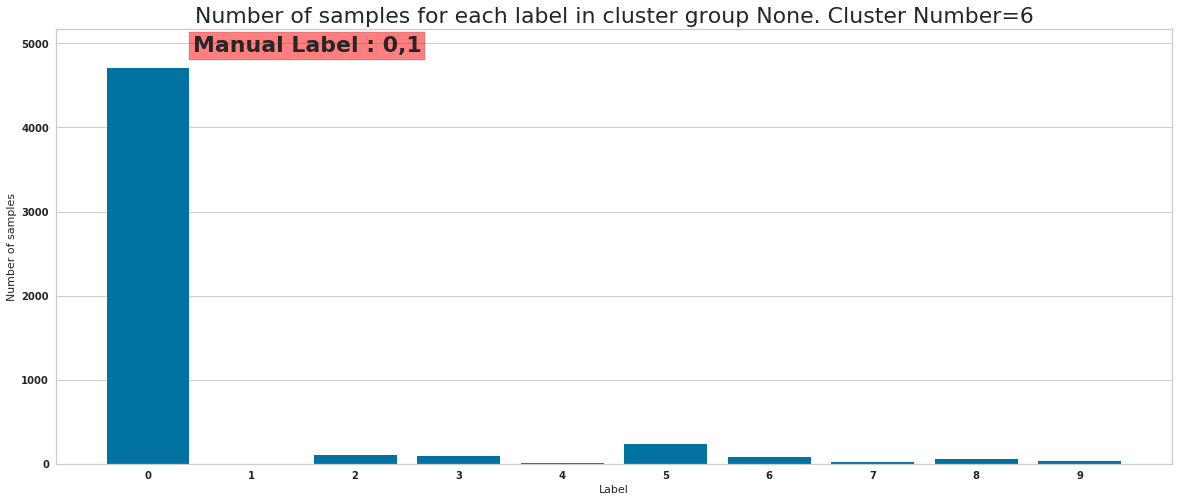

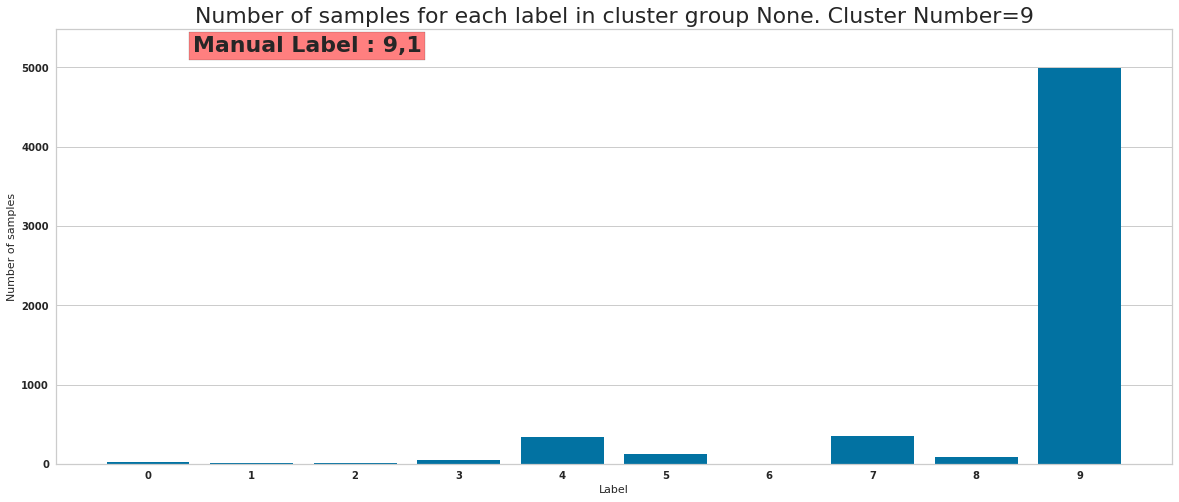

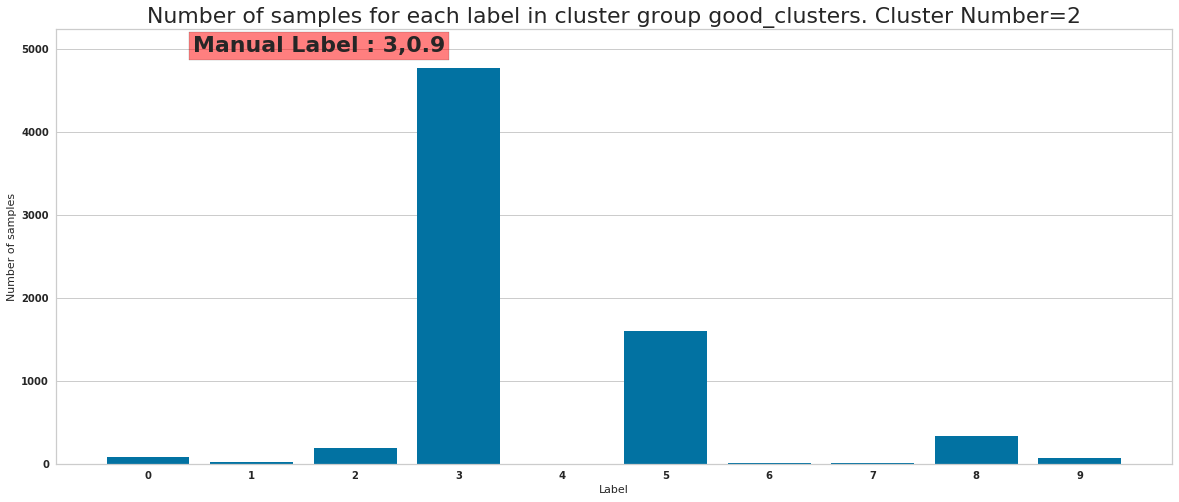

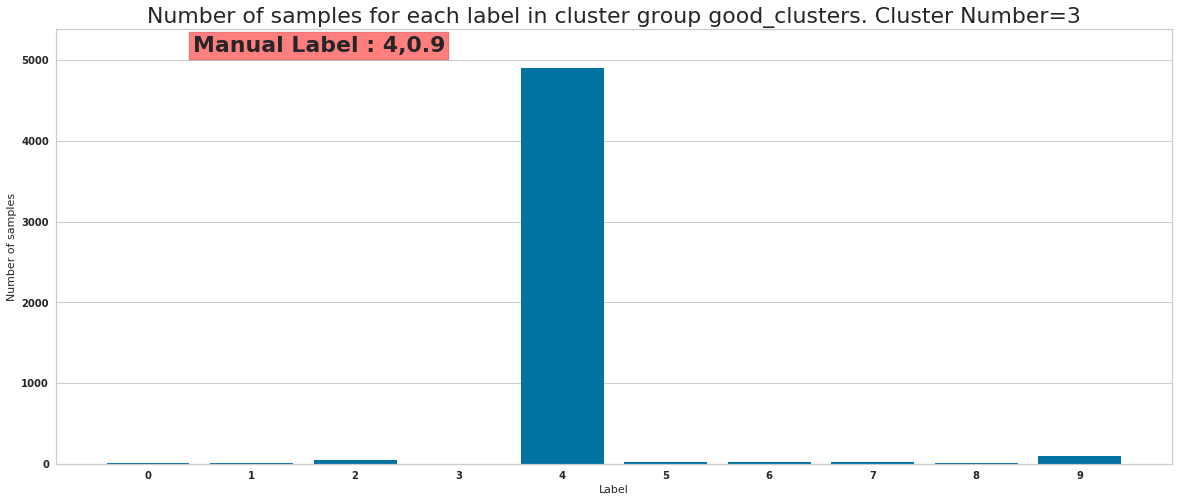

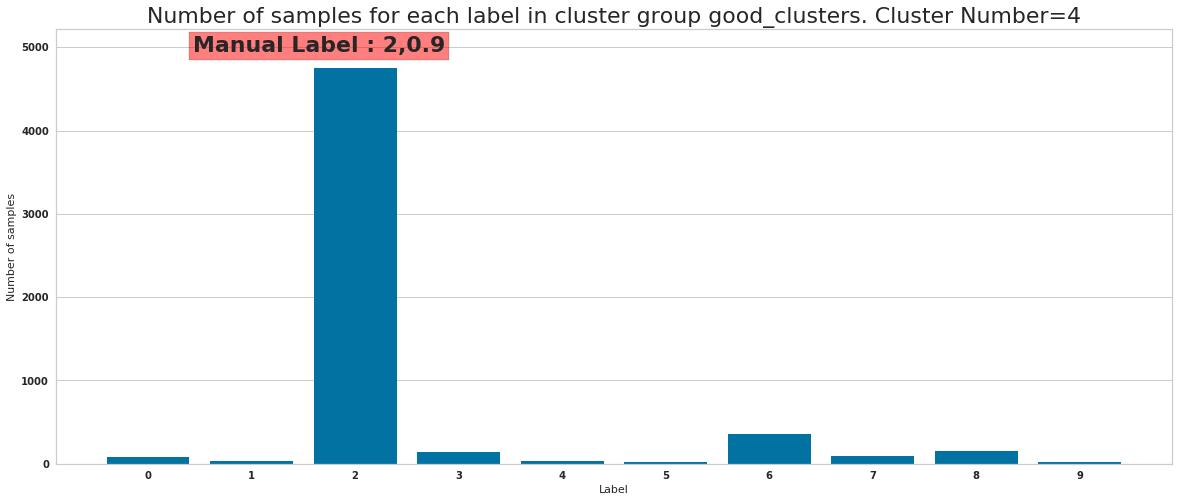

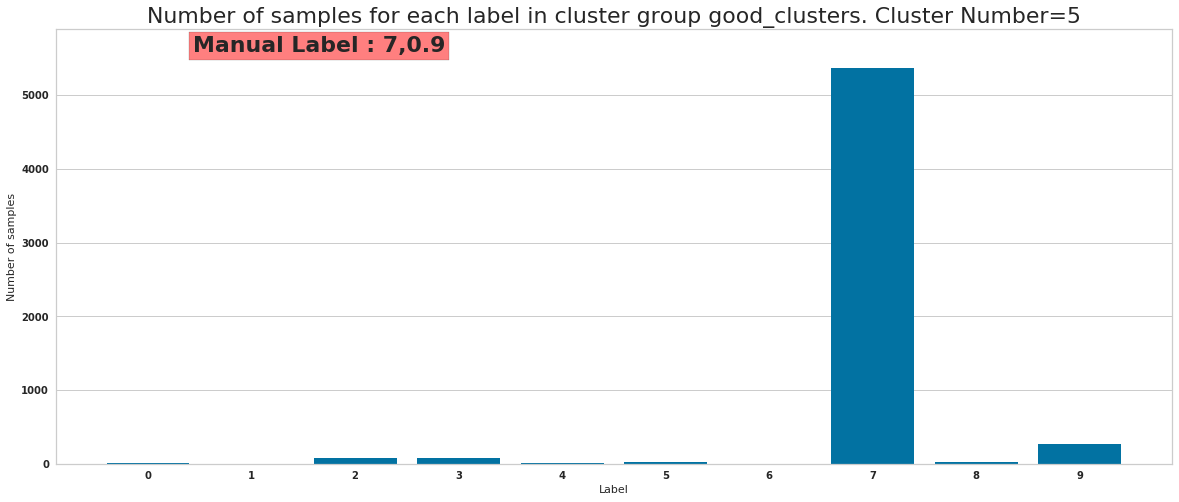

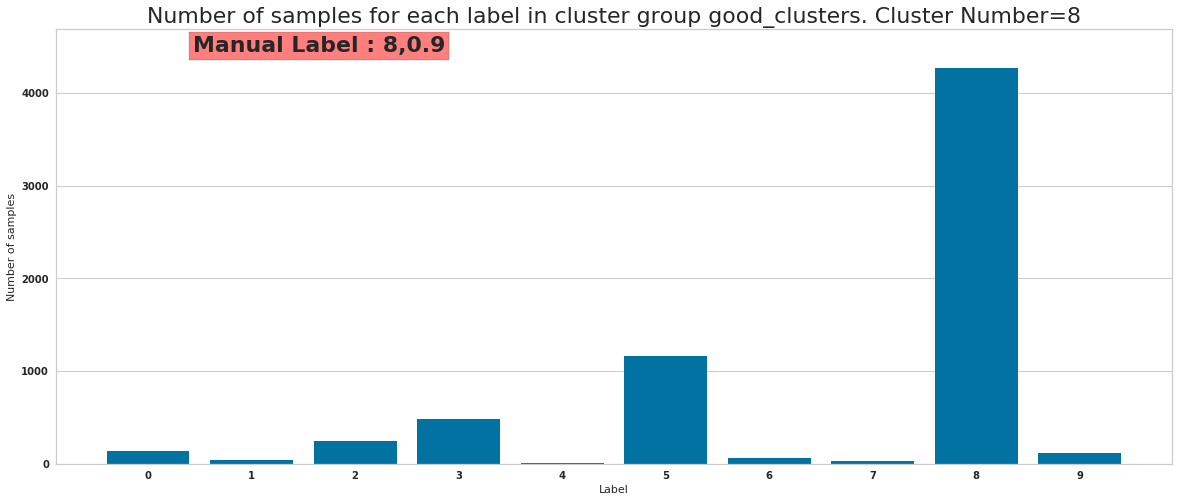

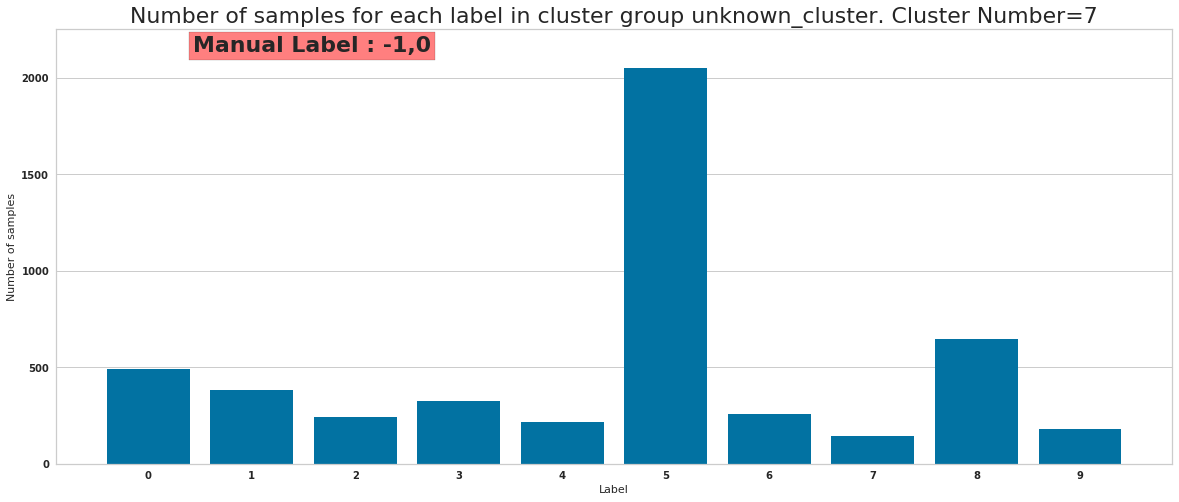

In [62]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [63]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5831, 10)
(7465, 10)
(7093, 10)
(5120, 10)
(5684, 10)
(5852, 10)
(5343, 10)
(4923, 10)
(6566, 10)
(5963, 10)


7
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


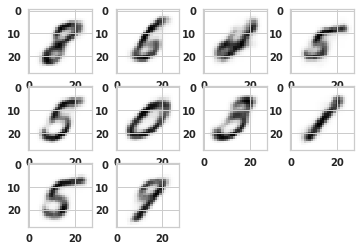

In [64]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [67]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [8, 6, -1, -1,
                                        -1, 0, -1, 1,
                                        5, -1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0.6, 0.6, 0, 0,
                                             0, 0.9, 0, 0.9,
                                             0.7, 0
                                             ]
level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [68]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

7
10
0 (562,)
1 (366,)
Skipping distance computation for unknown cluster
5 (449,)
7 (458,)
8 (638,)
Manual Label 6
(5831, 57) (5831, 43)
Num correct=4933
Cluster 0 Manual Label 6 Percentage correct 84.59955410735724
********************************
Manual Label 1
(7465, 57) (7465, 43)
Num correct=6202
Cluster 1 Manual Label 1 Percentage correct 83.08104487608841
********************************
Manual Label 3
(7093, 57) (7093, 43)
Num correct=4765
Cluster 2 Manual Label 3 Percentage correct 67.17890878330749
********************************
Manual Label 4
(5120, 57) (5120, 43)
Num correct=4895
Cluster 3 Manual Label 4 Percentage correct 95.60546875
********************************
Manual Label 2
(5684, 57) (5684, 43)
Num correct=4745
Cluster 4 Manual Label 2 Percentage correct 83.47994370161858
********************************
Manual Label 7
(5852, 57) (5852, 43)
Num correct=5363
Cluster 5 Manual Label 7 Percentage correct 91.64388243335611
********************************
Manual Label

In [69]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5831., 7465., 7093., 5120., 5684., 5852., 5343., 4923., 6566.,
        5963.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

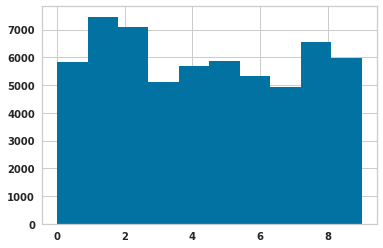

In [70]:
plt.hist(cluster_labels)

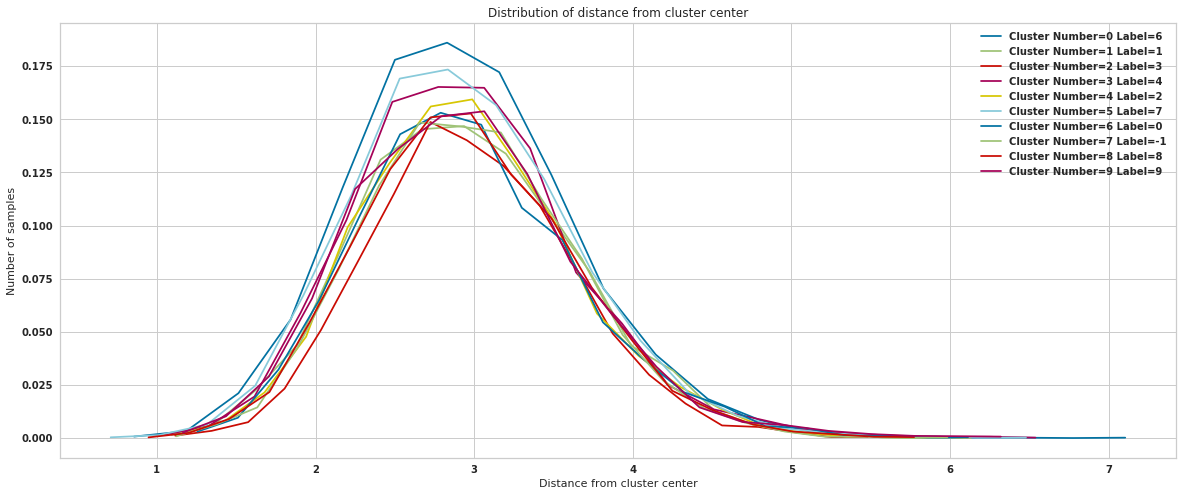

In [71]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

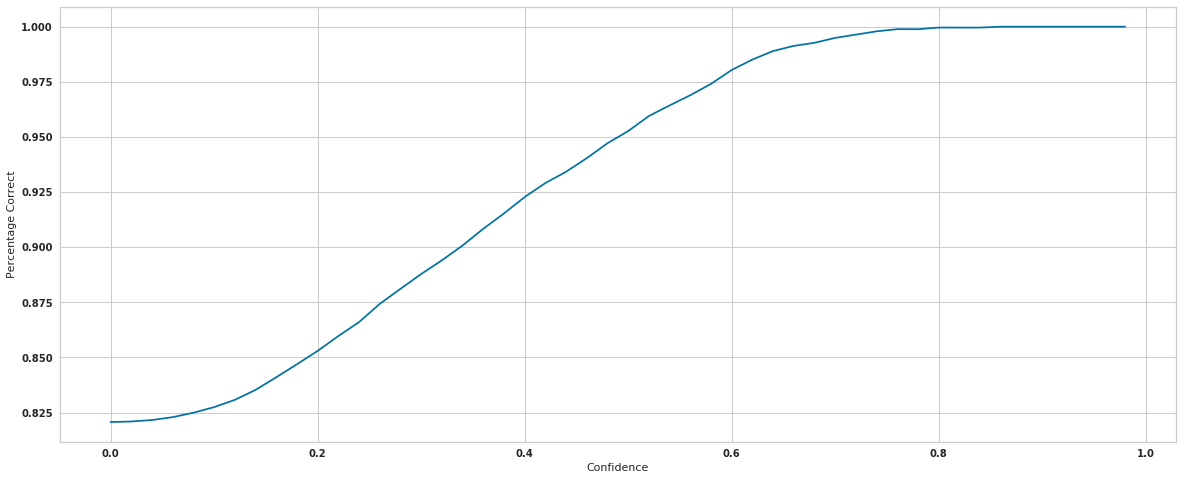

In [72]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

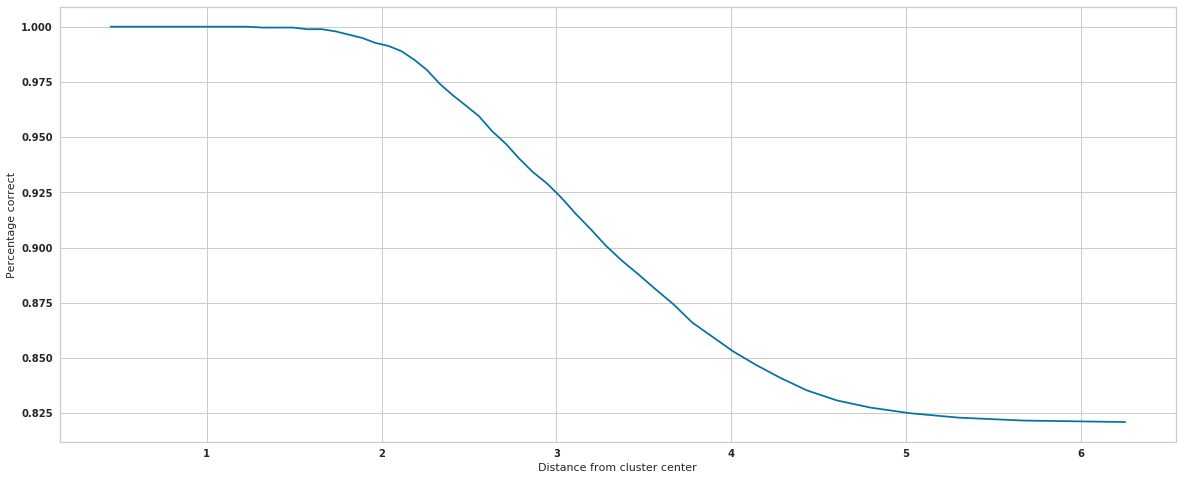

In [73]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [74]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

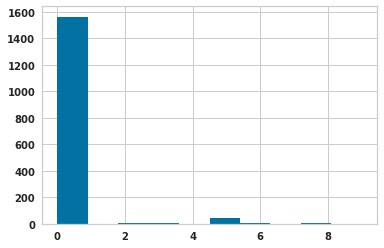

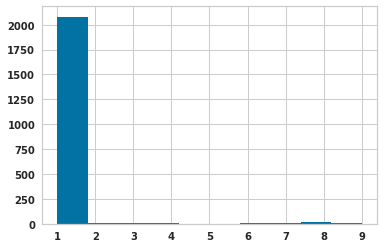

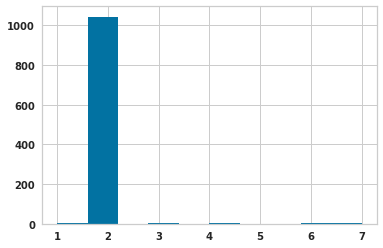

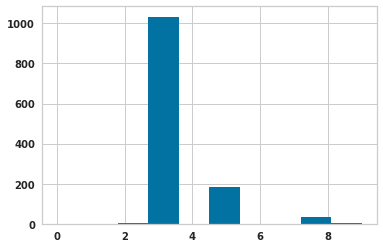

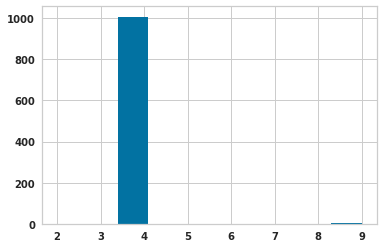

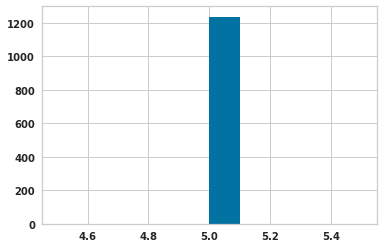

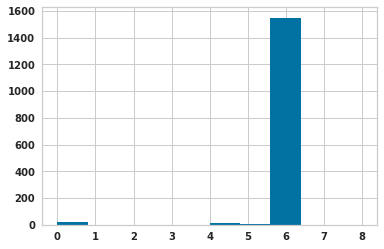

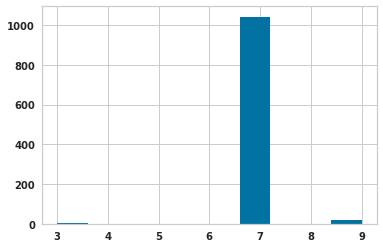

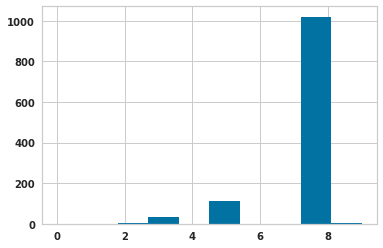

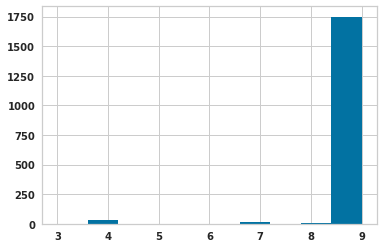

In [75]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [76]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [77]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [78]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23978.352058385768
INFO:tensorflow:Summary name Negative Log Like

Epoch: 2/64, Nll_loss : 122.128662109375 KLD:9.609209060668945  Supervised loss:0.15345998108386993
Epoch: 2/65, Nll_loss : 127.582763671875 KLD:10.196595191955566  Supervised loss:0.13499997556209564
Epoch: 2/66, Nll_loss : 111.75515747070312 KLD:9.863332748413086  Supervised loss:0.1269952952861786
Epoch: 2/67, Nll_loss : 115.42562866210938 KLD:9.27690315246582  Supervised loss:0.2028694450855255
Epoch: 2/68, Nll_loss : 123.21379089355469 KLD:9.976837158203125  Supervised loss:0.17426025867462158
Epoch: 2/69, Nll_loss : 131.4166259765625 KLD:10.085315704345703  Supervised loss:0.16287153959274292
Epoch: 2/70, Nll_loss : 118.87333679199219 KLD:9.965343475341797  Supervised loss:0.14077073335647583
Epoch: 2/71, Nll_loss : 124.60032653808594 KLD:9.71690559387207  Supervised loss:0.19279107451438904
Epoch: 2/72, Nll_loss : 126.15231323242188 KLD:9.550956726074219  Supervised loss:0.17453178763389587
Epoch: 2/73, Nll_loss : 125.75377655029297 KLD:9.391660690307617  Supervised loss:0.17688

Epoch: 2/146, Nll_loss : 115.2101058959961 KLD:10.109990119934082  Supervised loss:0.11399019509553909
Epoch: 2/147, Nll_loss : 123.34423828125 KLD:10.025182723999023  Supervised loss:0.10251547396183014
Epoch: 2/148, Nll_loss : 129.234375 KLD:9.77066421508789  Supervised loss:0.18501421809196472
Epoch: 2/149, Nll_loss : 118.78455352783203 KLD:9.504209518432617  Supervised loss:0.15484443306922913
Epoch: 2/150, Nll_loss : 129.59808349609375 KLD:9.97707748413086  Supervised loss:0.23325952887535095
Epoch: 2/151, Nll_loss : 120.20999908447266 KLD:9.719278335571289  Supervised loss:0.14874689280986786
Epoch: 2/152, Nll_loss : 122.13538360595703 KLD:9.487419128417969  Supervised loss:0.1867935061454773
Epoch: 2/153, Nll_loss : 118.62934112548828 KLD:9.806924819946289  Supervised loss:0.14807748794555664
Epoch: 2/154, Nll_loss : 125.91395568847656 KLD:9.508387565612793  Supervised loss:0.21058176457881927
Epoch: 2/155, Nll_loss : 129.97332763671875 KLD:9.38505744934082  Supervised loss:0.14

Epoch: 2/229, Nll_loss : 120.2956771850586 KLD:9.728456497192383  Supervised loss:0.1545991450548172
Epoch: 2/230, Nll_loss : 125.5298080444336 KLD:9.286492347717285  Supervised loss:0.18730583786964417
Epoch: 2/231, Nll_loss : 125.03514862060547 KLD:9.620546340942383  Supervised loss:0.15784817934036255
Epoch: 2/232, Nll_loss : 120.91963195800781 KLD:9.5701265335083  Supervised loss:0.17173054814338684
Epoch: 2/233, Nll_loss : 121.1666488647461 KLD:10.061891555786133  Supervised loss:0.08850589394569397
Epoch: 2/234, Nll_loss : 121.05662536621094 KLD:9.959299087524414  Supervised loss:0.15543052554130554
Epoch: 2/235, Nll_loss : 124.26643371582031 KLD:9.998059272766113  Supervised loss:0.11188212037086487
Epoch: 2/236, Nll_loss : 121.7164077758789 KLD:10.220263481140137  Supervised loss:0.19360344111919403
Epoch: 2/237, Nll_loss : 127.75053405761719 KLD:9.669025421142578  Supervised loss:0.18133318424224854
Epoch: 2/238, Nll_loss : 117.71842193603516 KLD:9.780494689941406  Supervised 

Epoch: 2/312, Nll_loss : 127.04827880859375 KLD:9.707789421081543  Supervised loss:0.11166764050722122
Epoch: 2/313, Nll_loss : 124.02227783203125 KLD:9.653797149658203  Supervised loss:0.12241464853286743
Epoch: 2/314, Nll_loss : 114.74710083007812 KLD:9.7460355758667  Supervised loss:0.15134115517139435
Epoch: 2/315, Nll_loss : 115.42674255371094 KLD:10.197698593139648  Supervised loss:0.1297120749950409
Epoch: 2/316, Nll_loss : 116.33169555664062 KLD:10.035321235656738  Supervised loss:0.08384117484092712
Epoch: 2/317, Nll_loss : 119.064453125 KLD:9.854303359985352  Supervised loss:0.15960490703582764
Epoch: 2/318, Nll_loss : 113.912841796875 KLD:9.912195205688477  Supervised loss:0.11198996007442474
Epoch: 2/319, Nll_loss : 121.530029296875 KLD:10.101829528808594  Supervised loss:0.14585451781749725
Epoch: 2/320, Nll_loss : 117.07669067382812 KLD:9.466043472290039  Supervised loss:0.17290641367435455
Epoch: 2/321, Nll_loss : 118.36395263671875 KLD:9.59316635131836  Supervised loss:

Epoch: 2/394, Nll_loss : 123.82931518554688 KLD:9.355224609375  Supervised loss:0.11256113648414612
Epoch: 2/395, Nll_loss : 122.71556854248047 KLD:9.130496978759766  Supervised loss:0.13736140727996826
Epoch: 2/396, Nll_loss : 120.38833618164062 KLD:9.668012619018555  Supervised loss:0.09699141979217529
Epoch: 2/397, Nll_loss : 115.2293701171875 KLD:8.90898323059082  Supervised loss:0.1302005648612976
Epoch: 2/398, Nll_loss : 128.18833923339844 KLD:9.522476196289062  Supervised loss:0.1792057752609253
Epoch: 2/399, Nll_loss : 125.27111053466797 KLD:9.597042083740234  Supervised loss:0.11012129485607147
Epoch: 2/400, Nll_loss : 124.59159088134766 KLD:9.188981056213379  Supervised loss:0.22743971645832062
Epoch: 2/401, Nll_loss : 114.64047241210938 KLD:9.640483856201172  Supervised loss:0.10427230596542358
Epoch: 2/402, Nll_loss : 118.3731689453125 KLD:9.929872512817383  Supervised loss:0.17253687977790833
Epoch: 2/403, Nll_loss : 121.294677734375 KLD:10.046772956848145  Supervised loss

Epoch: 2/475, Nll_loss : 122.9794921875 KLD:9.795306205749512  Supervised loss:0.17491917312145233
Epoch: 2/476, Nll_loss : 118.46755981445312 KLD:10.319868087768555  Supervised loss:0.09418854862451553
Epoch: 2/477, Nll_loss : 120.03956604003906 KLD:10.081695556640625  Supervised loss:0.1196647435426712
Epoch: 2/478, Nll_loss : 119.65657806396484 KLD:9.690717697143555  Supervised loss:0.12636198103427887
Epoch: 2/479, Nll_loss : 125.5289306640625 KLD:10.131057739257812  Supervised loss:0.15263128280639648
Epoch: 2/480, Nll_loss : 118.44807434082031 KLD:9.63874626159668  Supervised loss:0.12067440152168274
Epoch: 2/481, Nll_loss : 121.60585021972656 KLD:9.594104766845703  Supervised loss:0.21241068840026855
Epoch: 2/482, Nll_loss : 123.37666320800781 KLD:9.649169921875  Supervised loss:0.1676323413848877
Epoch: 2/483, Nll_loss : 117.47696685791016 KLD:9.661352157592773  Supervised loss:0.14264729619026184
Epoch: 2/484, Nll_loss : 122.30707550048828 KLD:9.325424194335938  Supervised los

Epoch: 2/558, Nll_loss : 119.926513671875 KLD:9.274332046508789  Supervised loss:0.10325679183006287
Epoch: 2/559, Nll_loss : 118.48876953125 KLD:9.702873229980469  Supervised loss:0.13079527020454407
Epoch: 2/560, Nll_loss : 113.94963836669922 KLD:9.418691635131836  Supervised loss:0.15439918637275696
Epoch: 2/561, Nll_loss : 116.85913848876953 KLD:9.61349105834961  Supervised loss:0.15767809748649597
Epoch: 2/562, Nll_loss : 118.60531616210938 KLD:9.456100463867188  Supervised loss:0.20269019901752472
Epoch: 2/563, Nll_loss : 118.87733459472656 KLD:9.85183334350586  Supervised loss:0.1444316804409027
Epoch: 2/564, Nll_loss : 120.91635131835938 KLD:9.808530807495117  Supervised loss:0.15987618267536163
Epoch: 2/565, Nll_loss : 108.70818328857422 KLD:9.787303924560547  Supervised loss:0.1253349781036377
Epoch: 2/566, Nll_loss : 118.60595703125 KLD:9.64018440246582  Supervised loss:0.16586601734161377
Epoch: 2/567, Nll_loss : 118.75758361816406 KLD:9.36311149597168  Supervised loss:0.15

Epoch: 2/641, Nll_loss : 116.62017822265625 KLD:9.52171516418457  Supervised loss:0.09206165373325348
Epoch: 2/642, Nll_loss : 136.51373291015625 KLD:10.035544395446777  Supervised loss:0.17247352004051208
Epoch: 2/643, Nll_loss : 126.50645446777344 KLD:9.739202499389648  Supervised loss:0.15154922008514404
Epoch: 2/644, Nll_loss : 119.56085205078125 KLD:9.733537673950195  Supervised loss:0.13058283925056458
Epoch: 2/645, Nll_loss : 115.849853515625 KLD:9.517266273498535  Supervised loss:0.15453246235847473
Epoch: 2/646, Nll_loss : 123.13558959960938 KLD:9.169523239135742  Supervised loss:0.1642865687608719
Epoch: 2/647, Nll_loss : 121.9112777709961 KLD:9.088141441345215  Supervised loss:0.18739545345306396
Epoch: 2/648, Nll_loss : 125.81156921386719 KLD:9.400557518005371  Supervised loss:0.1352265179157257
Epoch: 2/649, Nll_loss : 124.82979583740234 KLD:9.323180198669434  Supervised loss:0.16281189024448395
Epoch: 2/650, Nll_loss : 117.07228088378906 KLD:9.407017707824707  Supervised 

Epoch: 2/721, Nll_loss : 121.97769165039062 KLD:8.995685577392578  Supervised loss:0.1164001077413559
Epoch: 2/722, Nll_loss : 118.14224243164062 KLD:8.906845092773438  Supervised loss:0.15340740978717804
Epoch: 2/723, Nll_loss : 118.33071899414062 KLD:9.260625839233398  Supervised loss:0.17880353331565857
Epoch: 2/724, Nll_loss : 122.41981506347656 KLD:9.355770111083984  Supervised loss:0.09196174889802933
Epoch: 2/725, Nll_loss : 120.30982971191406 KLD:9.405536651611328  Supervised loss:0.13664188981056213
Epoch: 2/726, Nll_loss : 121.50305938720703 KLD:9.483567237854004  Supervised loss:0.17924267053604126
Epoch: 2/727, Nll_loss : 117.91741943359375 KLD:9.72609806060791  Supervised loss:0.16376563906669617
Epoch: 2/728, Nll_loss : 116.3660888671875 KLD:10.151578903198242  Supervised loss:0.10940840095281601
Epoch: 2/729, Nll_loss : 113.27815246582031 KLD:9.678511619567871  Supervised loss:0.10418061912059784
Epoch: 2/730, Nll_loss : 113.8216552734375 KLD:10.407759666442871  Supervis

Epoch: 2/803, Nll_loss : 117.30487060546875 KLD:9.080123901367188  Supervised loss:0.1590486466884613
Epoch: 2/804, Nll_loss : 122.59291076660156 KLD:9.550973892211914  Supervised loss:0.14550258219242096
Epoch: 2/805, Nll_loss : 121.39307403564453 KLD:9.38243579864502  Supervised loss:0.12159796059131622
Epoch: 2/806, Nll_loss : 116.4128646850586 KLD:9.924226760864258  Supervised loss:0.13111324608325958
Epoch: 2/807, Nll_loss : 115.15359497070312 KLD:9.254533767700195  Supervised loss:0.1708495020866394
Epoch: 2/808, Nll_loss : 114.01953125 KLD:9.57503604888916  Supervised loss:0.19120848178863525
Epoch: 2/809, Nll_loss : 122.52568817138672 KLD:9.644546508789062  Supervised loss:0.11638130247592926
Epoch: 2/810, Nll_loss : 121.1476821899414 KLD:9.625007629394531  Supervised loss:0.11243849992752075
Epoch: 2/811, Nll_loss : 122.48423767089844 KLD:9.433523178100586  Supervised loss:0.13244345784187317
Epoch: 2/812, Nll_loss : 117.1302490234375 KLD:9.836360931396484  Supervised loss:0.0

Epoch: 2/884, Nll_loss : 122.77793884277344 KLD:9.47279167175293  Supervised loss:0.17138314247131348
Epoch: 2/885, Nll_loss : 117.10924530029297 KLD:9.184085845947266  Supervised loss:0.11898306012153625
Epoch: 2/886, Nll_loss : 118.72503662109375 KLD:9.750345230102539  Supervised loss:0.26156729459762573
Epoch: 2/887, Nll_loss : 122.90330505371094 KLD:9.377229690551758  Supervised loss:0.22678358852863312
Epoch: 2/888, Nll_loss : 112.91812133789062 KLD:9.740791320800781  Supervised loss:0.12066112458705902
Epoch: 2/889, Nll_loss : 117.785400390625 KLD:10.079658508300781  Supervised loss:0.2270108163356781
Epoch: 2/890, Nll_loss : 121.51933288574219 KLD:10.031606674194336  Supervised loss:0.0862172394990921
Epoch: 2/891, Nll_loss : 125.0440673828125 KLD:10.49487018585205  Supervised loss:0.2366023063659668
Epoch: 2/892, Nll_loss : 111.31024169921875 KLD:10.607091903686523  Supervised loss:0.13061301410198212
Epoch: 2/893, Nll_loss : 110.51837921142578 KLD:10.126893043518066  Supervise

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=45 z_min=-4.7297425 z_max=4.696025
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; usi

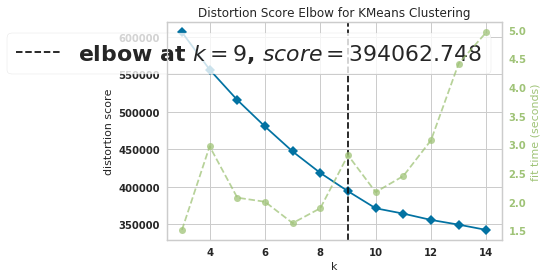

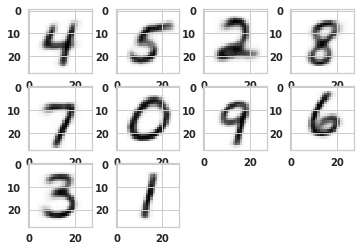

In [79]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [83]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [4, 5, 2, 8,
                                           7, 0, 9, 6,
                                           3, 1
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               0.9, 1, 1, 1,
                                               0.9, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


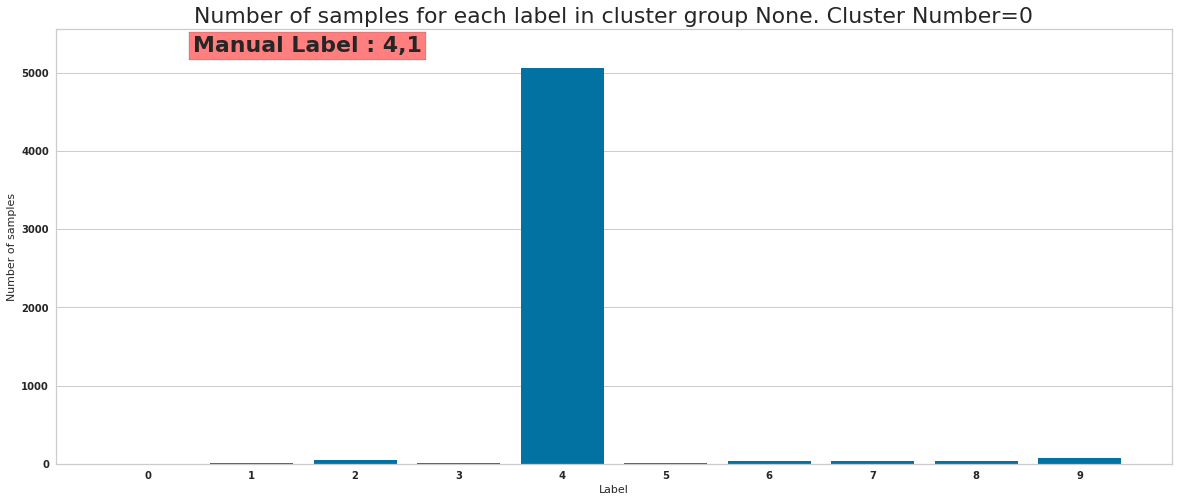

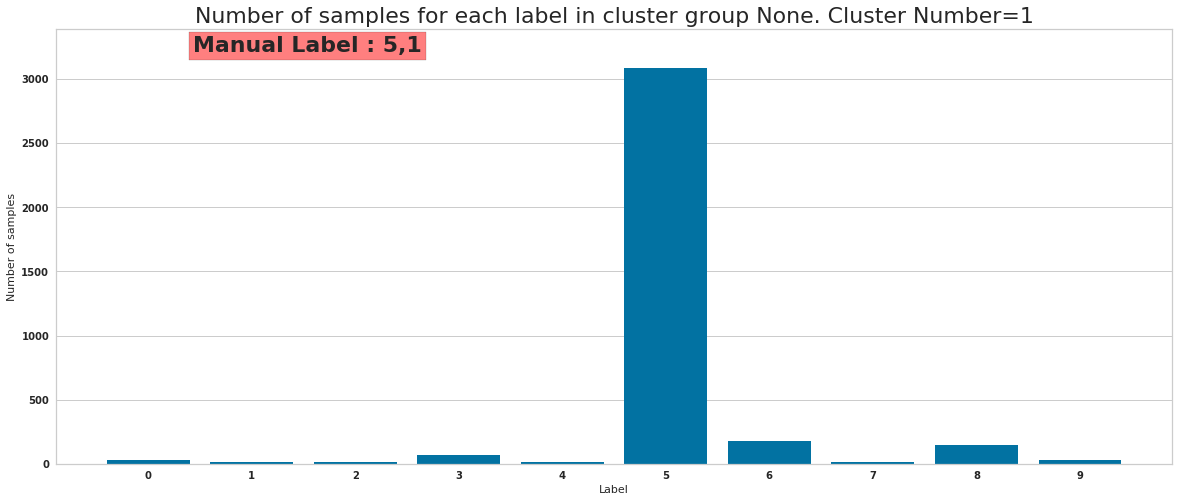

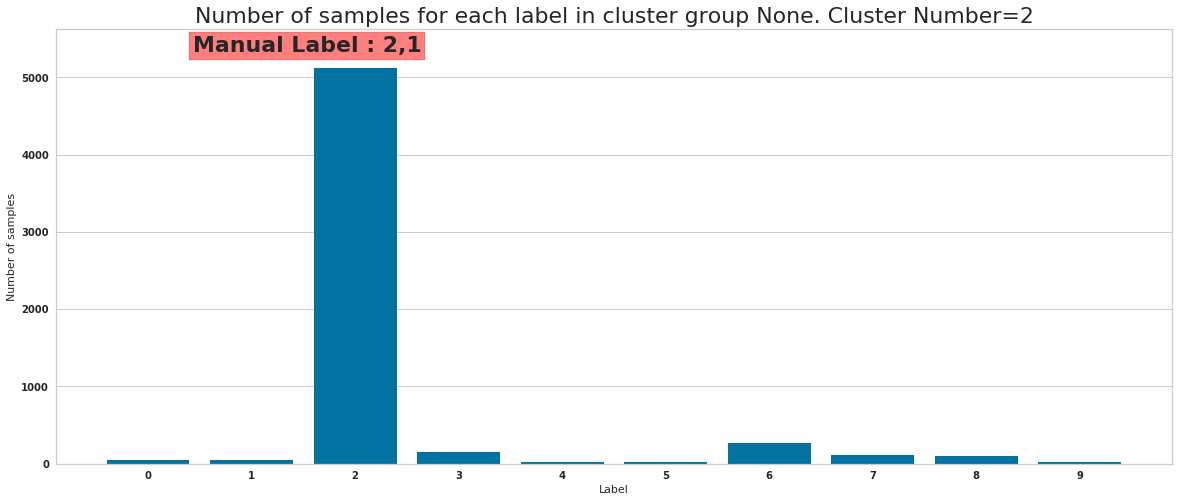

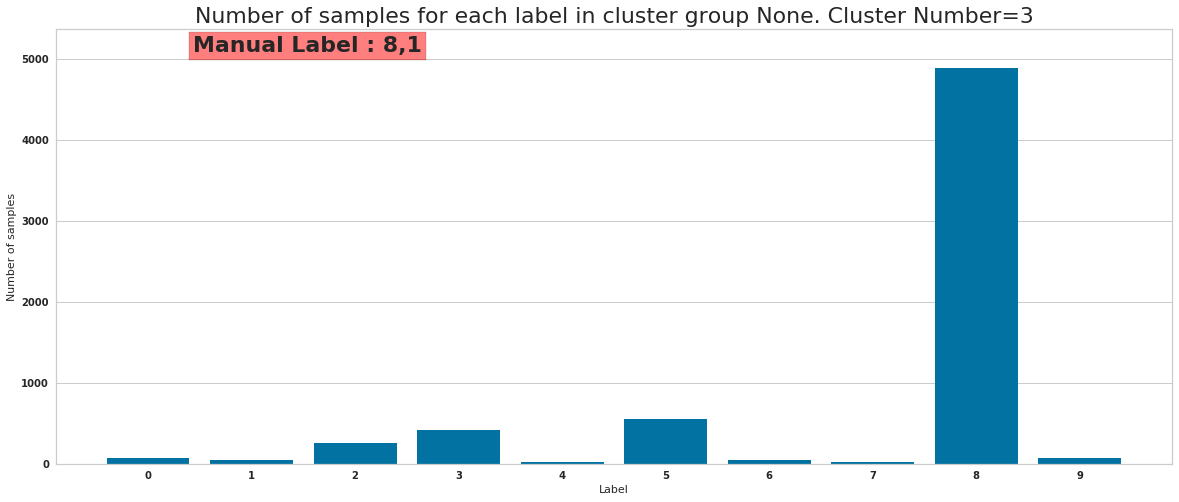

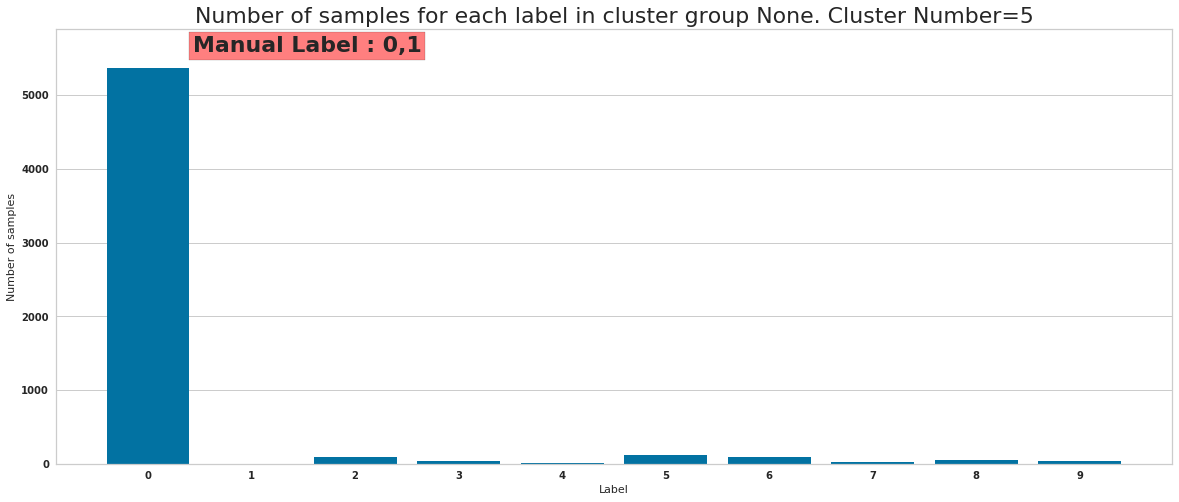

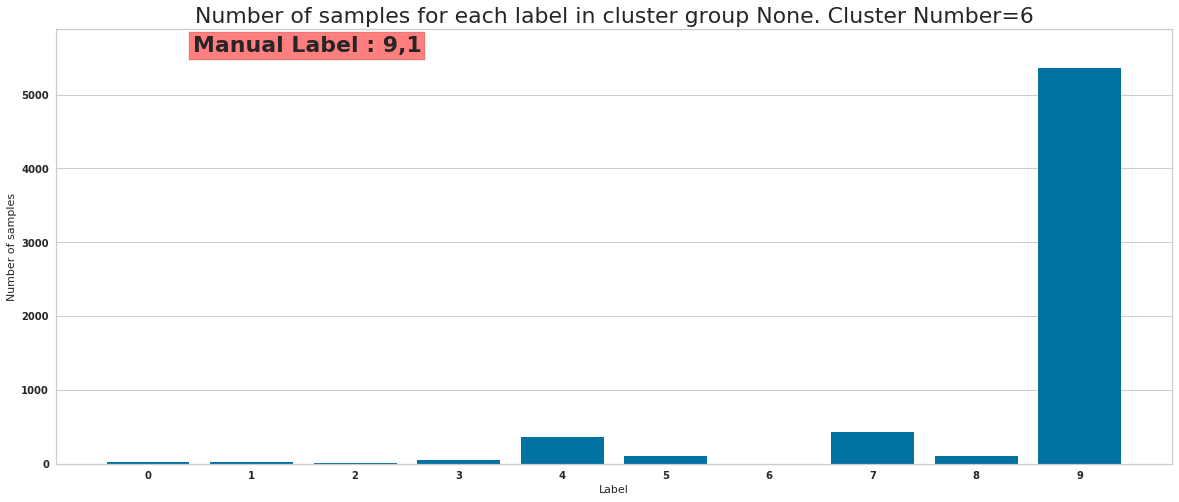

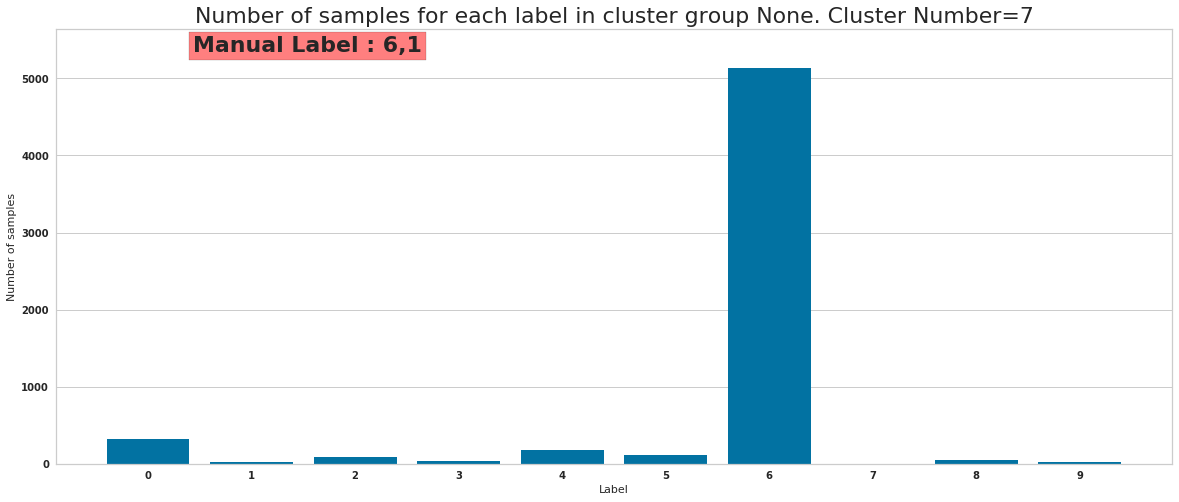

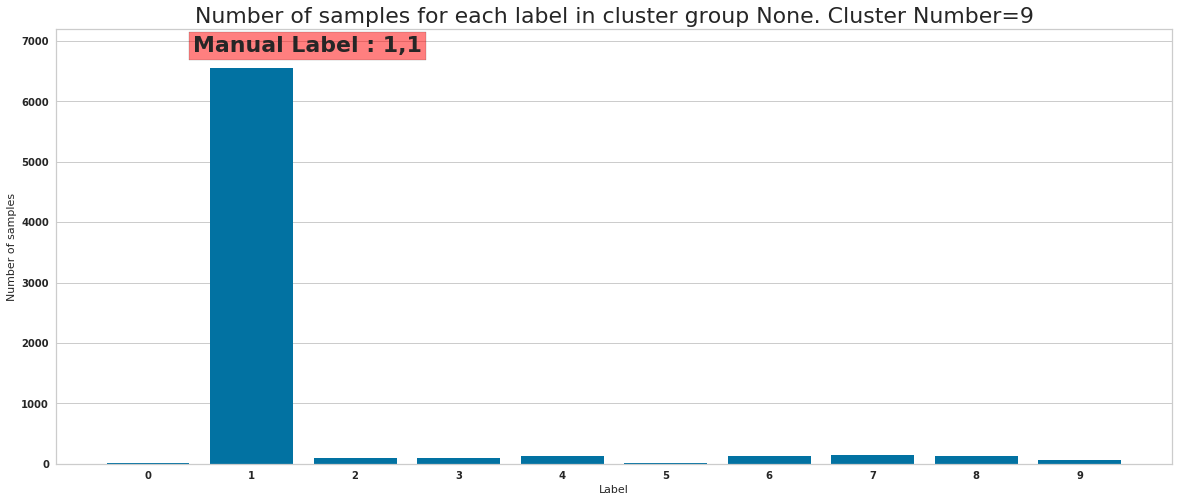

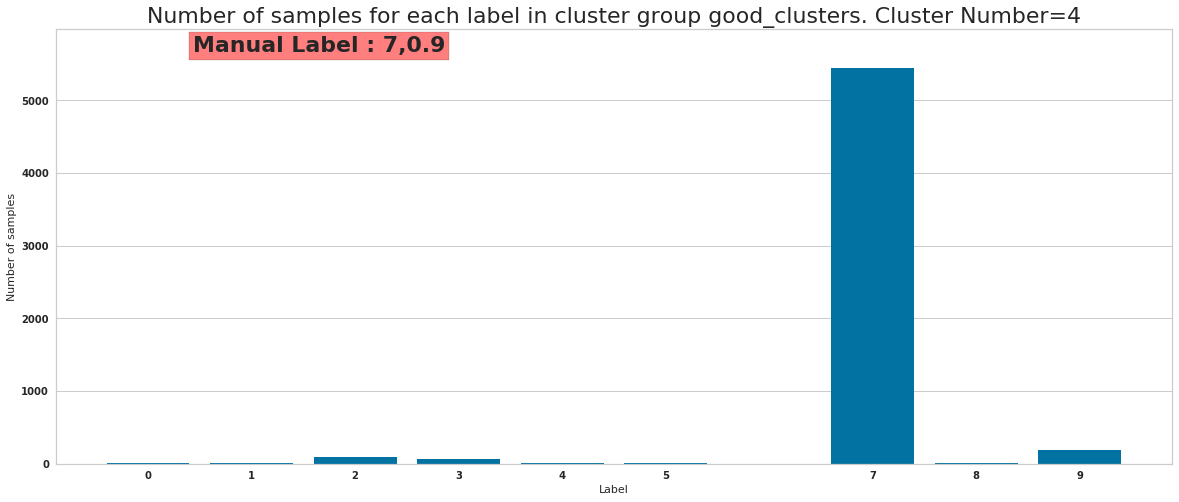

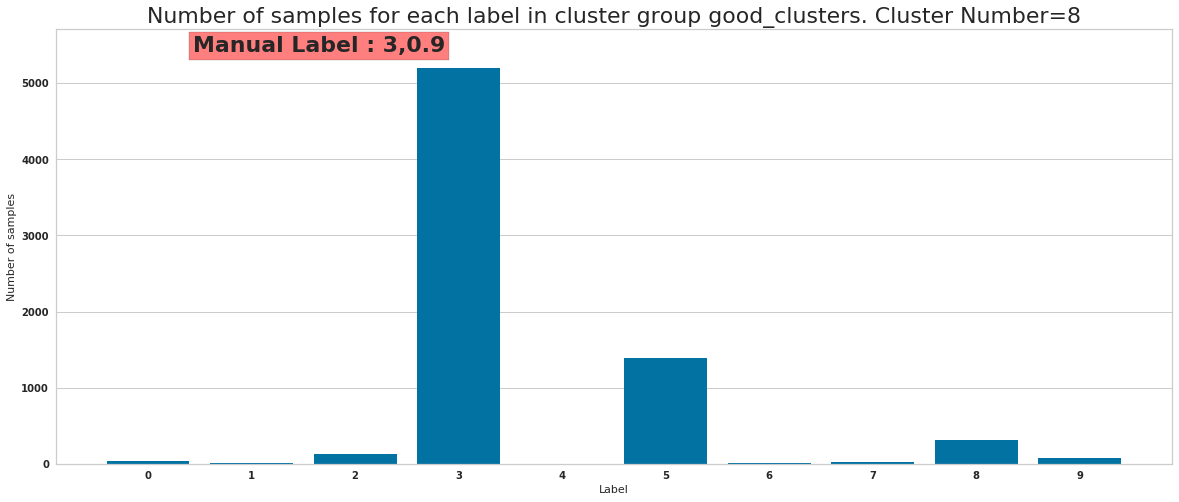

In [84]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [85]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5313, 10)
(3587, 10)
(5902, 10)
(6389, 10)
(5840, 10)
(5833, 10)
(6451, 10)
(5964, 10)
(7198, 10)
(7363, 10)


In [86]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [87]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 4
(5313, 47) (5313, 44)
Num correct=5053
Cluster 0 Manual Label 4 Percentage correct 95.10634293242988
********************************
Manual Label 5
(3587, 47) (3587, 44)
Num correct=3082
Cluster 1 Manual Label 5 Percentage correct 85.92138277111792
********************************
Manual Label 2
(5902, 47) (5902, 44)
Num correct=5114
Cluster 2 Manual Label 2 Percentage correct 86.64859369705185
********************************
Manual Label 8
(6389, 47) (6389, 44)
Num correct=4881
Cluster 3 Manual Label 8 Percentage correct 76.39693222726561
********************************
Manual Label 7
(5840, 47) (5840, 44)
Num correct=5441
Cluster 4 Manual Label 7 Percentage correct 93.16780821917808
********************************
Manual Label 0
(5833, 47) (5833, 44)
Num correct=5361
Cluster 5 Manual Label 0 Percentage correct 91.908109034802
********************************
Manual Label 9
(6451, 47) (6451, 44)
Num correct=5353
Cluster 6 Manual Label 9 Percentage correct 82.9793830

In [88]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [89]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

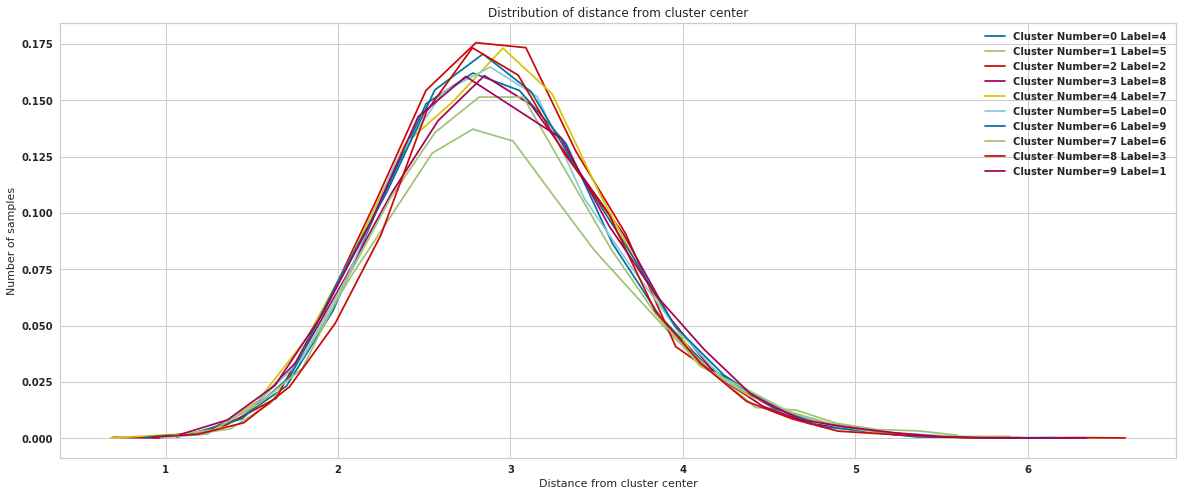

In [90]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

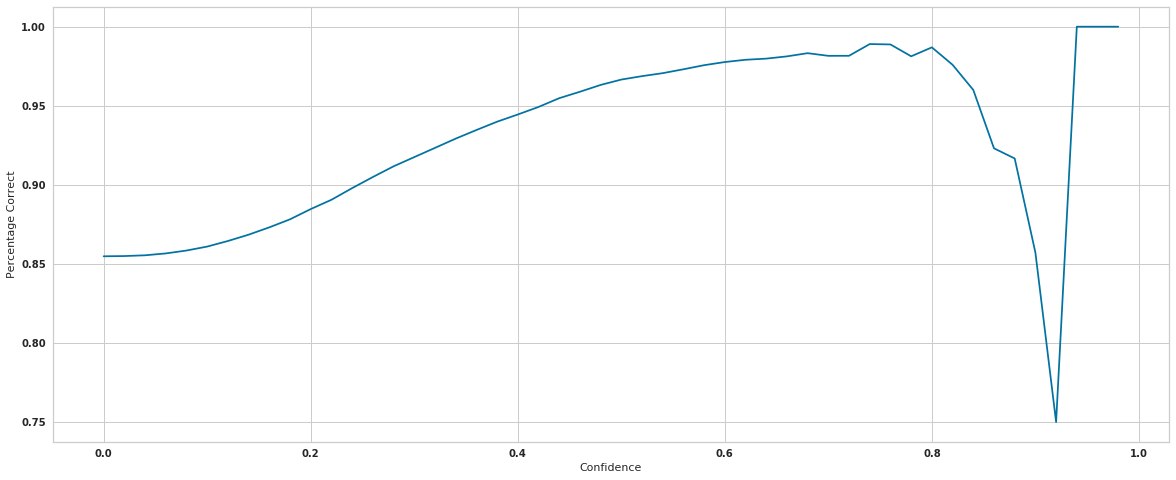

In [91]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

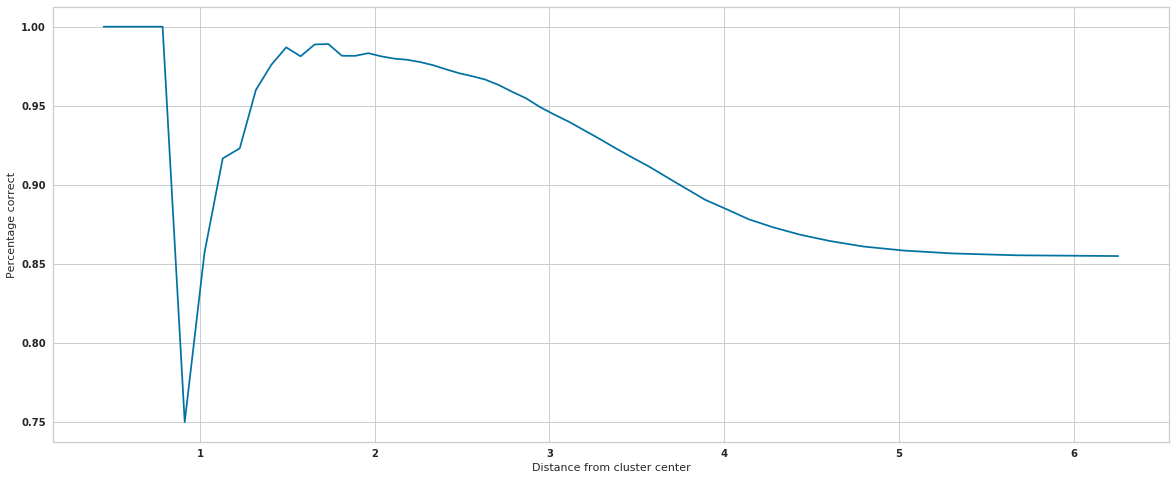

In [92]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

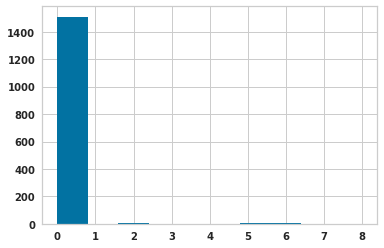

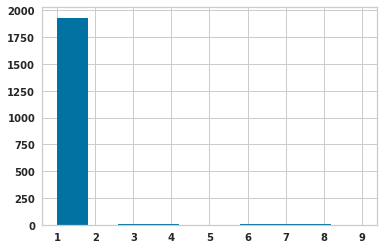

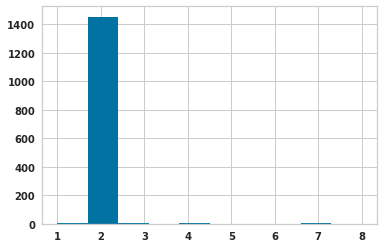

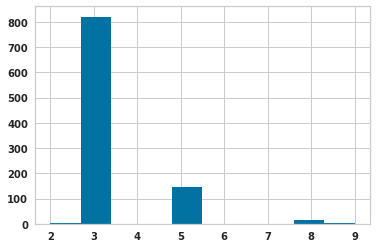

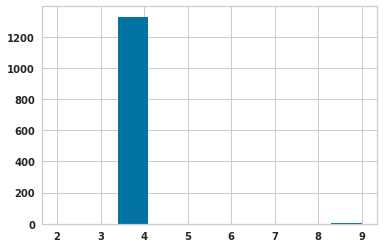

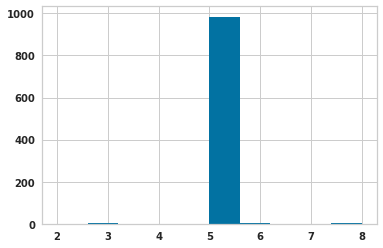

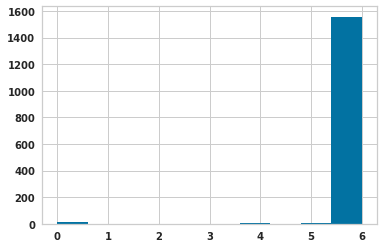

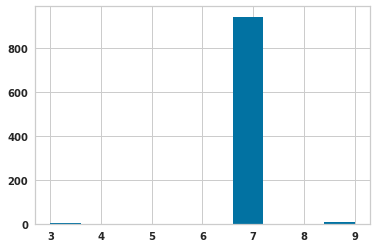

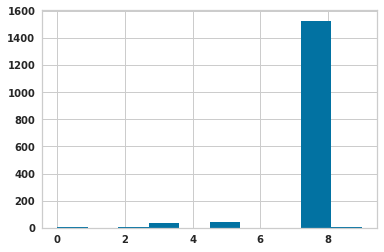

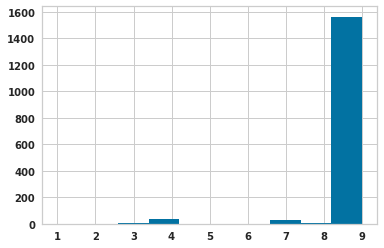

In [93]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [94]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23422.507030117904
INFO:tensorflow:Summary name Negative Log Like

Epoch: 3/65, Nll_loss : 120.70558166503906 KLD:10.558736801147461  Supervised loss:0.10905541479587555
Epoch: 3/66, Nll_loss : 110.04662322998047 KLD:9.82337760925293  Supervised loss:0.07324285805225372
Epoch: 3/67, Nll_loss : 106.93768310546875 KLD:9.637819290161133  Supervised loss:0.11107651889324188
Epoch: 3/68, Nll_loss : 120.81559753417969 KLD:9.9501953125  Supervised loss:0.13887658715248108
Epoch: 3/69, Nll_loss : 123.663818359375 KLD:9.933305740356445  Supervised loss:0.11368154734373093
Epoch: 3/70, Nll_loss : 116.49637603759766 KLD:9.86634635925293  Supervised loss:0.10461056232452393
Epoch: 3/71, Nll_loss : 116.55583190917969 KLD:9.558554649353027  Supervised loss:0.08553117513656616
Epoch: 3/72, Nll_loss : 119.24623107910156 KLD:9.261504173278809  Supervised loss:0.14273381233215332
Epoch: 3/73, Nll_loss : 121.62846374511719 KLD:9.370667457580566  Supervised loss:0.11556263267993927
Epoch: 3/74, Nll_loss : 124.13531494140625 KLD:9.814573287963867  Supervised loss:0.092928

Epoch: 3/146, Nll_loss : 112.46612548828125 KLD:9.761972427368164  Supervised loss:0.078936368227005
Epoch: 3/147, Nll_loss : 121.52586364746094 KLD:9.755175590515137  Supervised loss:0.0902995765209198
Epoch: 3/148, Nll_loss : 127.77363586425781 KLD:9.38682746887207  Supervised loss:0.12035460770130157
Epoch: 3/149, Nll_loss : 115.34452056884766 KLD:9.24912166595459  Supervised loss:0.11279614269733429
Epoch: 3/150, Nll_loss : 123.30300903320312 KLD:9.713659286499023  Supervised loss:0.1425856351852417
Epoch: 3/151, Nll_loss : 116.32164764404297 KLD:9.598295211791992  Supervised loss:0.08752426505088806
Epoch: 3/152, Nll_loss : 119.51141357421875 KLD:9.635720252990723  Supervised loss:0.10745465755462646
Epoch: 3/153, Nll_loss : 114.49455261230469 KLD:9.906044960021973  Supervised loss:0.059165794402360916
Epoch: 3/154, Nll_loss : 121.14495849609375 KLD:9.907418251037598  Supervised loss:0.12733498215675354
Epoch: 3/155, Nll_loss : 126.8497543334961 KLD:10.07661247253418  Supervised l

Epoch: 3/227, Nll_loss : 117.41920471191406 KLD:9.549285888671875  Supervised loss:0.13987313210964203
Epoch: 3/228, Nll_loss : 119.56169128417969 KLD:9.933145523071289  Supervised loss:0.15848881006240845
Epoch: 3/229, Nll_loss : 117.88774108886719 KLD:10.105661392211914  Supervised loss:0.06309399008750916
Epoch: 3/230, Nll_loss : 121.13926696777344 KLD:9.599308967590332  Supervised loss:0.11374454200267792
Epoch: 3/231, Nll_loss : 119.2567367553711 KLD:9.825979232788086  Supervised loss:0.1228165253996849
Epoch: 3/232, Nll_loss : 114.86580657958984 KLD:9.613279342651367  Supervised loss:0.08743703365325928
Epoch: 3/233, Nll_loss : 118.34422302246094 KLD:9.970459938049316  Supervised loss:0.10531756281852722
Epoch: 3/234, Nll_loss : 117.35603332519531 KLD:9.52578353881836  Supervised loss:0.1245984360575676
Epoch: 3/235, Nll_loss : 119.75413513183594 KLD:9.439462661743164  Supervised loss:0.08084879070520401
Epoch: 3/236, Nll_loss : 116.34736633300781 KLD:9.638343811035156  Supervise

Epoch: 3/310, Nll_loss : 123.8010482788086 KLD:10.078292846679688  Supervised loss:0.07801821827888489
Epoch: 3/311, Nll_loss : 125.297119140625 KLD:10.018463134765625  Supervised loss:0.10577253252267838
Epoch: 3/312, Nll_loss : 120.67092895507812 KLD:10.089775085449219  Supervised loss:0.08518645167350769
Epoch: 3/313, Nll_loss : 122.03688049316406 KLD:9.72453498840332  Supervised loss:0.10627852380275726
Epoch: 3/314, Nll_loss : 110.39933776855469 KLD:9.629180908203125  Supervised loss:0.09195595234632492
Epoch: 3/315, Nll_loss : 112.44988250732422 KLD:9.878923416137695  Supervised loss:0.09952705353498459
Epoch: 3/316, Nll_loss : 116.66485595703125 KLD:9.868002891540527  Supervised loss:0.09527559578418732
Epoch: 3/317, Nll_loss : 116.95561981201172 KLD:9.763501167297363  Supervised loss:0.09815870225429535
Epoch: 3/318, Nll_loss : 111.36628723144531 KLD:9.746683120727539  Supervised loss:0.11489097774028778
Epoch: 3/319, Nll_loss : 116.95855712890625 KLD:9.918970108032227  Supervi

Epoch: 3/390, Nll_loss : 122.61529541015625 KLD:9.312567710876465  Supervised loss:0.07480249553918839
Epoch: 3/391, Nll_loss : 115.61647033691406 KLD:9.172601699829102  Supervised loss:0.12477610260248184
Epoch: 3/392, Nll_loss : 115.65835571289062 KLD:9.392129898071289  Supervised loss:0.11431296169757843
Epoch: 3/393, Nll_loss : 123.27011108398438 KLD:9.823381423950195  Supervised loss:0.08578214794397354
Epoch: 3/394, Nll_loss : 115.66659545898438 KLD:9.989561080932617  Supervised loss:0.10404470562934875
Epoch: 3/395, Nll_loss : 119.55487060546875 KLD:9.950117111206055  Supervised loss:0.17019367218017578
Epoch: 3/396, Nll_loss : 111.1841812133789 KLD:10.707756042480469  Supervised loss:0.09549298882484436
Epoch: 3/397, Nll_loss : 108.19499206542969 KLD:10.079995155334473  Supervised loss:0.11296255141496658
Epoch: 3/398, Nll_loss : 121.69572448730469 KLD:10.754179000854492  Supervised loss:0.10921816527843475
Epoch: 3/399, Nll_loss : 121.06748962402344 KLD:10.423373222351074  Sup

Epoch: 3/471, Nll_loss : 113.64054107666016 KLD:9.978311538696289  Supervised loss:0.09269879758358002
Epoch: 3/472, Nll_loss : 118.83253479003906 KLD:9.817892074584961  Supervised loss:0.07257618755102158
Epoch: 3/473, Nll_loss : 113.08704376220703 KLD:9.706611633300781  Supervised loss:0.14340481162071228
Epoch: 3/474, Nll_loss : 114.01828002929688 KLD:9.283397674560547  Supervised loss:0.06845835596323013
Epoch: 3/475, Nll_loss : 119.68058776855469 KLD:9.42536735534668  Supervised loss:0.12242017686367035
Epoch: 3/476, Nll_loss : 115.40458679199219 KLD:9.599858283996582  Supervised loss:0.061201710253953934
Epoch: 3/477, Nll_loss : 120.9285888671875 KLD:9.48972225189209  Supervised loss:0.11961762607097626
Epoch: 3/478, Nll_loss : 115.0428466796875 KLD:9.291237831115723  Supervised loss:0.11011431366205215
Epoch: 3/479, Nll_loss : 123.15087890625 KLD:9.756074905395508  Supervised loss:0.10854082554578781
Epoch: 3/480, Nll_loss : 114.749755859375 KLD:9.713420867919922  Supervised los

Epoch: 3/552, Nll_loss : 109.00994873046875 KLD:9.344160079956055  Supervised loss:0.08768990635871887
Epoch: 3/553, Nll_loss : 118.25160217285156 KLD:9.67689323425293  Supervised loss:0.10856503248214722
Epoch: 3/554, Nll_loss : 118.44711303710938 KLD:9.491787910461426  Supervised loss:0.12383514642715454
Epoch: 3/555, Nll_loss : 121.06976318359375 KLD:10.021865844726562  Supervised loss:0.10440756380558014
Epoch: 3/556, Nll_loss : 122.0283203125 KLD:10.135574340820312  Supervised loss:0.14930449426174164
Epoch: 3/557, Nll_loss : 116.02044677734375 KLD:10.064327239990234  Supervised loss:0.055334821343421936
Epoch: 3/558, Nll_loss : 115.67045593261719 KLD:9.745254516601562  Supervised loss:0.09755241870880127
Epoch: 3/559, Nll_loss : 115.86213684082031 KLD:10.011265754699707  Supervised loss:0.08384822309017181
Epoch: 3/560, Nll_loss : 108.97869873046875 KLD:9.672977447509766  Supervised loss:0.09242267906665802
Epoch: 3/561, Nll_loss : 111.07832336425781 KLD:9.713550567626953  Superv

Epoch: 3/632, Nll_loss : 110.51678466796875 KLD:9.429140090942383  Supervised loss:0.06391160190105438
Epoch: 3/633, Nll_loss : 115.27616119384766 KLD:9.16983699798584  Supervised loss:0.08240632712841034
Epoch: 3/634, Nll_loss : 115.16767883300781 KLD:9.285072326660156  Supervised loss:0.13038773834705353
Epoch: 3/635, Nll_loss : 121.71111297607422 KLD:9.569395065307617  Supervised loss:0.11505308747291565
Epoch: 3/636, Nll_loss : 114.68310546875 KLD:9.680408477783203  Supervised loss:0.09310008585453033
Epoch: 3/637, Nll_loss : 110.66886901855469 KLD:9.47467041015625  Supervised loss:0.10272620618343353
Epoch: 3/638, Nll_loss : 117.97550201416016 KLD:9.705289840698242  Supervised loss:0.10504967719316483
Epoch: 3/639, Nll_loss : 124.81382751464844 KLD:10.117835998535156  Supervised loss:0.1310192495584488
Epoch: 3/640, Nll_loss : 113.27955627441406 KLD:9.910149574279785  Supervised loss:0.0999709963798523
Epoch: 3/641, Nll_loss : 114.34095764160156 KLD:9.68043327331543  Supervised lo

Epoch: 3/712, Nll_loss : 121.04886627197266 KLD:9.611324310302734  Supervised loss:0.15439173579216003
Epoch: 3/713, Nll_loss : 119.51870727539062 KLD:9.413308143615723  Supervised loss:0.10757103562355042
Epoch: 3/714, Nll_loss : 115.01104736328125 KLD:10.208648681640625  Supervised loss:0.07113834470510483
Epoch: 3/715, Nll_loss : 115.21365356445312 KLD:9.671876907348633  Supervised loss:0.11554349958896637
Epoch: 3/716, Nll_loss : 111.68832397460938 KLD:9.957293510437012  Supervised loss:0.07632452249526978
Epoch: 3/717, Nll_loss : 119.26496887207031 KLD:10.442492485046387  Supervised loss:0.10051272809505463
Epoch: 3/718, Nll_loss : 110.35487365722656 KLD:9.668192863464355  Supervised loss:0.07934102416038513
Epoch: 3/719, Nll_loss : 115.98794555664062 KLD:9.61215591430664  Supervised loss:0.15892758965492249
Epoch: 3/720, Nll_loss : 114.71202087402344 KLD:9.822784423828125  Supervised loss:0.0912168025970459
Epoch: 3/721, Nll_loss : 113.15684509277344 KLD:9.621431350708008  Superv

Epoch: 3/793, Nll_loss : 112.65043640136719 KLD:9.468343734741211  Supervised loss:0.10000509023666382
Epoch: 3/794, Nll_loss : 117.63152313232422 KLD:10.347675323486328  Supervised loss:0.05566653609275818
Epoch: 3/795, Nll_loss : 114.02678680419922 KLD:10.102909088134766  Supervised loss:0.10691753029823303
Epoch: 3/796, Nll_loss : 121.48835754394531 KLD:10.266373634338379  Supervised loss:0.0815780982375145
Epoch: 3/797, Nll_loss : 116.77197265625 KLD:9.959725379943848  Supervised loss:0.09953896701335907
Epoch: 3/798, Nll_loss : 121.22221374511719 KLD:9.424140930175781  Supervised loss:0.13174322247505188
Epoch: 3/799, Nll_loss : 123.771728515625 KLD:10.124298095703125  Supervised loss:0.08570460975170135
Epoch: 3/800, Nll_loss : 116.62898254394531 KLD:9.8267240524292  Supervised loss:0.09976735711097717
Epoch: 3/801, Nll_loss : 110.35700225830078 KLD:9.469053268432617  Supervised loss:0.10111892223358154
Epoch: 3/802, Nll_loss : 110.74411010742188 KLD:9.704504013061523  Supervised

Epoch: 3/873, Nll_loss : 118.82929229736328 KLD:9.554306030273438  Supervised loss:0.09637394547462463
Epoch: 3/874, Nll_loss : 118.87260437011719 KLD:9.625515937805176  Supervised loss:0.11358240991830826
Epoch: 3/875, Nll_loss : 114.77934265136719 KLD:9.551780700683594  Supervised loss:0.08421480655670166
Epoch: 3/876, Nll_loss : 113.00898742675781 KLD:9.360400199890137  Supervised loss:0.08633029460906982
Epoch: 3/877, Nll_loss : 119.4896469116211 KLD:9.74477767944336  Supervised loss:0.09998978674411774
Epoch: 3/878, Nll_loss : 126.62141418457031 KLD:9.7662935256958  Supervised loss:0.12993699312210083
Epoch: 3/879, Nll_loss : 112.11932373046875 KLD:9.818926811218262  Supervised loss:0.07543178647756577
Epoch: 3/880, Nll_loss : 112.89396667480469 KLD:9.584291458129883  Supervised loss:0.1420832723379135
Epoch: 3/881, Nll_loss : 117.15992736816406 KLD:10.156579971313477  Supervised loss:0.10605843365192413
Epoch: 3/882, Nll_loss : 114.85441589355469 KLD:10.11894702911377  Supervised

In [95]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=45 z_min=-4.5359225 z_max=4.6136669999999995
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is il

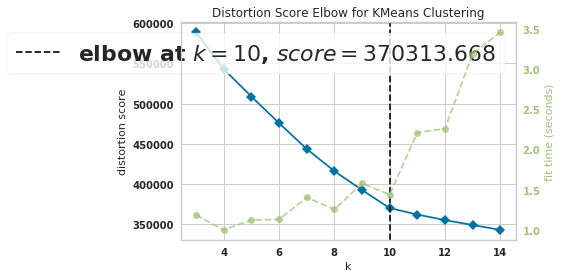

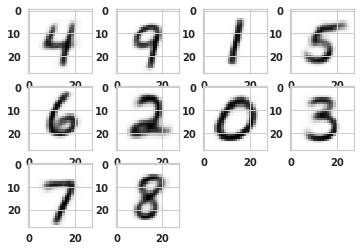

In [96]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [97]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [4, 9, 1, 5,
                                           6, 2, 1, 3,
                                           7, 8
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 1, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


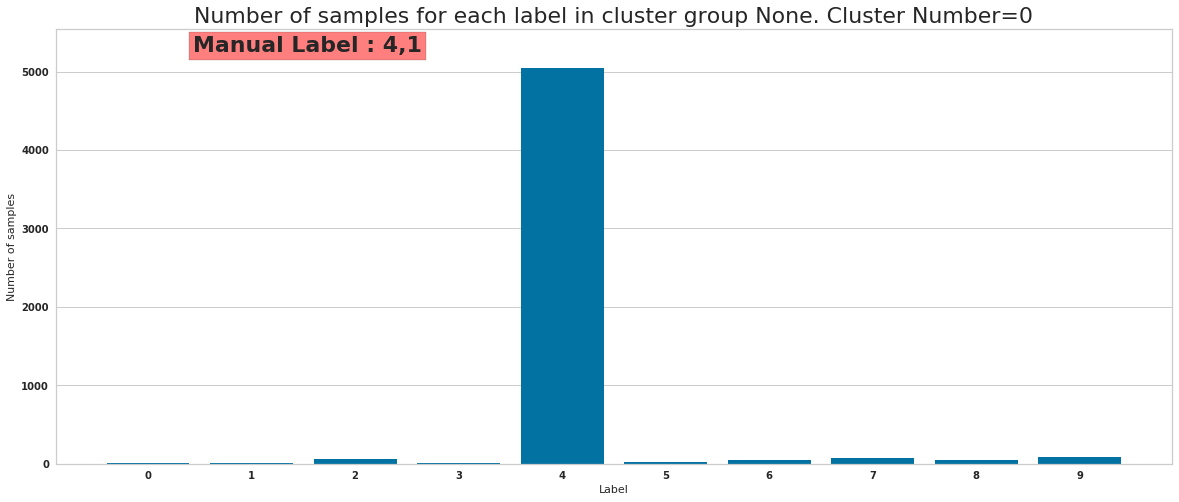

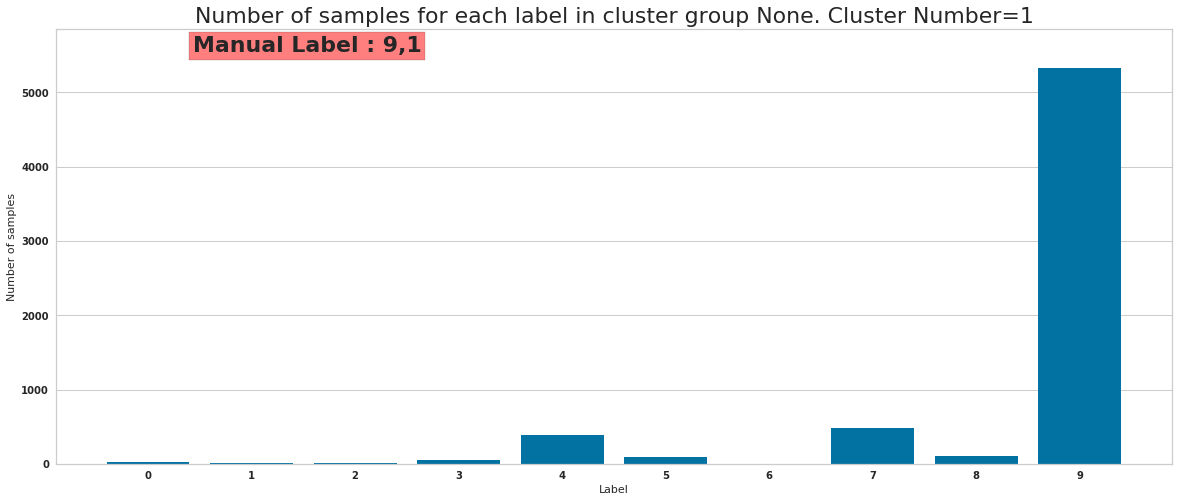

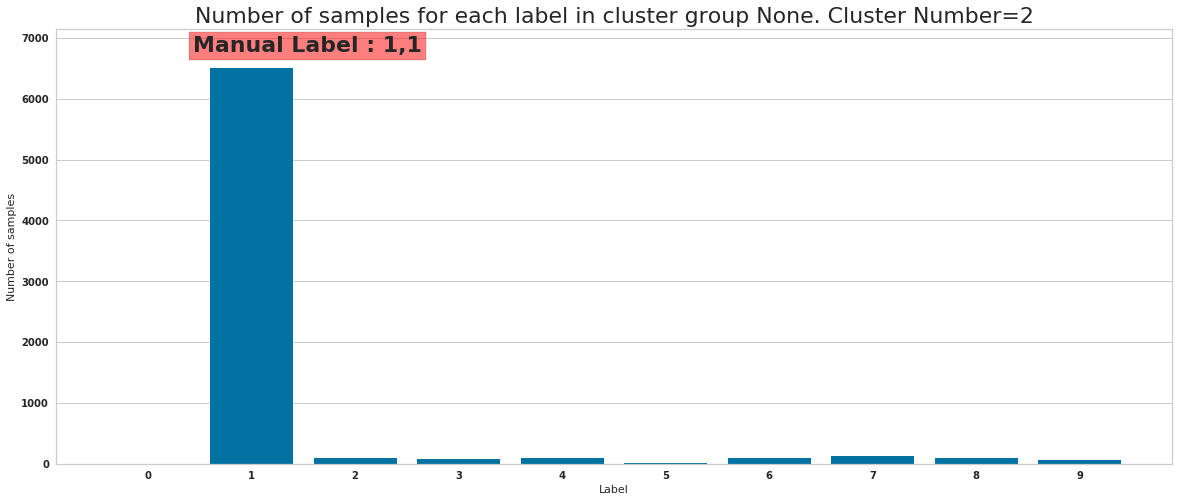

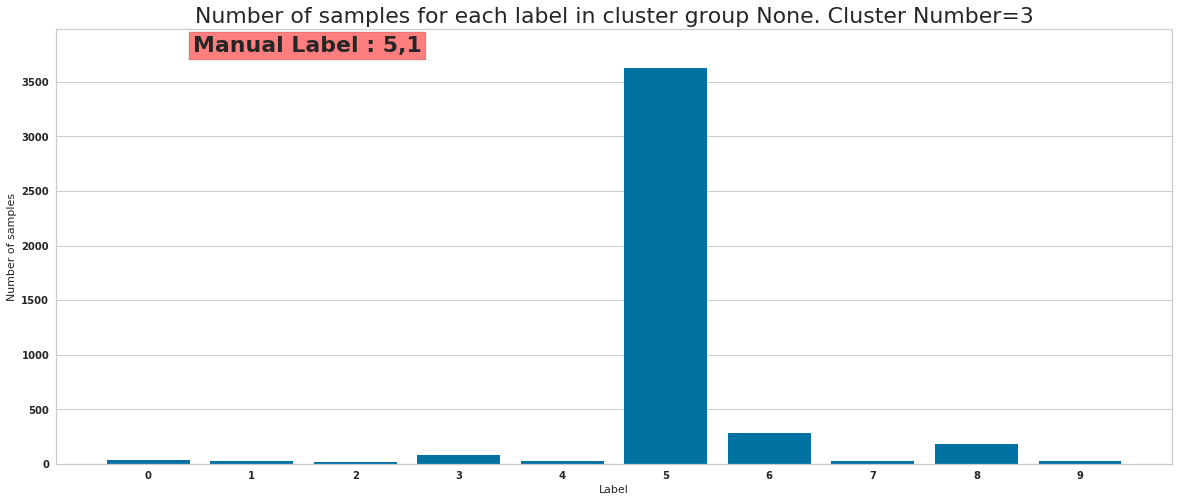

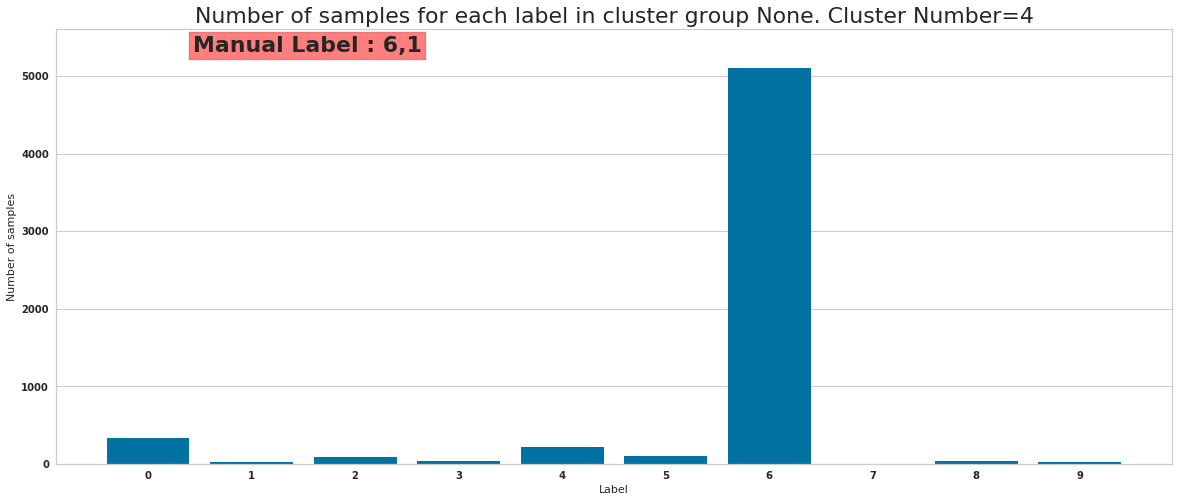

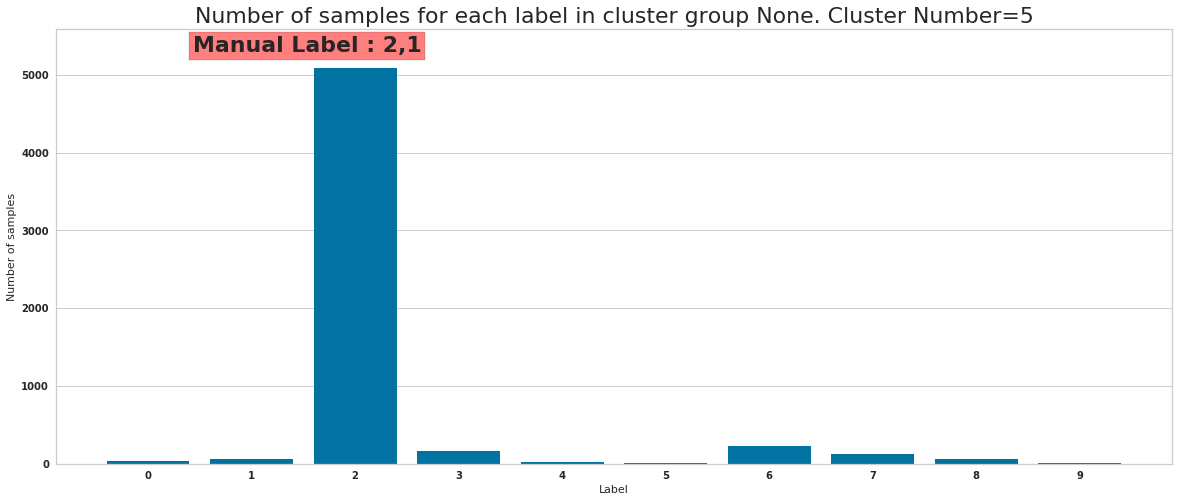

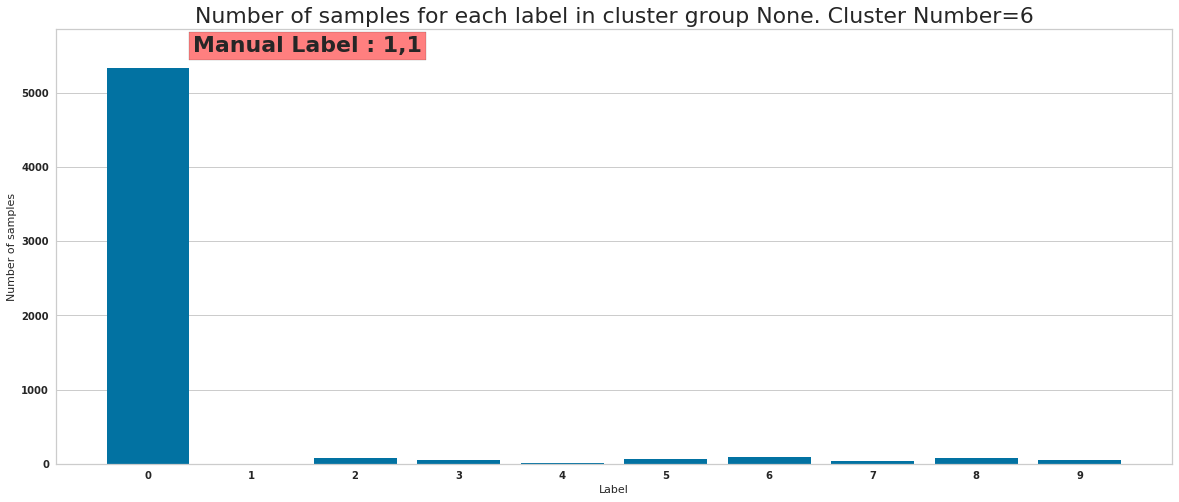

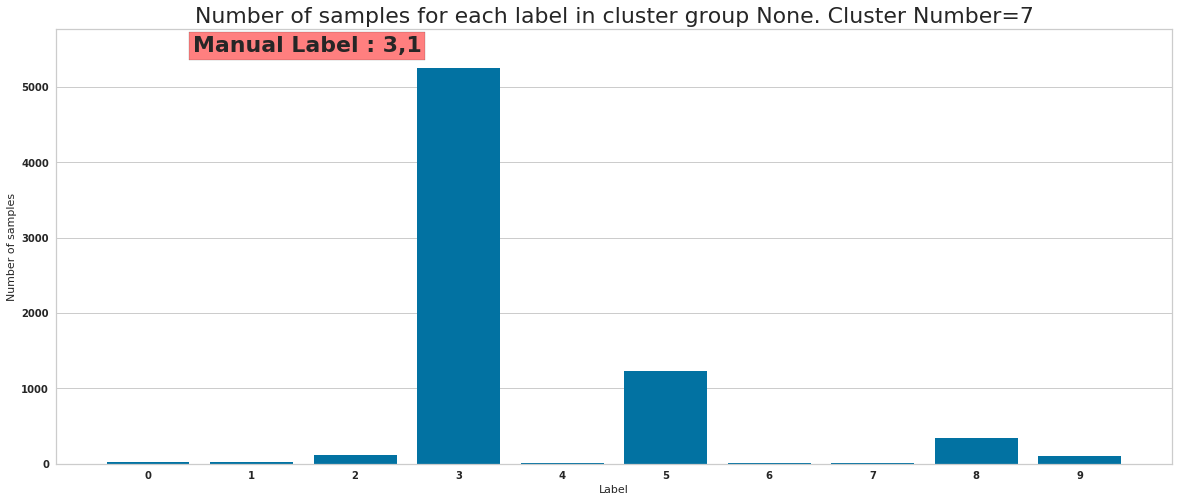

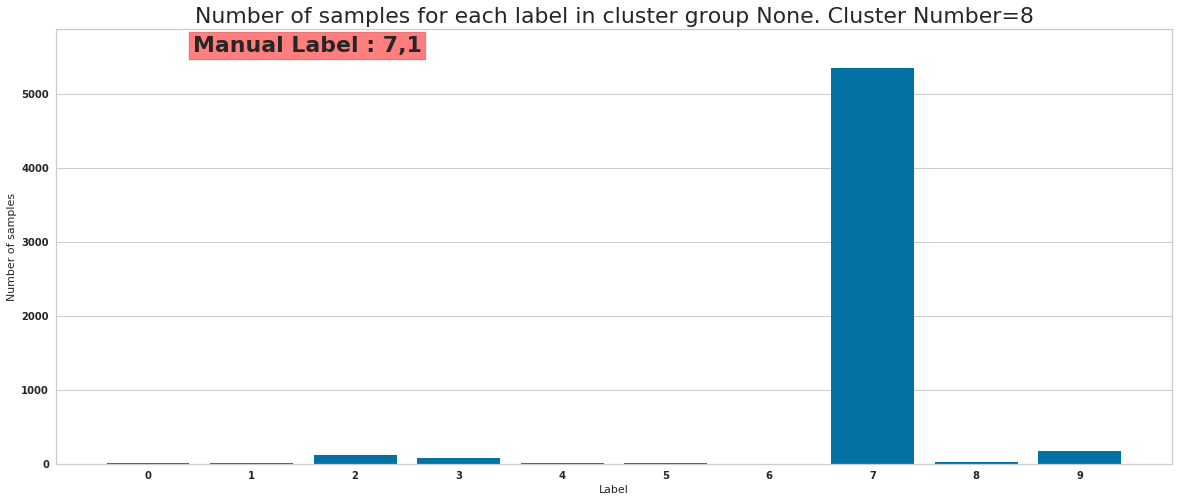

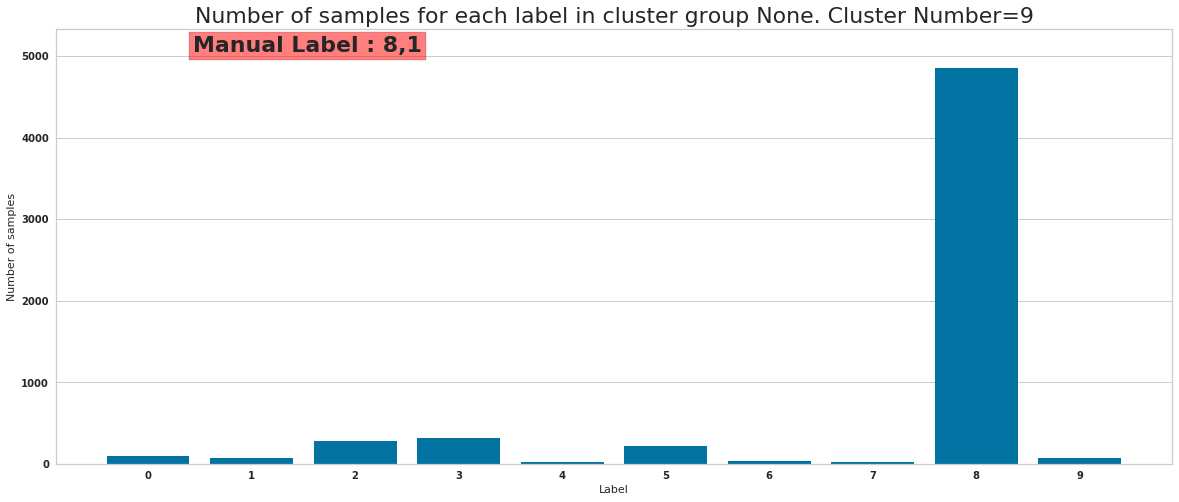

In [98]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [99]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(5407, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6516, 10)
(7183, 10)
(4317, 10)
(5970, 10)
(5805, 10)
(5778, 10)
(7123, 10)
(5768, 10)
(5973, 10)


In [100]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [101]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 4
(5407, 47) (5407, 33)
Num correct=5039
Cluster 0 Manual Label 4 Percentage correct 93.19400776770853
********************************
Manual Label 9
(6516, 47) (6516, 33)
Num correct=5323
Cluster 1 Manual Label 9 Percentage correct 81.69122160834868
********************************
Manual Label 1
(7183, 47) (7183, 33)
Num correct=6496
Cluster 2 Manual Label 1 Percentage correct 90.43575107893638
********************************
Manual Label 5
(4317, 47) (4317, 33)
Num correct=3623
Cluster 3 Manual Label 5 Percentage correct 83.92402131109567
********************************
Manual Label 6
(5970, 47) (5970, 33)
Num correct=5099
Cluster 4 Manual Label 6 Percentage correct 85.4103852596315
********************************
Manual Label 2
(5805, 47) (5805, 33)
Num correct=5082
Cluster 5 Manual Label 2 Percentage correct 87.5452196382429
********************************
Manual Label 1
(12961, 47) (5778, 33)
Num correct=6497
Cluster 6 Manual Label 1 Percentage correct 50.127304

In [102]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

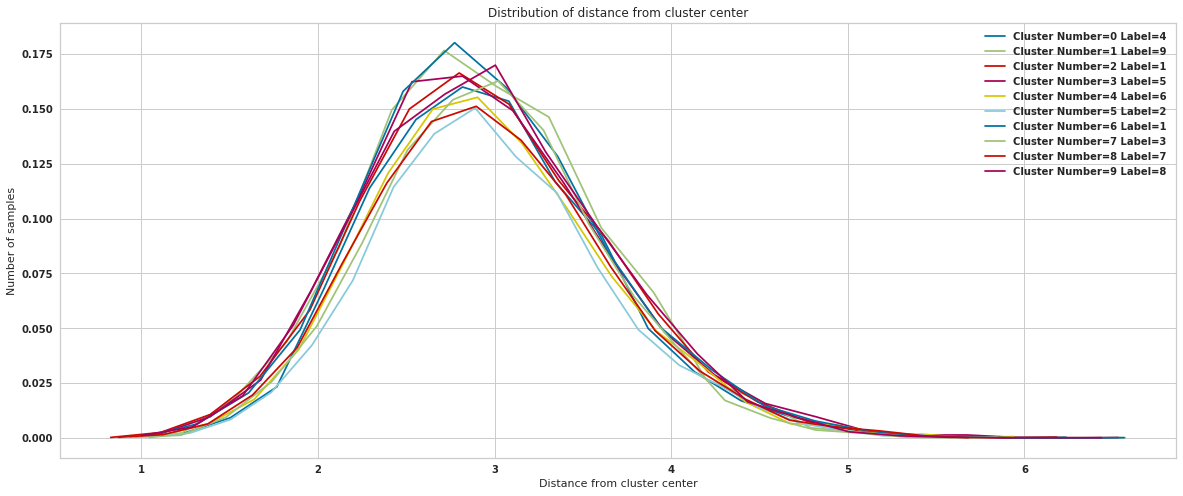

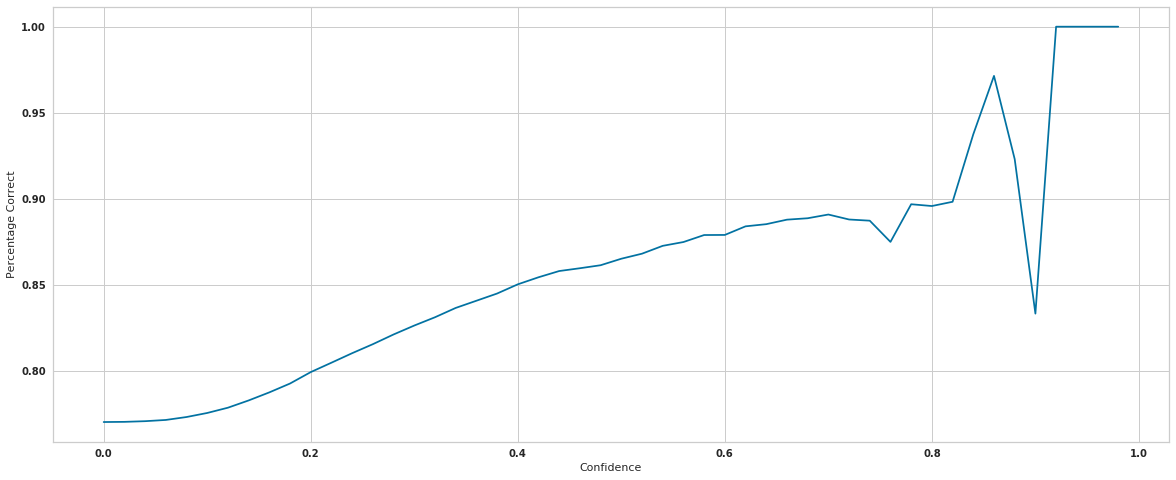

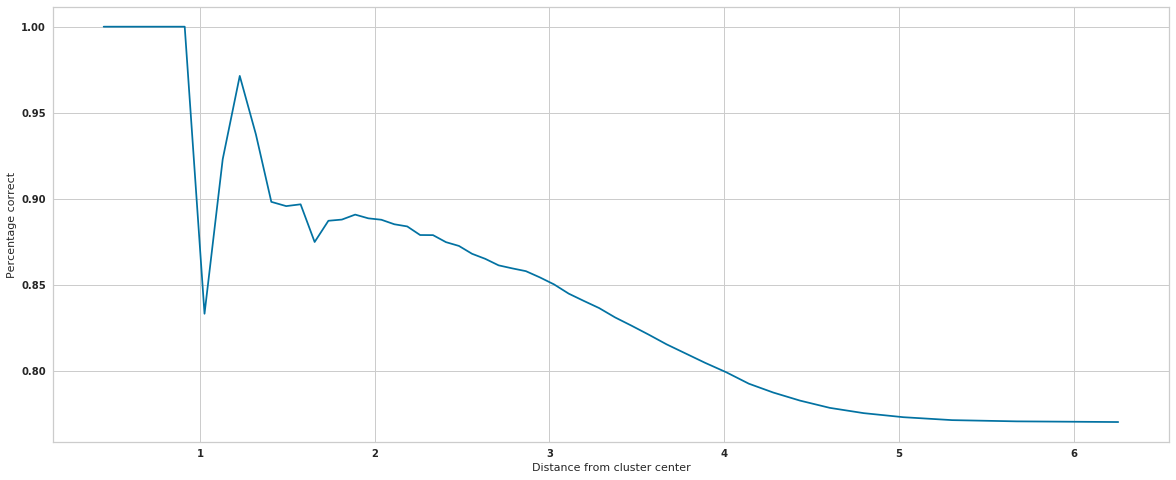

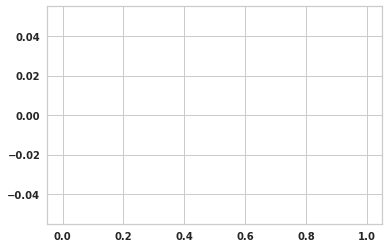

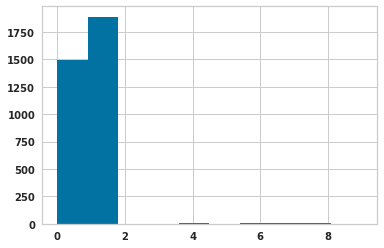

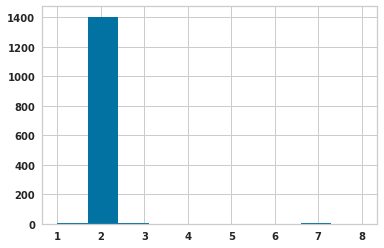

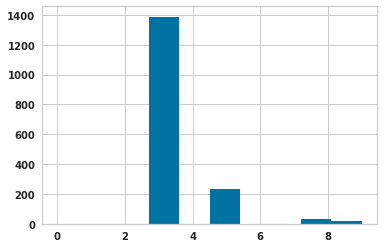

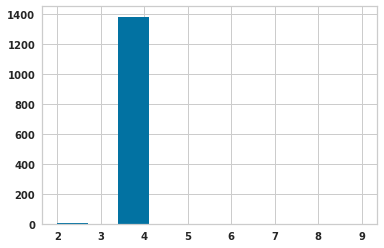

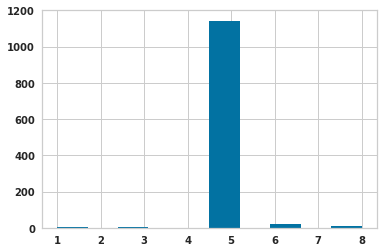

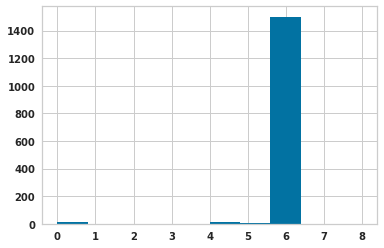

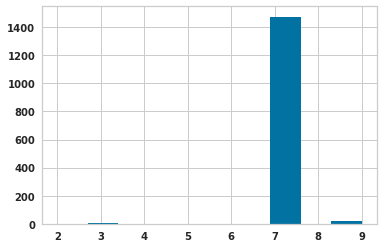

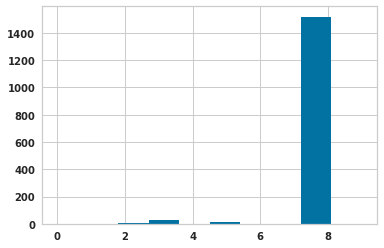

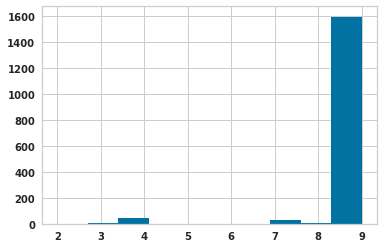

In [103]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [104]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23939.197292811605
INFO:tensorflow:Summary name Negative Log Like

Epoch: 4/64, Nll_loss : 117.55591583251953 KLD:9.850467681884766  Supervised loss:0.10921051353216171
Epoch: 4/65, Nll_loss : 123.5235595703125 KLD:10.183639526367188  Supervised loss:0.17645911872386932
Epoch: 4/66, Nll_loss : 108.76678466796875 KLD:9.86107349395752  Supervised loss:0.11448055505752563
Epoch: 4/67, Nll_loss : 110.73753356933594 KLD:9.713369369506836  Supervised loss:0.11630797386169434
Epoch: 4/68, Nll_loss : 119.89198303222656 KLD:10.247596740722656  Supervised loss:0.08572018146514893
Epoch: 4/69, Nll_loss : 123.88671112060547 KLD:10.48245620727539  Supervised loss:0.10831890255212784
Epoch: 4/70, Nll_loss : 117.20172882080078 KLD:10.61111831665039  Supervised loss:0.11022333055734634
Epoch: 4/71, Nll_loss : 112.68084716796875 KLD:10.331329345703125  Supervised loss:0.1314067244529724
Epoch: 4/72, Nll_loss : 119.60821533203125 KLD:10.072986602783203  Supervised loss:0.10597854107618332
Epoch: 4/73, Nll_loss : 118.60224151611328 KLD:9.915719985961914  Supervised loss

Epoch: 4/147, Nll_loss : 123.85108184814453 KLD:10.187768936157227  Supervised loss:0.11657695472240448
Epoch: 4/148, Nll_loss : 124.78328704833984 KLD:9.91682243347168  Supervised loss:0.16198202967643738
Epoch: 4/149, Nll_loss : 115.35655212402344 KLD:9.865635871887207  Supervised loss:0.08265791833400726
Epoch: 4/150, Nll_loss : 120.37649536132812 KLD:10.234128952026367  Supervised loss:0.09529872238636017
Epoch: 4/151, Nll_loss : 115.90304565429688 KLD:10.025890350341797  Supervised loss:0.09700854867696762
Epoch: 4/152, Nll_loss : 117.33094787597656 KLD:10.08233642578125  Supervised loss:0.15044444799423218
Epoch: 4/153, Nll_loss : 112.57009887695312 KLD:10.192299842834473  Supervised loss:0.07911764085292816
Epoch: 4/154, Nll_loss : 122.82048034667969 KLD:10.204970359802246  Supervised loss:0.12146447598934174
Epoch: 4/155, Nll_loss : 124.14163208007812 KLD:10.422788619995117  Supervised loss:0.1280597299337387
Epoch: 4/156, Nll_loss : 116.36381530761719 KLD:9.994250297546387  Su

Epoch: 4/228, Nll_loss : 118.42901611328125 KLD:10.540779113769531  Supervised loss:0.14068220555782318
Epoch: 4/229, Nll_loss : 114.52978515625 KLD:10.503575325012207  Supervised loss:0.08727231621742249
Epoch: 4/230, Nll_loss : 122.0767822265625 KLD:9.767322540283203  Supervised loss:0.07283998280763626
Epoch: 4/231, Nll_loss : 120.54510498046875 KLD:9.810135841369629  Supervised loss:0.11854051798582077
Epoch: 4/232, Nll_loss : 117.87727355957031 KLD:9.823301315307617  Supervised loss:0.08319371938705444
Epoch: 4/233, Nll_loss : 121.46629333496094 KLD:9.978199005126953  Supervised loss:0.11289113759994507
Epoch: 4/234, Nll_loss : 117.9866714477539 KLD:9.585165023803711  Supervised loss:0.06542500853538513
Epoch: 4/235, Nll_loss : 117.14923095703125 KLD:9.945690155029297  Supervised loss:0.07616569101810455
Epoch: 4/236, Nll_loss : 115.74884796142578 KLD:10.12817096710205  Supervised loss:0.10204477608203888
Epoch: 4/237, Nll_loss : 123.36837005615234 KLD:9.883666038513184  Supervise

Epoch: 4/310, Nll_loss : 126.29559326171875 KLD:9.84821891784668  Supervised loss:0.10179175436496735
Epoch: 4/311, Nll_loss : 126.62024688720703 KLD:9.901086807250977  Supervised loss:0.10800404101610184
Epoch: 4/312, Nll_loss : 119.1215591430664 KLD:10.084020614624023  Supervised loss:0.08947332948446274
Epoch: 4/313, Nll_loss : 121.94854736328125 KLD:9.865377426147461  Supervised loss:0.07357810437679291
Epoch: 4/314, Nll_loss : 110.8443374633789 KLD:9.77376651763916  Supervised loss:0.11333128064870834
Epoch: 4/315, Nll_loss : 109.96981811523438 KLD:9.97031021118164  Supervised loss:0.09082046896219254
Epoch: 4/316, Nll_loss : 114.12342834472656 KLD:9.995231628417969  Supervised loss:0.12553325295448303
Epoch: 4/317, Nll_loss : 112.45467376708984 KLD:9.853998184204102  Supervised loss:0.1469733715057373
Epoch: 4/318, Nll_loss : 108.59959411621094 KLD:9.91767406463623  Supervised loss:0.10411256551742554
Epoch: 4/319, Nll_loss : 117.25393676757812 KLD:10.153421401977539  Supervised 

Epoch: 4/390, Nll_loss : 118.60000610351562 KLD:9.760038375854492  Supervised loss:0.08924931287765503
Epoch: 4/391, Nll_loss : 113.22088623046875 KLD:9.778661727905273  Supervised loss:0.11005385965108871
Epoch: 4/392, Nll_loss : 118.10371398925781 KLD:9.606136322021484  Supervised loss:0.07173293083906174
Epoch: 4/393, Nll_loss : 122.00770568847656 KLD:9.94836139678955  Supervised loss:0.10006243735551834
Epoch: 4/394, Nll_loss : 116.24518585205078 KLD:10.024481773376465  Supervised loss:0.1243152841925621
Epoch: 4/395, Nll_loss : 116.15361022949219 KLD:9.970418930053711  Supervised loss:0.17823690176010132
Epoch: 4/396, Nll_loss : 112.84171295166016 KLD:10.743692398071289  Supervised loss:0.08576709032058716
Epoch: 4/397, Nll_loss : 105.36449432373047 KLD:10.176225662231445  Supervised loss:0.07916247099637985
Epoch: 4/398, Nll_loss : 121.43011474609375 KLD:10.633456230163574  Supervised loss:0.0922054797410965
Epoch: 4/399, Nll_loss : 119.23530578613281 KLD:10.524515151977539  Supe

Epoch: 4/471, Nll_loss : 112.43972778320312 KLD:9.623482704162598  Supervised loss:0.08909882605075836
Epoch: 4/472, Nll_loss : 118.67472839355469 KLD:9.814149856567383  Supervised loss:0.06743021309375763
Epoch: 4/473, Nll_loss : 117.29840087890625 KLD:9.961551666259766  Supervised loss:0.13160648941993713
Epoch: 4/474, Nll_loss : 114.60501098632812 KLD:9.89977741241455  Supervised loss:0.11765418946743011
Epoch: 4/475, Nll_loss : 116.06724548339844 KLD:10.069341659545898  Supervised loss:0.1105680912733078
Epoch: 4/476, Nll_loss : 112.64955139160156 KLD:10.558216094970703  Supervised loss:0.08431988954544067
Epoch: 4/477, Nll_loss : 114.28211975097656 KLD:10.120731353759766  Supervised loss:0.09282928705215454
Epoch: 4/478, Nll_loss : 116.8700180053711 KLD:9.883734703063965  Supervised loss:0.08589555323123932
Epoch: 4/479, Nll_loss : 120.14047241210938 KLD:10.094857215881348  Supervised loss:0.08874044567346573
Epoch: 4/480, Nll_loss : 115.43363189697266 KLD:9.669748306274414  Super

Epoch: 4/552, Nll_loss : 110.16191101074219 KLD:9.490568161010742  Supervised loss:0.08724236488342285
Epoch: 4/553, Nll_loss : 117.70780944824219 KLD:10.09443473815918  Supervised loss:0.1614164113998413
Epoch: 4/554, Nll_loss : 117.37461853027344 KLD:9.77868938446045  Supervised loss:0.11617068946361542
Epoch: 4/555, Nll_loss : 120.22332000732422 KLD:10.274680137634277  Supervised loss:0.11901053786277771
Epoch: 4/556, Nll_loss : 124.41078186035156 KLD:10.144453048706055  Supervised loss:0.1255715787410736
Epoch: 4/557, Nll_loss : 116.6144027709961 KLD:10.17874526977539  Supervised loss:0.08089178800582886
Epoch: 4/558, Nll_loss : 117.34312438964844 KLD:9.884531021118164  Supervised loss:0.10069301724433899
Epoch: 4/559, Nll_loss : 115.81230163574219 KLD:10.312278747558594  Supervised loss:0.07726409286260605
Epoch: 4/560, Nll_loss : 110.68728637695312 KLD:9.833465576171875  Supervised loss:0.13825753331184387
Epoch: 4/561, Nll_loss : 112.58193969726562 KLD:9.779589653015137  Supervi

Epoch: 4/632, Nll_loss : 111.31047058105469 KLD:9.297929763793945  Supervised loss:0.07776698470115662
Epoch: 4/633, Nll_loss : 116.05558013916016 KLD:9.20011043548584  Supervised loss:0.1453528106212616
Epoch: 4/634, Nll_loss : 116.53569030761719 KLD:9.415350914001465  Supervised loss:0.08432680368423462
Epoch: 4/635, Nll_loss : 118.53886413574219 KLD:9.762826919555664  Supervised loss:0.1515173763036728
Epoch: 4/636, Nll_loss : 114.4674301147461 KLD:10.013187408447266  Supervised loss:0.09412074834108353
Epoch: 4/637, Nll_loss : 109.43620300292969 KLD:9.932794570922852  Supervised loss:0.06783858686685562
Epoch: 4/638, Nll_loss : 113.80976867675781 KLD:10.013309478759766  Supervised loss:0.09835866838693619
Epoch: 4/639, Nll_loss : 123.6827392578125 KLD:10.454257011413574  Supervised loss:0.13646546006202698
Epoch: 4/640, Nll_loss : 113.73664855957031 KLD:10.180595397949219  Supervised loss:0.1139383390545845
Epoch: 4/641, Nll_loss : 114.37039184570312 KLD:10.358421325683594  Supervi

Epoch: 4/714, Nll_loss : 108.7601318359375 KLD:10.590333938598633  Supervised loss:0.07092148065567017
Epoch: 4/715, Nll_loss : 112.16397857666016 KLD:9.847015380859375  Supervised loss:0.08730694651603699
Epoch: 4/716, Nll_loss : 112.23469543457031 KLD:10.054238319396973  Supervised loss:0.04674408212304115
Epoch: 4/717, Nll_loss : 120.44145202636719 KLD:10.355323791503906  Supervised loss:0.09413841366767883
Epoch: 4/718, Nll_loss : 110.26106262207031 KLD:9.547451972961426  Supervised loss:0.0746244415640831
Epoch: 4/719, Nll_loss : 118.81279754638672 KLD:9.57370376586914  Supervised loss:0.1345040500164032
Epoch: 4/720, Nll_loss : 114.43446350097656 KLD:9.573009490966797  Supervised loss:0.14746318757534027
Epoch: 4/721, Nll_loss : 118.80474853515625 KLD:9.441910743713379  Supervised loss:0.11425234377384186
Epoch: 4/722, Nll_loss : 112.12598419189453 KLD:9.26362419128418  Supervised loss:0.10721731185913086
Epoch: 4/723, Nll_loss : 117.48660278320312 KLD:9.651542663574219  Supervis

Epoch: 4/794, Nll_loss : 115.23649597167969 KLD:10.40507698059082  Supervised loss:0.05966973304748535
Epoch: 4/795, Nll_loss : 116.44142150878906 KLD:9.822120666503906  Supervised loss:0.12318472564220428
Epoch: 4/796, Nll_loss : 124.26553344726562 KLD:9.754597663879395  Supervised loss:0.08543701469898224
Epoch: 4/797, Nll_loss : 115.67208862304688 KLD:9.644107818603516  Supervised loss:0.07956314086914062
Epoch: 4/798, Nll_loss : 120.36039733886719 KLD:9.080818176269531  Supervised loss:0.2052556574344635
Epoch: 4/799, Nll_loss : 125.27578735351562 KLD:10.044072151184082  Supervised loss:0.11116854846477509
Epoch: 4/800, Nll_loss : 117.6526107788086 KLD:10.173999786376953  Supervised loss:0.05904126539826393
Epoch: 4/801, Nll_loss : 109.6397705078125 KLD:9.869439125061035  Supervised loss:0.13109727203845978
Epoch: 4/802, Nll_loss : 110.28558349609375 KLD:10.510643005371094  Supervised loss:0.09631917625665665
Epoch: 4/803, Nll_loss : 109.79300689697266 KLD:9.97879695892334  Supervi

Epoch: 4/874, Nll_loss : 116.26570892333984 KLD:9.825576782226562  Supervised loss:0.09013292193412781
Epoch: 4/875, Nll_loss : 116.24964141845703 KLD:9.946131706237793  Supervised loss:0.13564026355743408
Epoch: 4/876, Nll_loss : 114.08709716796875 KLD:9.983537673950195  Supervised loss:0.10696858912706375
Epoch: 4/877, Nll_loss : 115.03533935546875 KLD:10.633602142333984  Supervised loss:0.11259924620389938
Epoch: 4/878, Nll_loss : 121.69033813476562 KLD:10.776691436767578  Supervised loss:0.09518574178218842
Epoch: 4/879, Nll_loss : 106.40462493896484 KLD:10.724993705749512  Supervised loss:0.07294096052646637
Epoch: 4/880, Nll_loss : 108.15965270996094 KLD:10.24288558959961  Supervised loss:0.11285649985074997
Epoch: 4/881, Nll_loss : 115.83999633789062 KLD:10.644073486328125  Supervised loss:0.08289635181427002
Epoch: 4/882, Nll_loss : 115.18045806884766 KLD:10.335351943969727  Supervised loss:0.10941927880048752
Epoch: 4/883, Nll_loss : 104.69892883300781 KLD:9.992345809936523  S

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=45 z_min=-4.6327620000000005 z_max=4.163482
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is ill

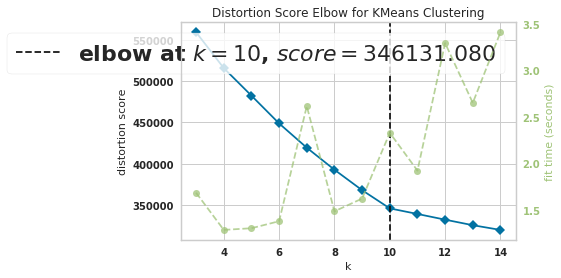

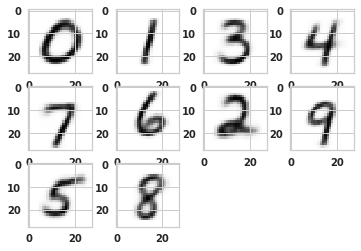

In [105]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


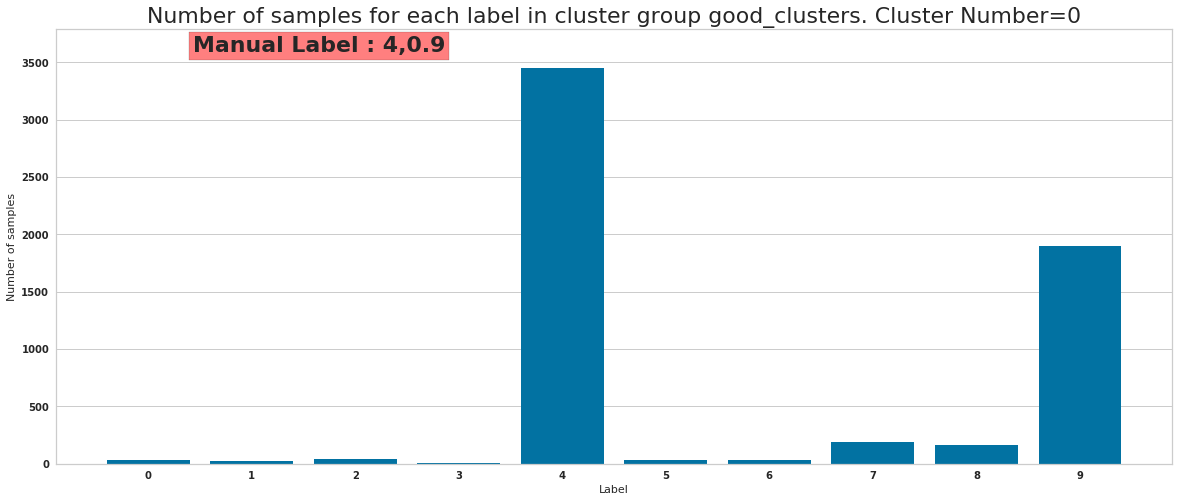

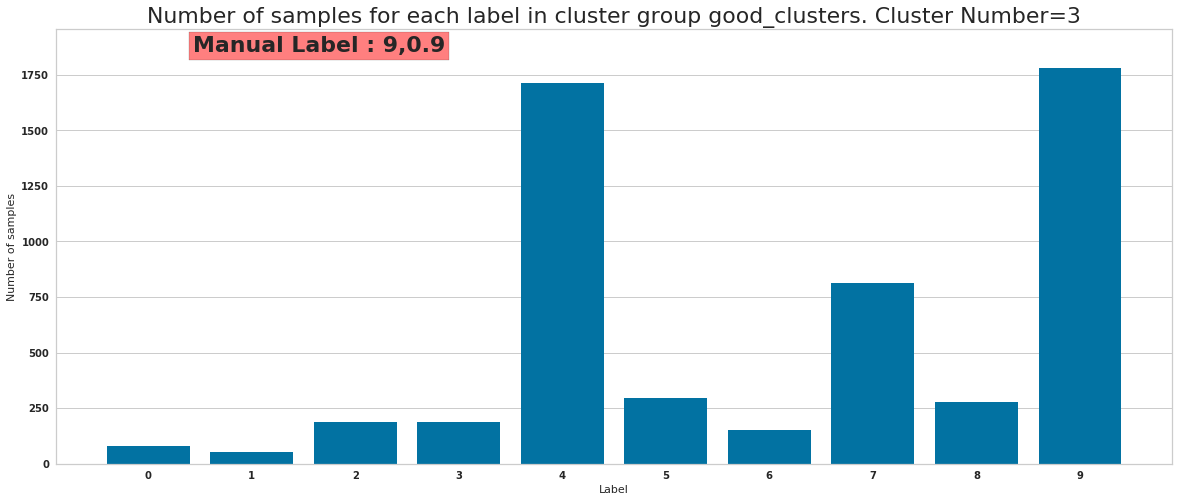

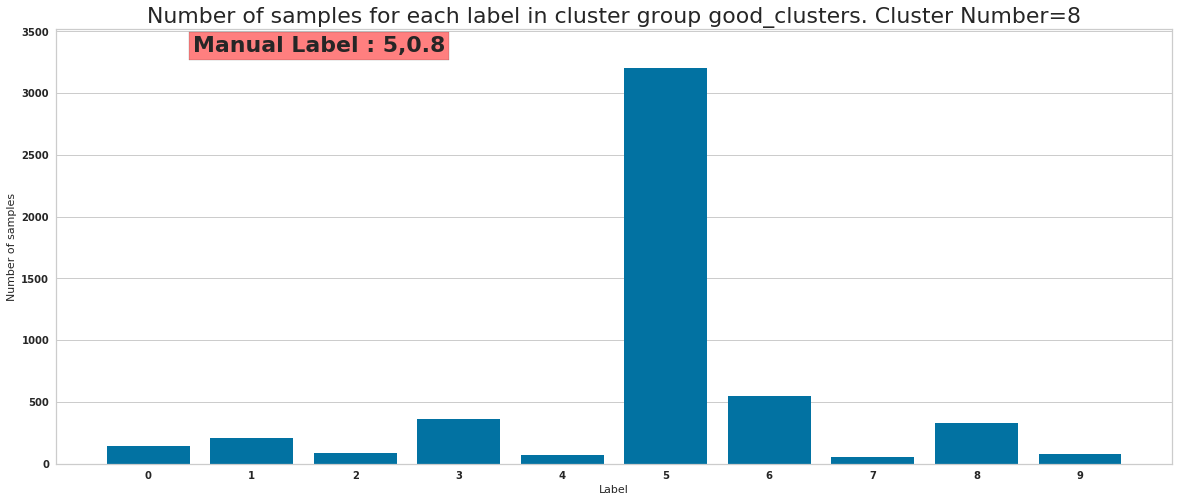

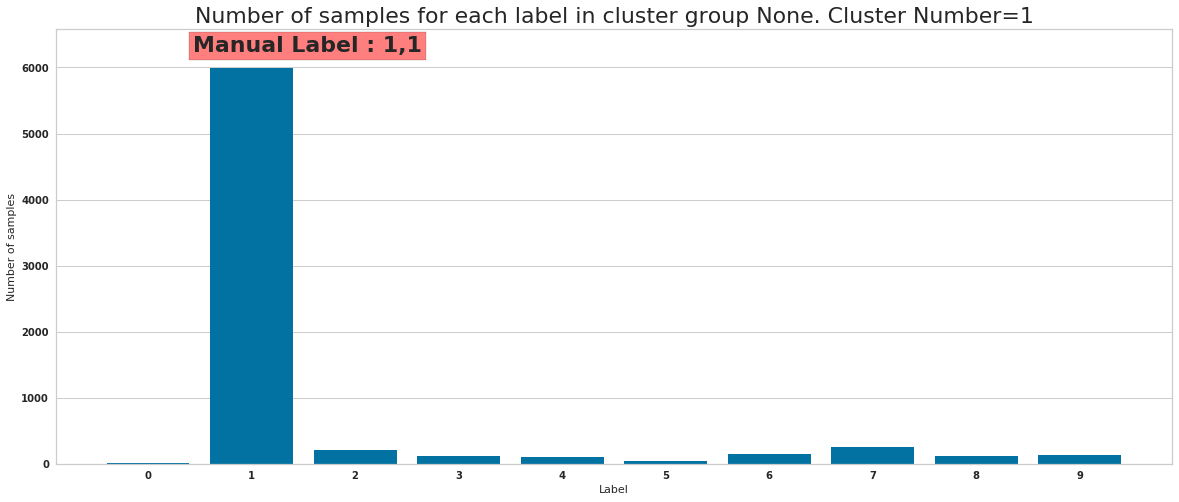

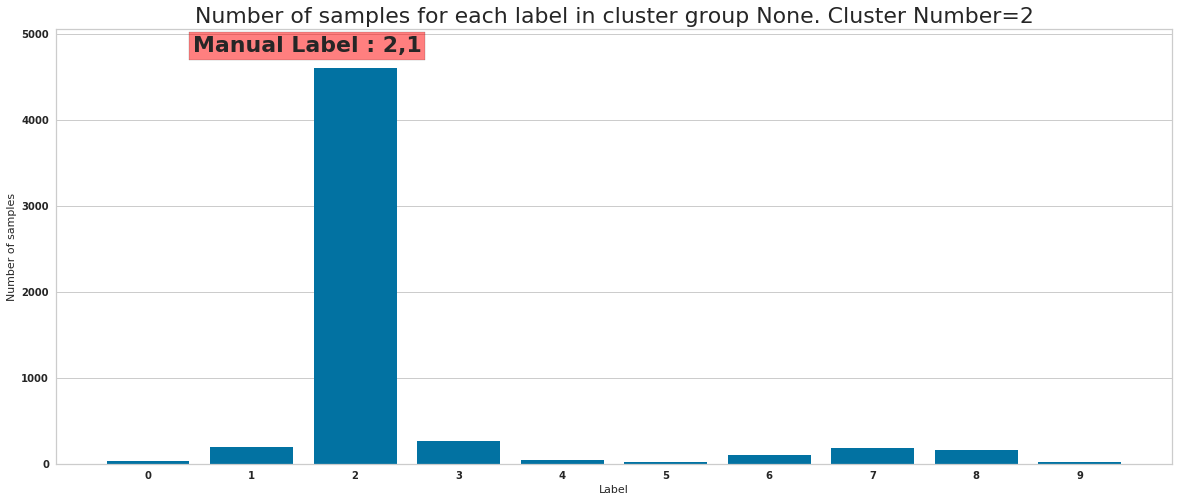

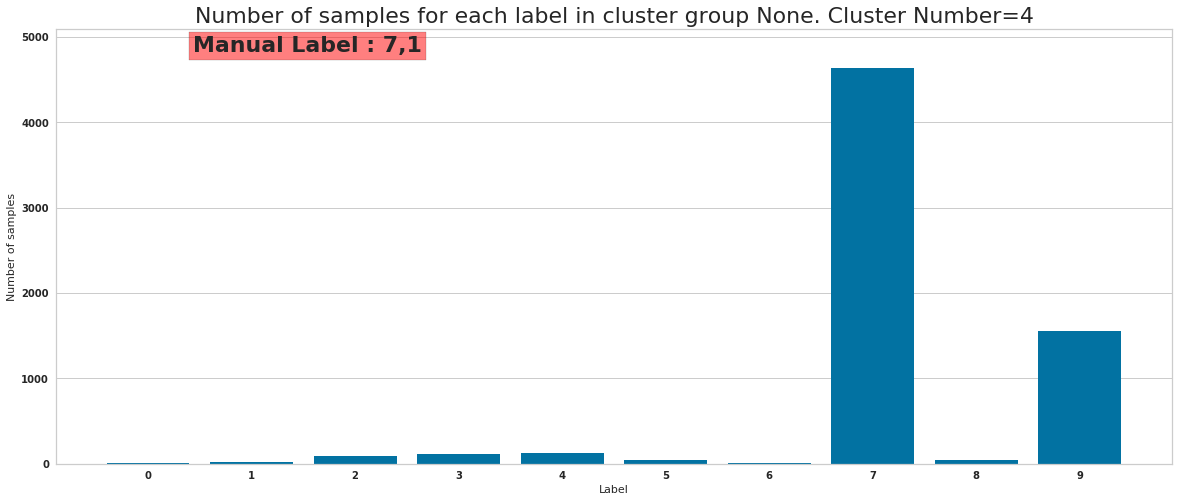

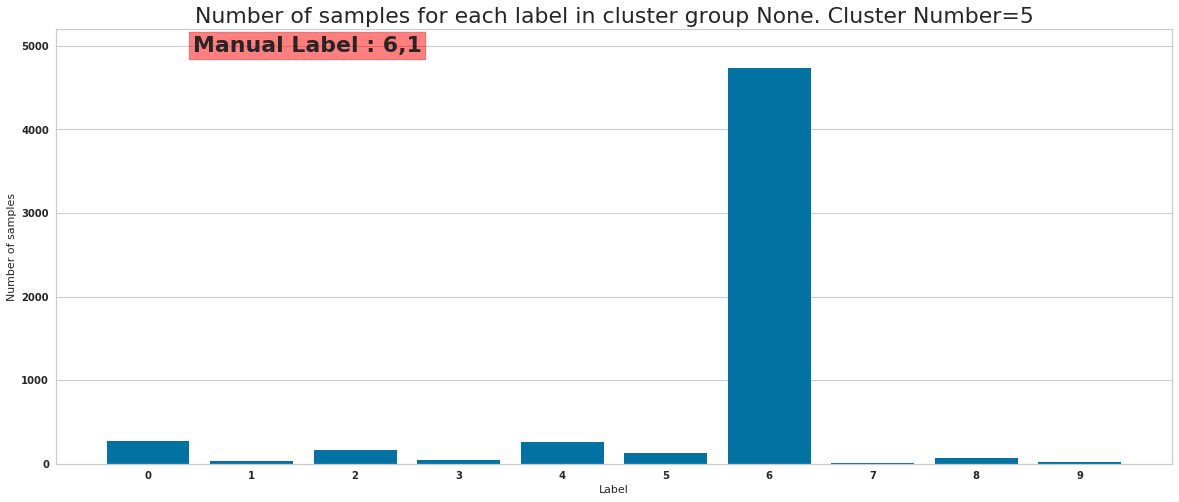

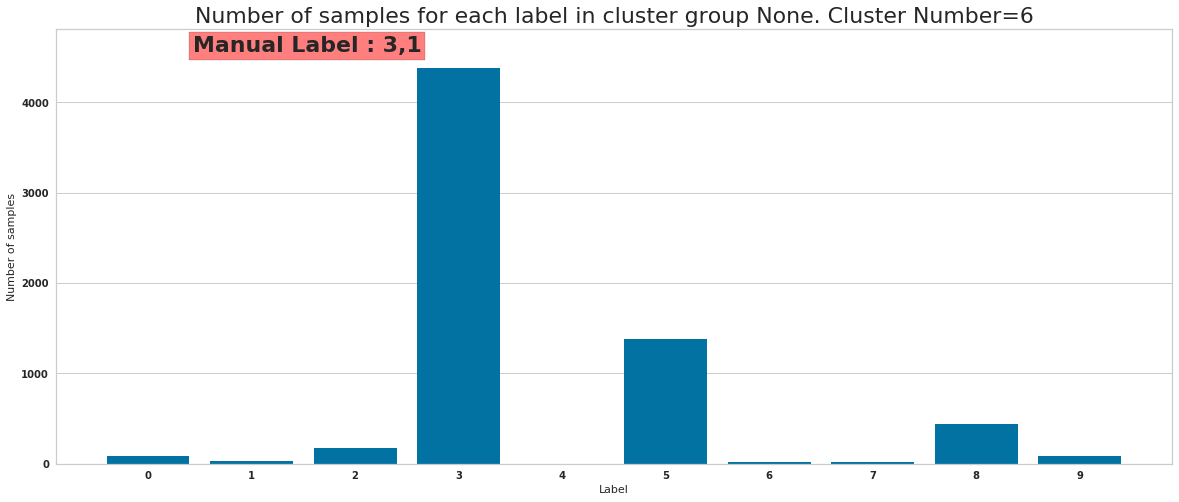

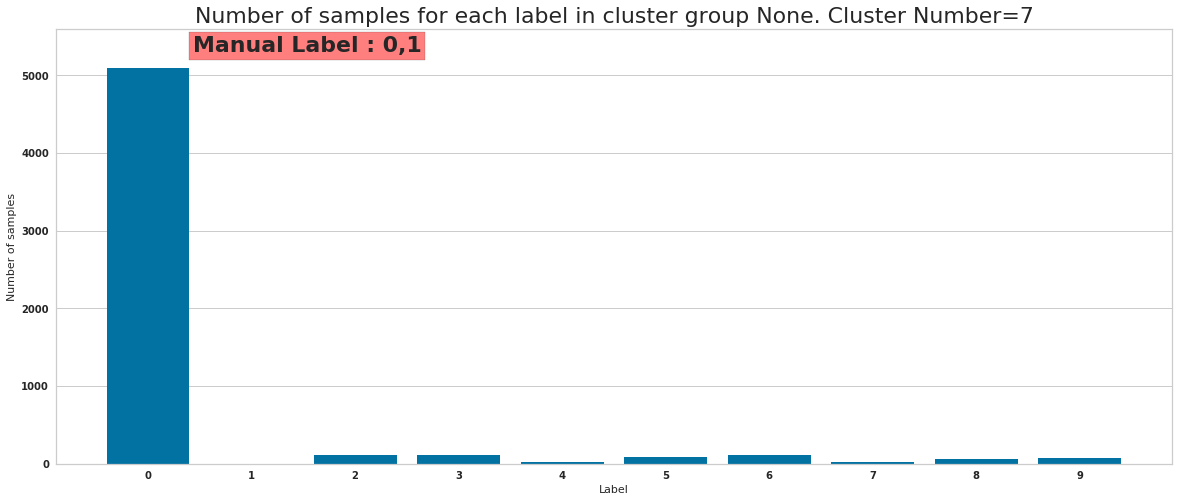

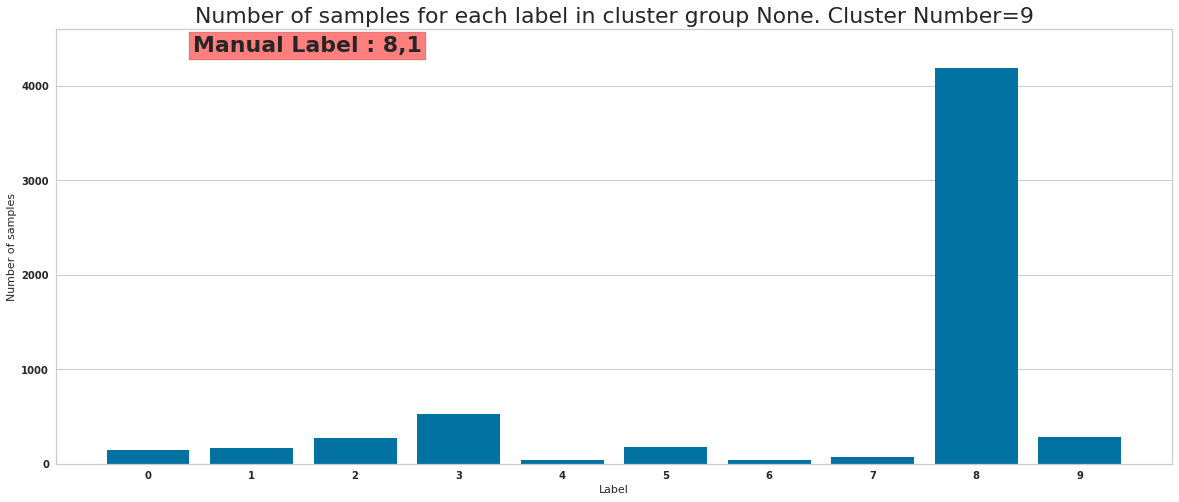

In [108]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [4,1,2,9,
                                           7,6,3,0,
                                           5,8
                                          ]
manual_annotation_json["manual_confidence"] = [0.9,1,1,0.9,
                                               1,1,1,1,
                                               0.8,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [109]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



TypeError: distance() missing 1 required positional argument: 'z_col_names'

In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 2
(6259, 47) (6259, 33)
Num correct=5034
Cluster 0 Manual Label 2 Percentage correct 80.42818341588114
********************************
Manual Label 3
(6954, 47) (6954, 33)
Num correct=4243
Cluster 1 Manual Label 3 Percentage correct 61.01524302559678
********************************
Manual Label 1
(7147, 47) (7147, 33)
Num correct=6439
Cluster 2 Manual Label 1 Percentage correct 90.09374562753602
********************************
Manual Label 7
(5853, 47) (5853, 33)
Num correct=5163
Cluster 3 Manual Label 7 Percentage correct 88.21117375704767
********************************
Manual Label 5
(3966, 47) (3966, 33)
Num correct=2855
Cluster 4 Manual Label 5 Percentage correct 71.98688855269793
********************************
Manual Label 4
(6608, 47) (6608, 33)
Num correct=2669
Cluster 5 Manual Label 4 Percentage correct 40.39043583535109
********************************
Manual Label 0
(5392, 47) (5392, 33)
Num correct=4749
Cluster 6 Manual Label 0 Percentage correct 88.07492

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

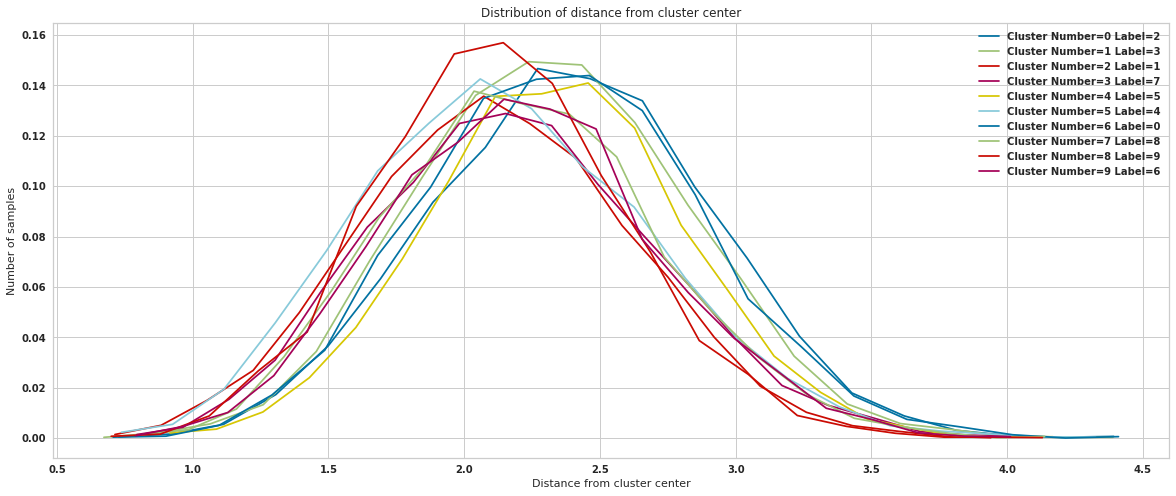

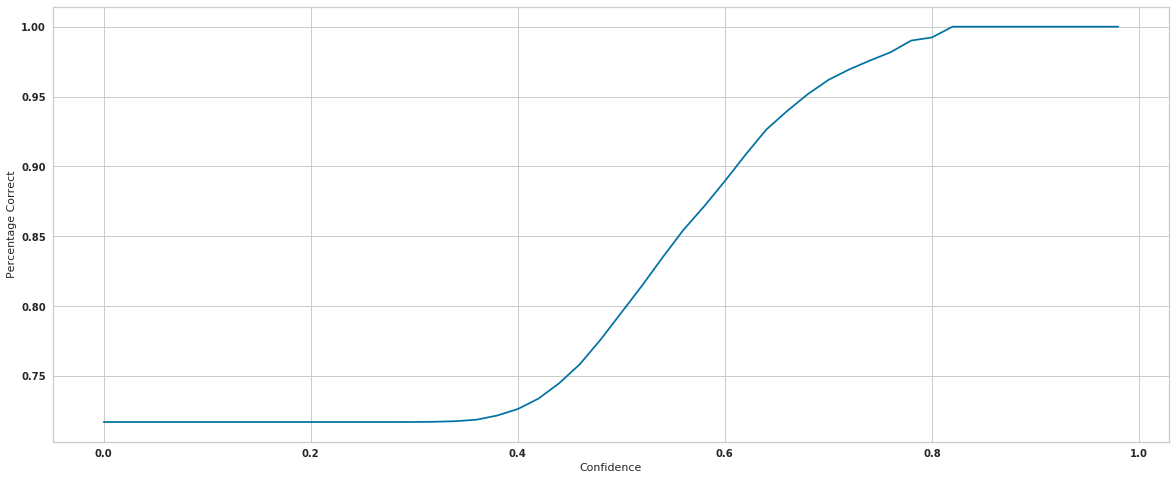

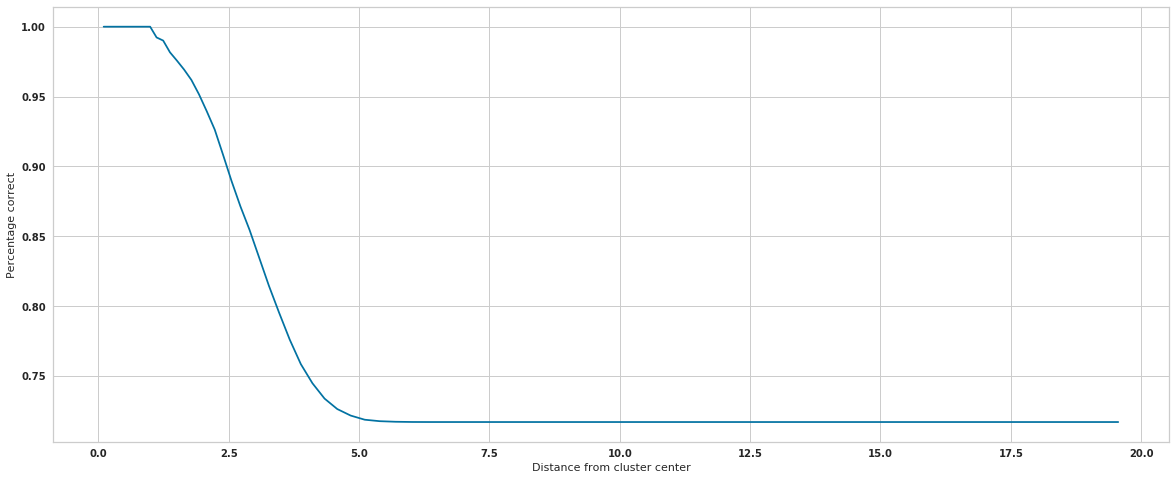

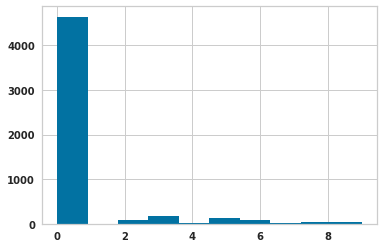

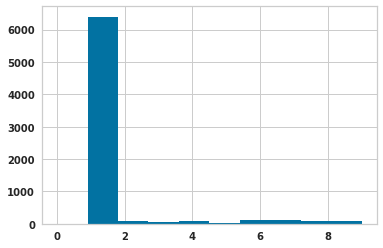

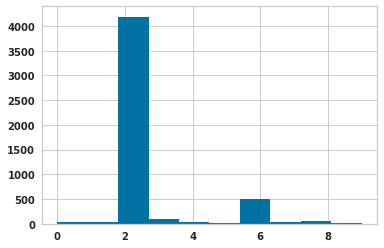

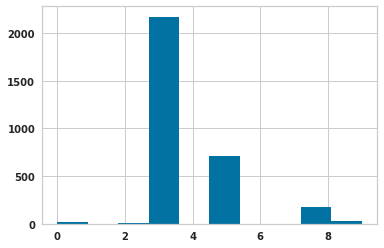

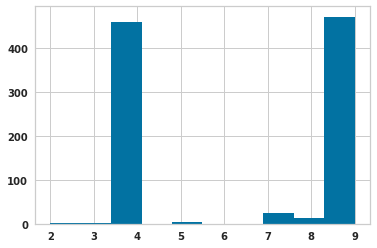

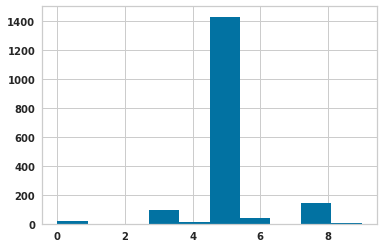

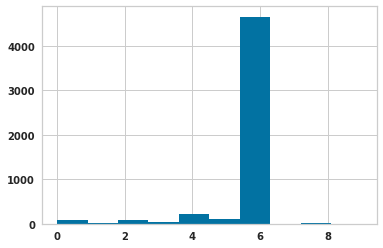

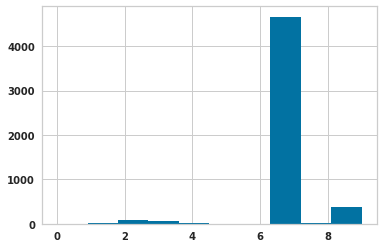

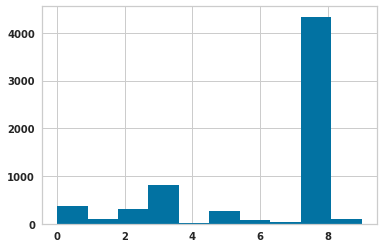

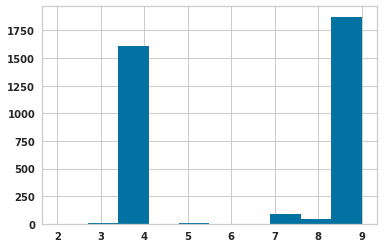

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [100]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

TypeError: initialize_model_train_and_get_features() missing 1 required positional argument: 'model_type'

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_10/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS
Number of steps completed=5610
Number of epochs completed 6.0
run_id=10 z_min=-5.0479445 z_max=4.711913
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instea

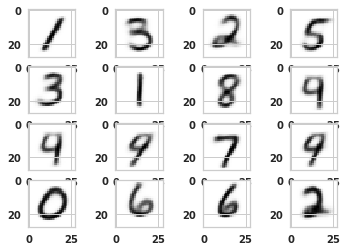

In [75]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


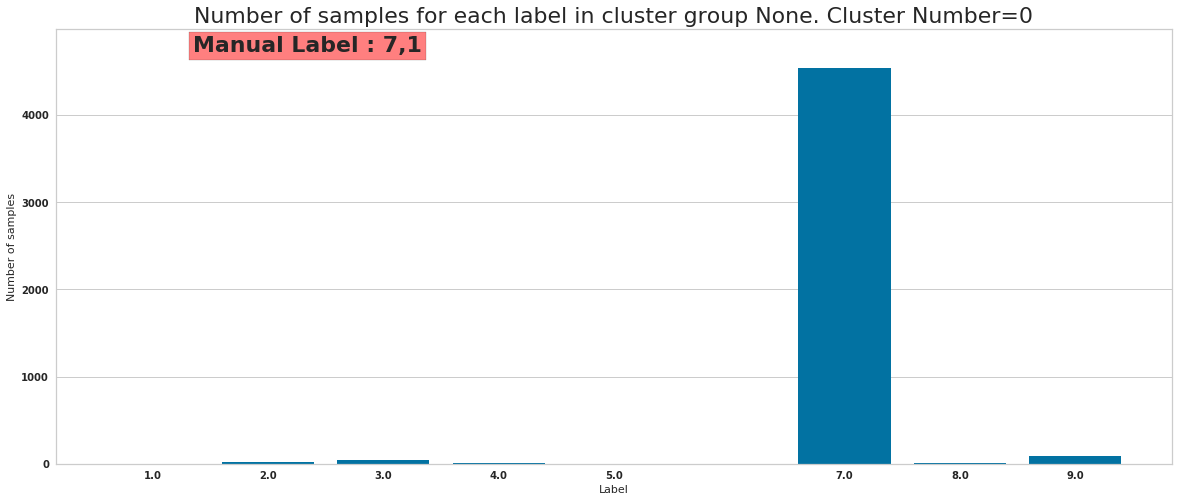

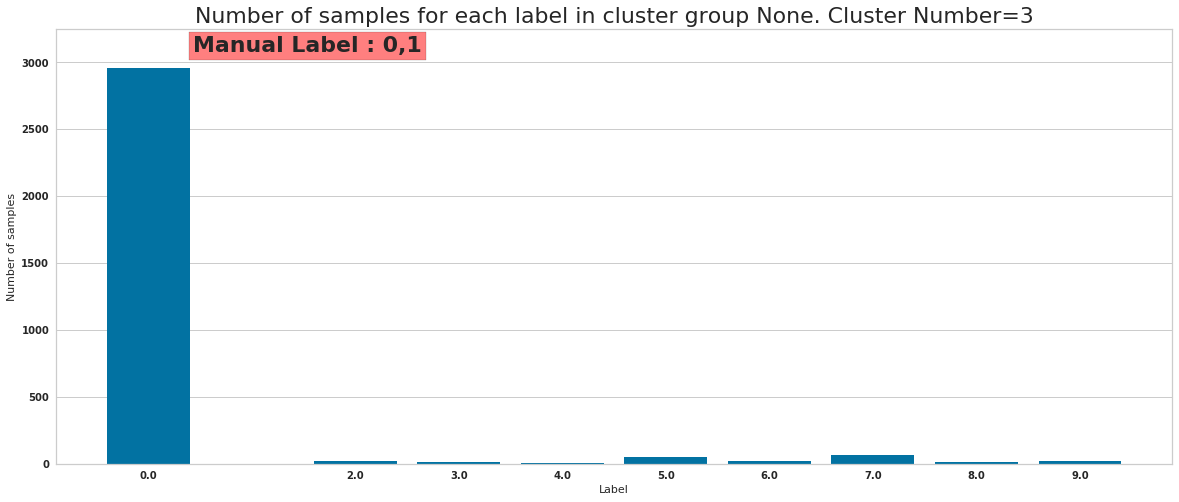

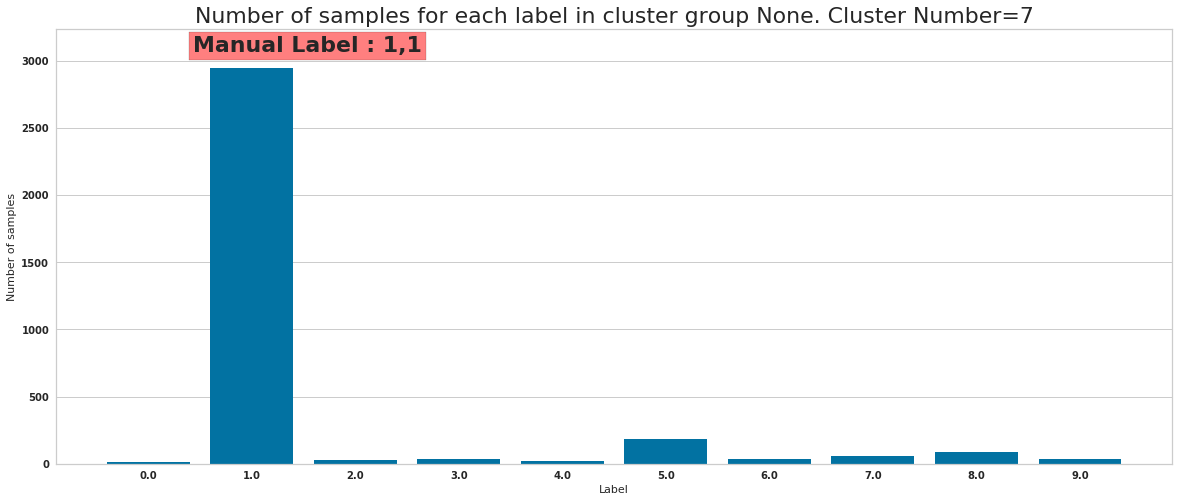

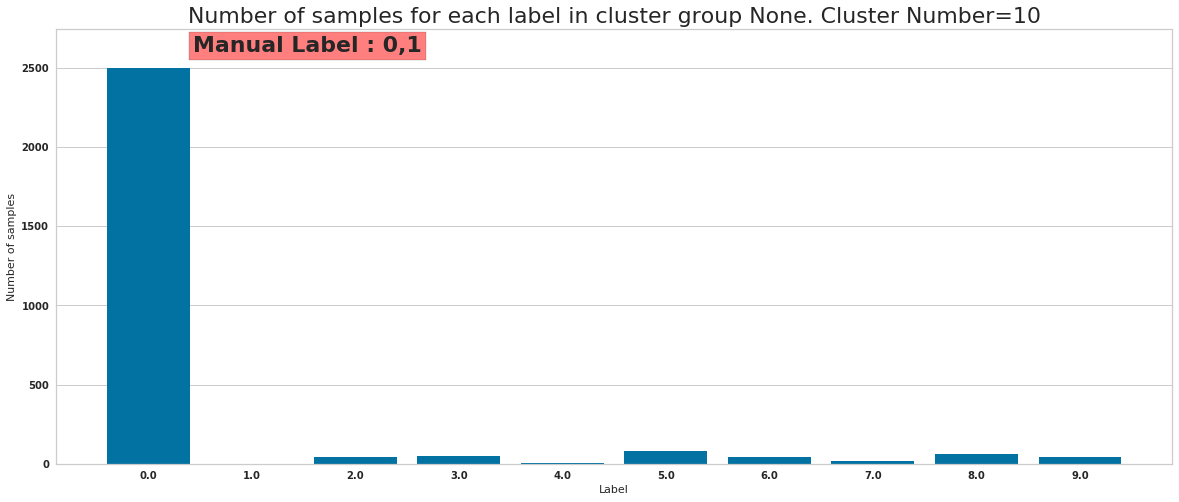

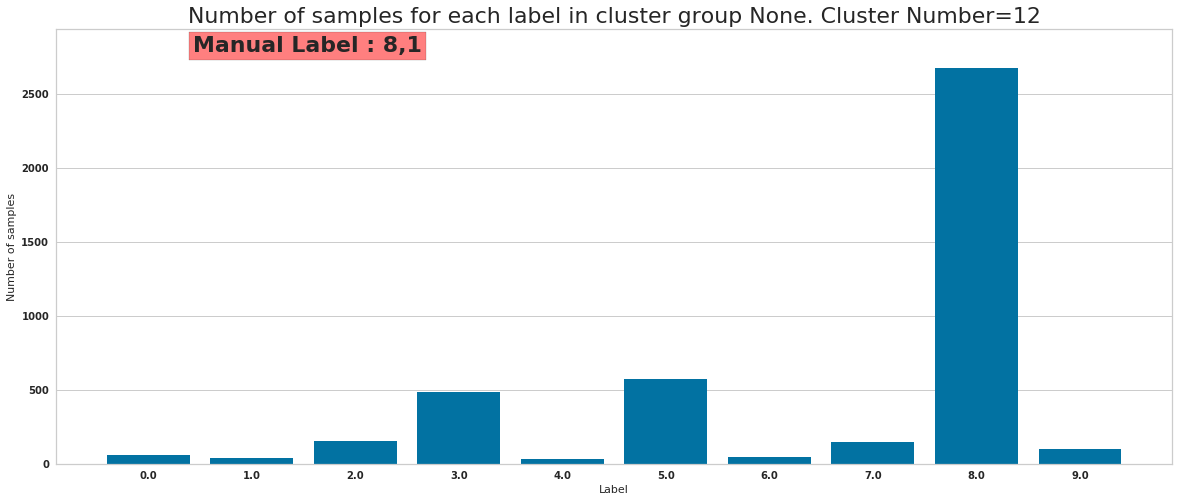

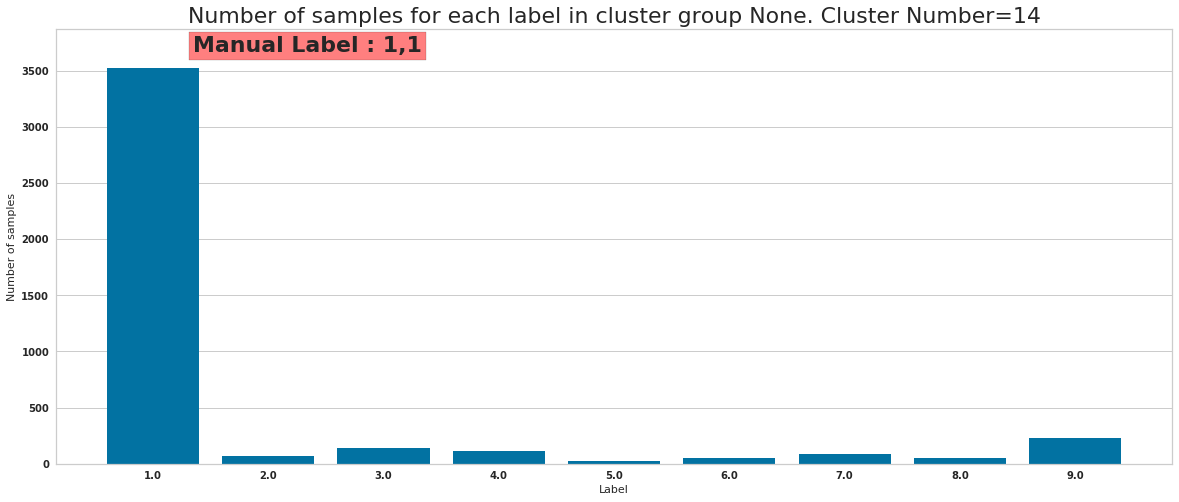

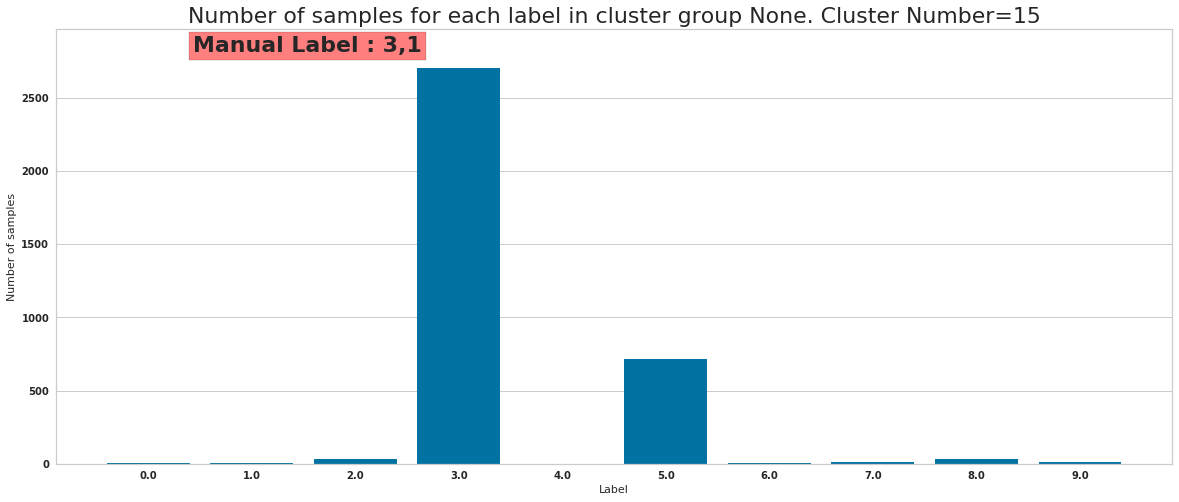

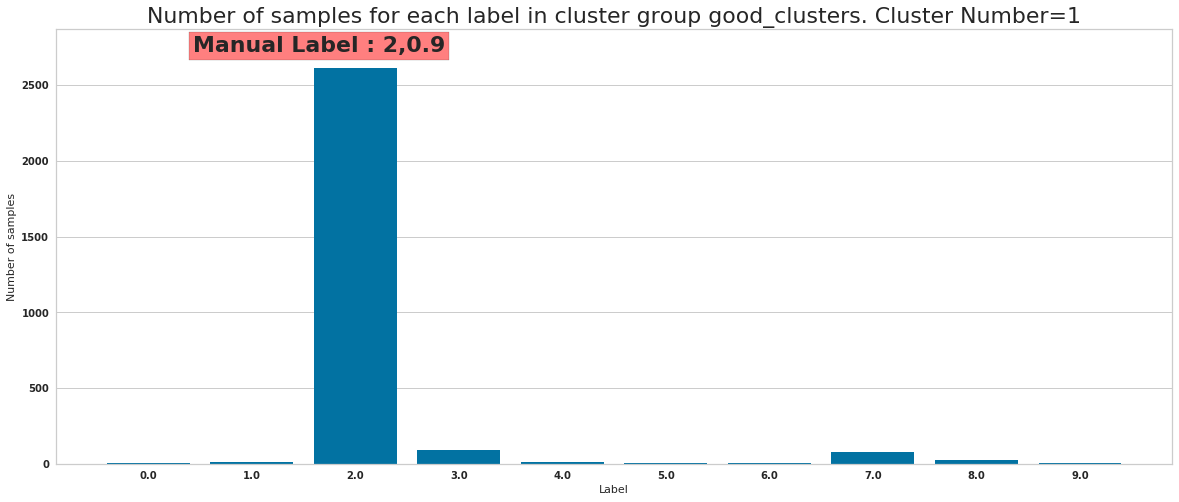

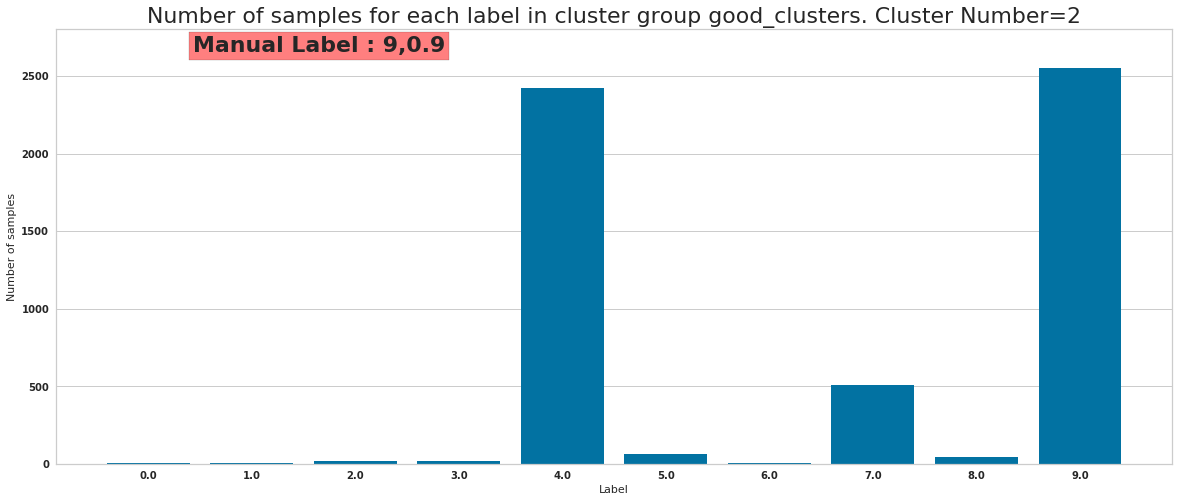

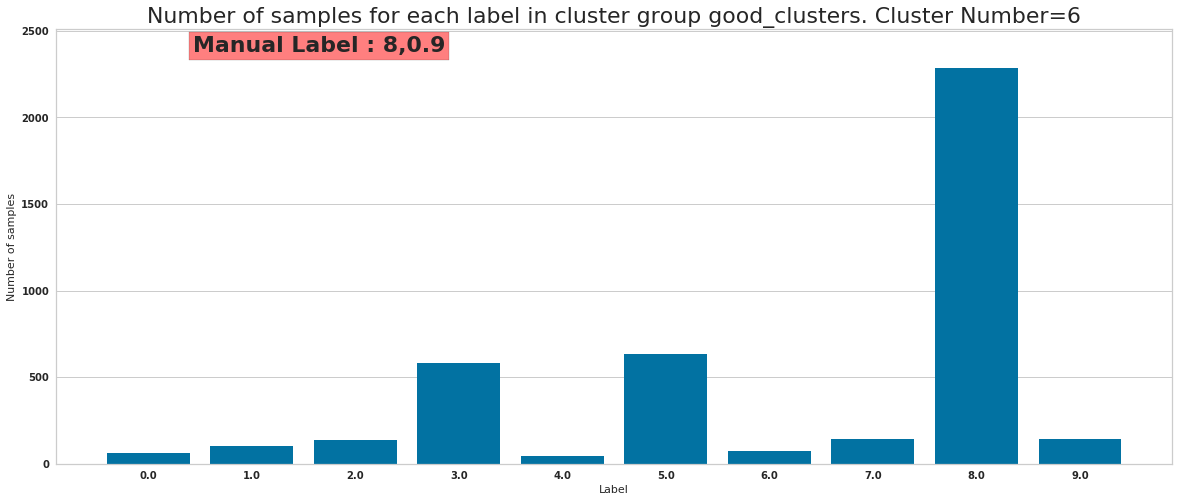

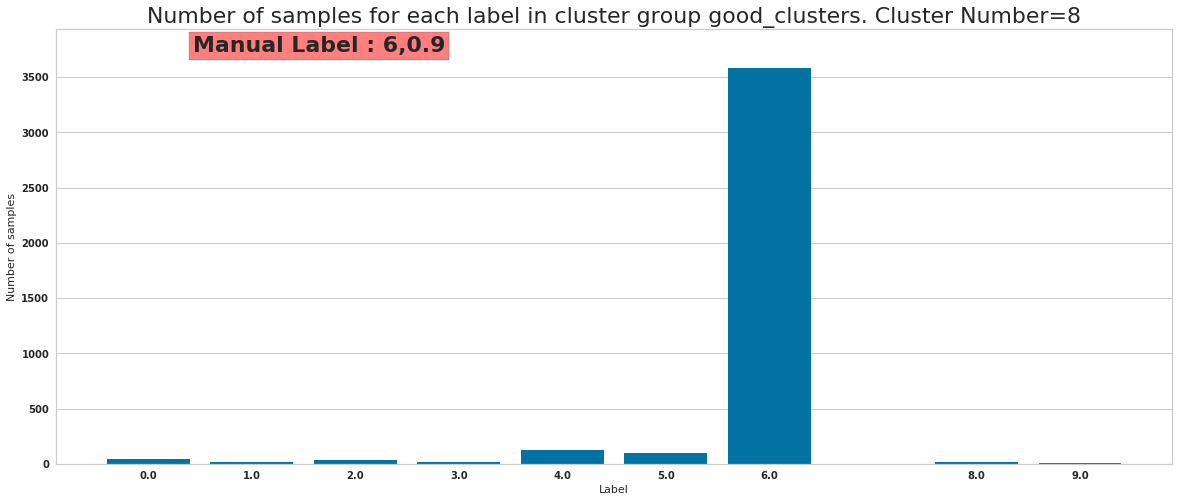

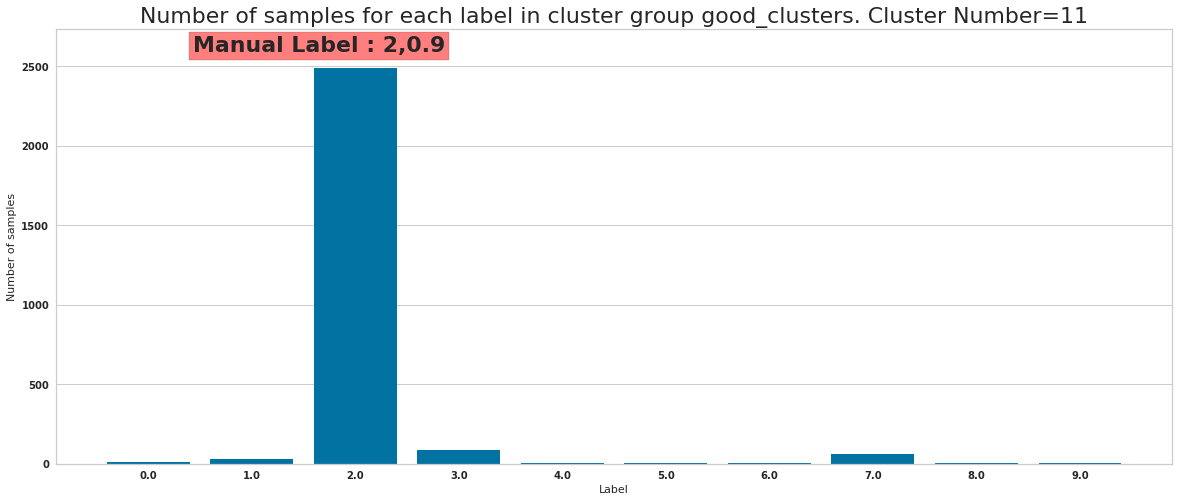

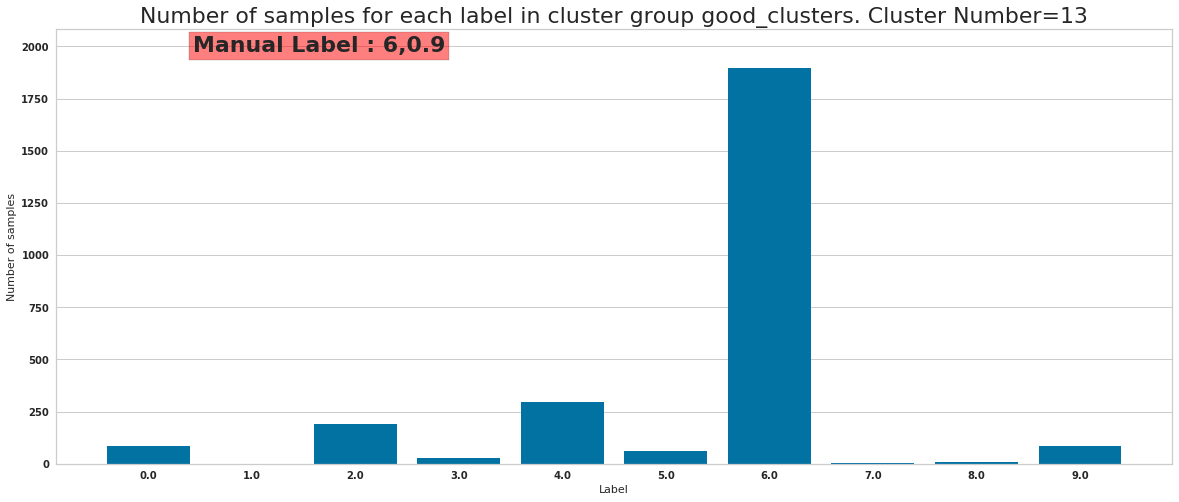

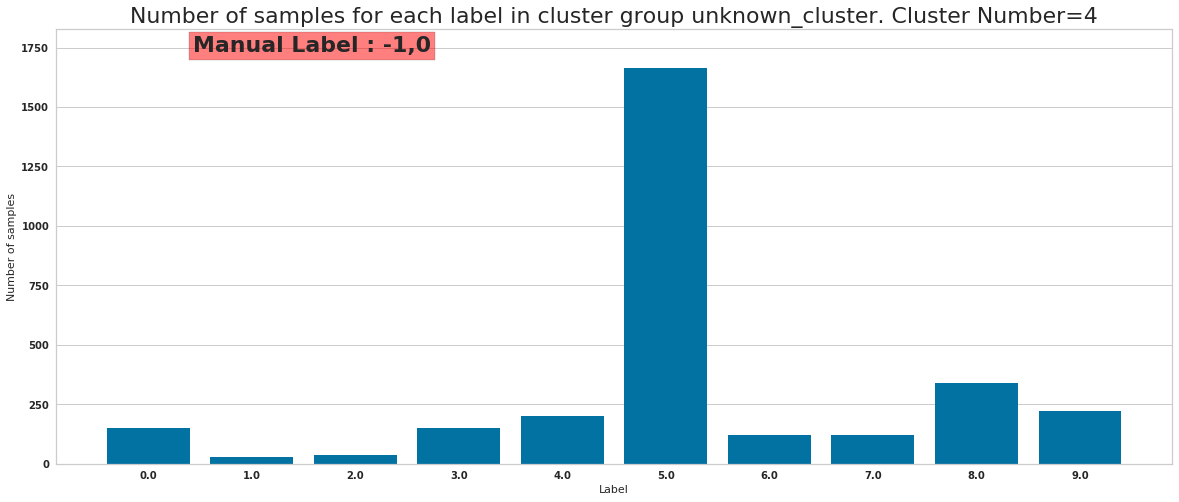

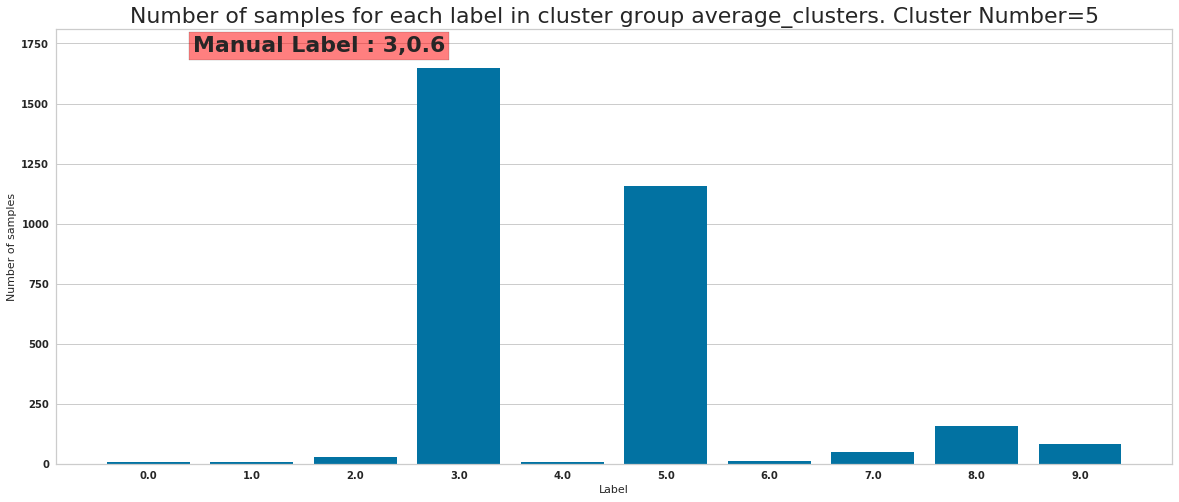

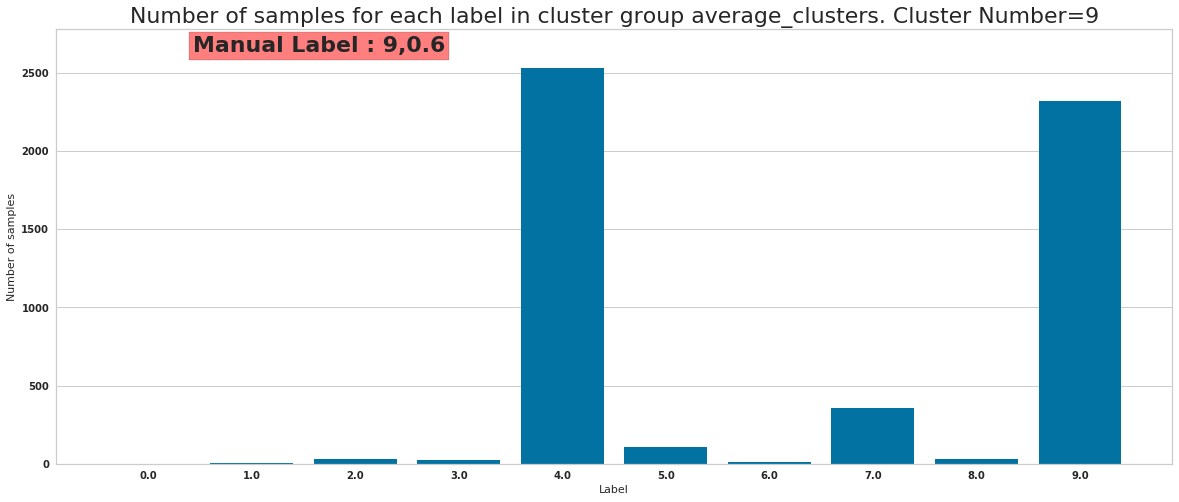

In [115]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,2,9,0,
                                           -1,3,8,1,
                                           6,9,0,2,
                                           8,6,1,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,0.9,1,
                                               0,0.6,0.9,1,
                                               0.9,0.6,1,0.9,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


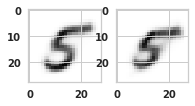

In [116]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [117]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [118]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


4
2
Skipping distance computation for unknown cluster
Manual Label 7
(4718, 54) (4718, 49)
Num correct=4536
Cluster 0 Manual Label 7 Percentage correct 96.14243323442136
********************************
Manual Label 2
(2847, 54) (2847, 49)
Num correct=2609
Cluster 1 Manual Label 2 Percentage correct 91.64032314717247
********************************
Manual Label 9
(5642, 54) (5642, 49)
Num correct=2549
Cluster 2 Manual Label 9 Percentage correct 45.17901453385324
********************************
Manual Label 0
(3158, 54) (3158, 49)
Num correct=2954
Cluster 3 Manual Label 0 Percentage correct 93.54021532615579
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 3
(3149, 54) (3149, 49)
Num correct=1646
Cluster 5 Manual Label 3 Percentage correct 52.270562083201014
********************************
Manual Label 8
(4202, 54) (4202, 49)
Num correct=2283
Cluster 6 Manual Label 8 Percentage correct 54.33127082341742
********

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

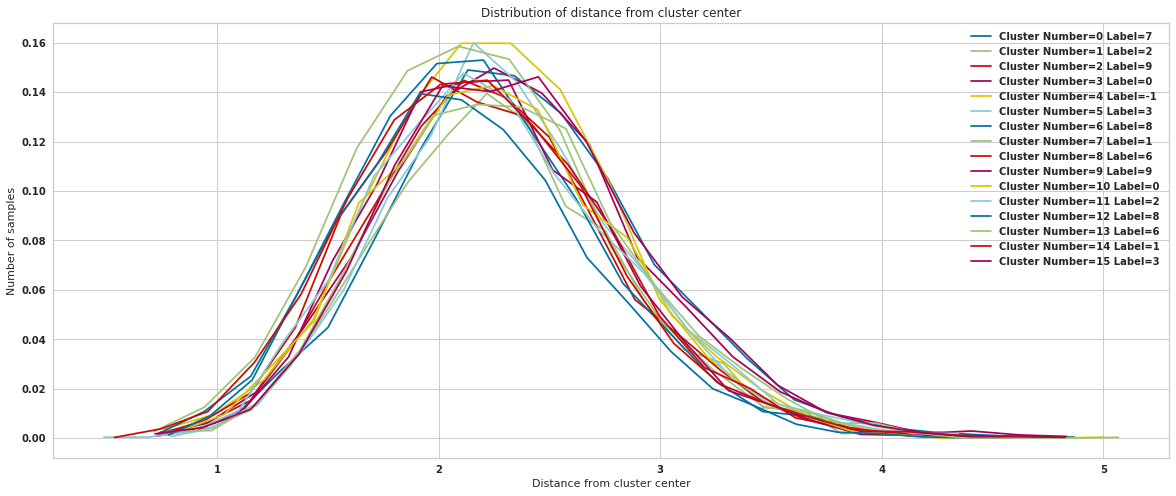

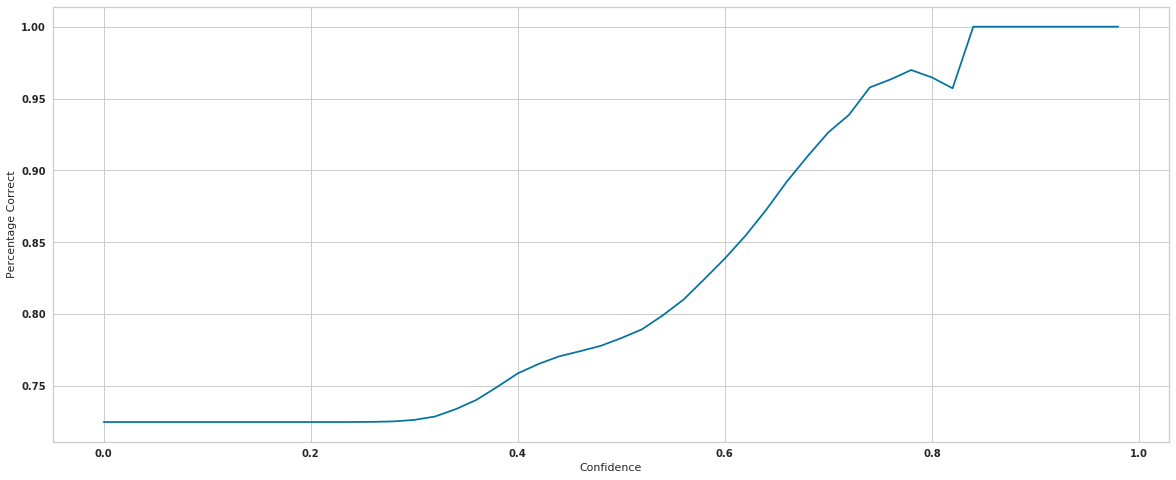

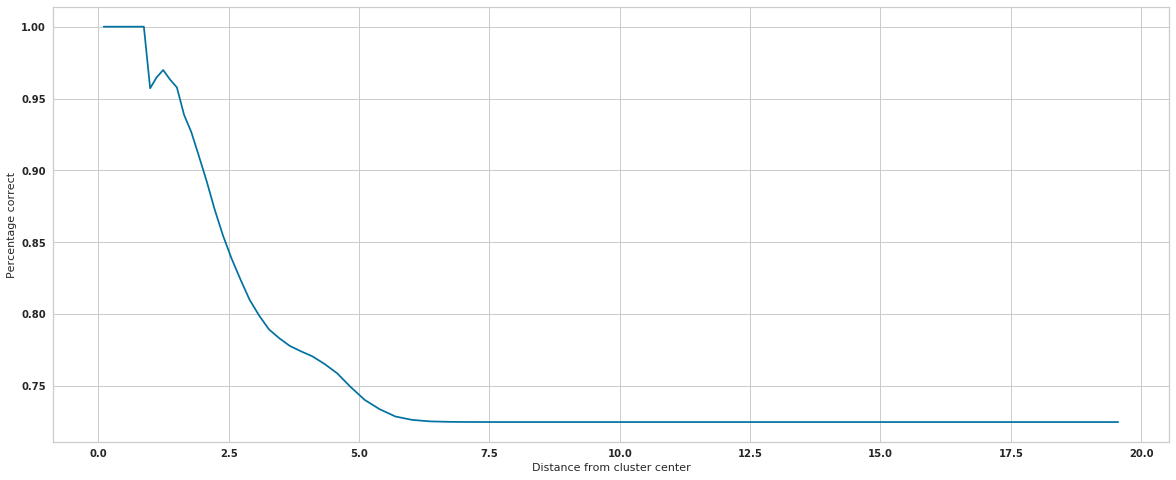

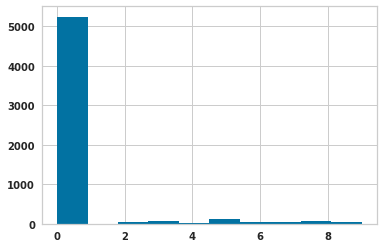

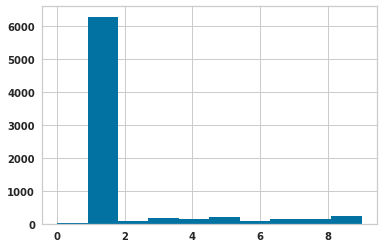

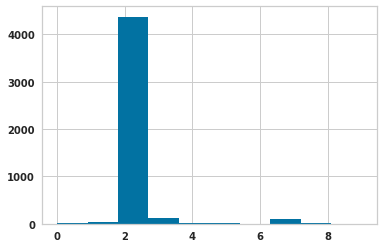

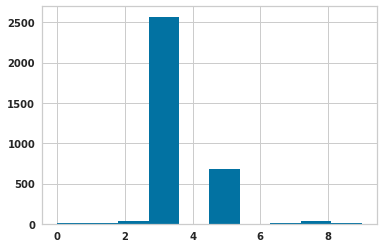

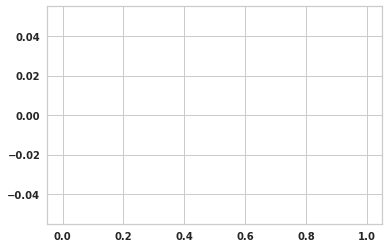

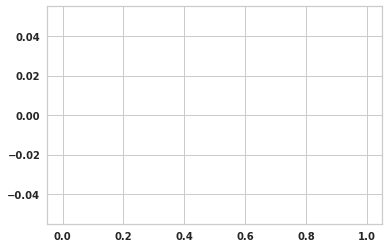

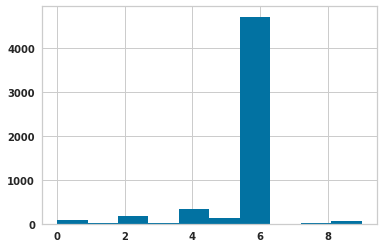

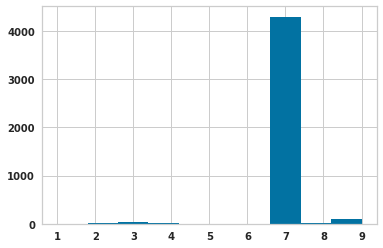

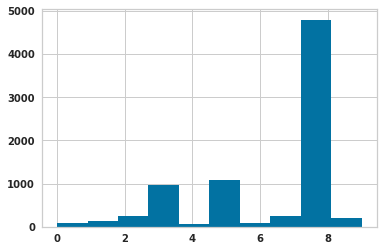

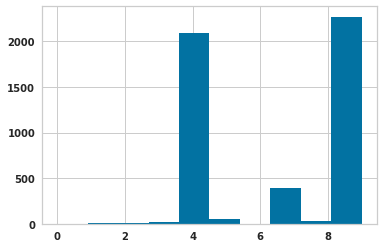

In [119]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [120]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56805
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:06 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS
Number of steps completed=6545
Number of epochs completed 7.0
run_id=2 z_min=-4.9489493 z_max=4.856212
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.

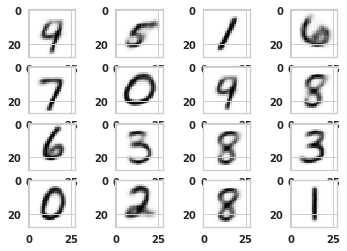

In [121]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


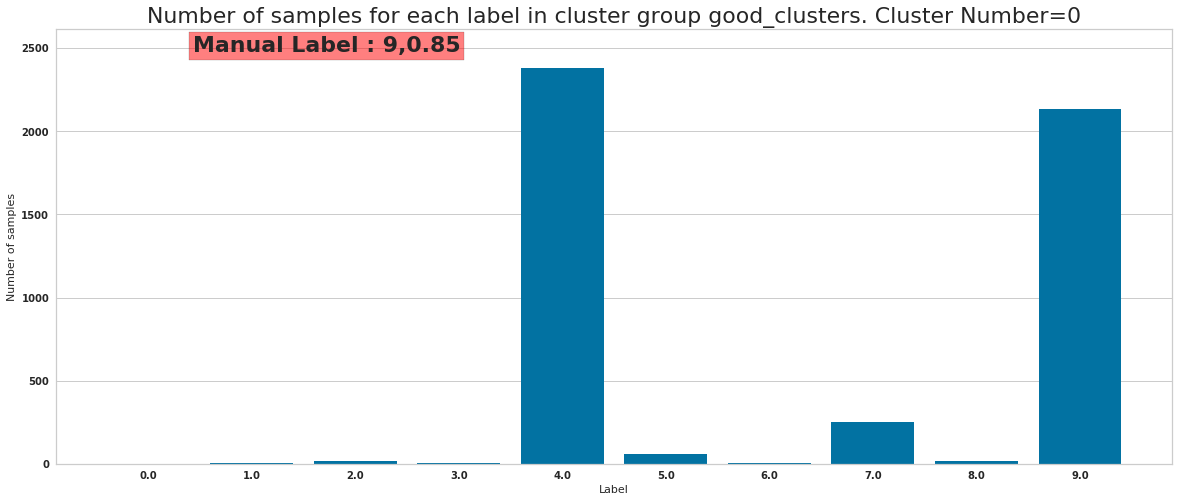

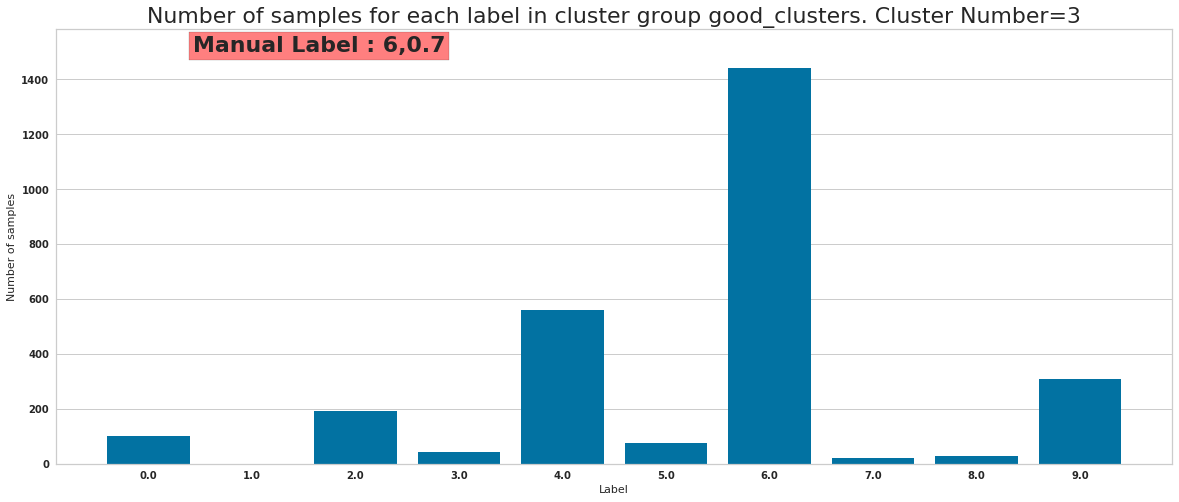

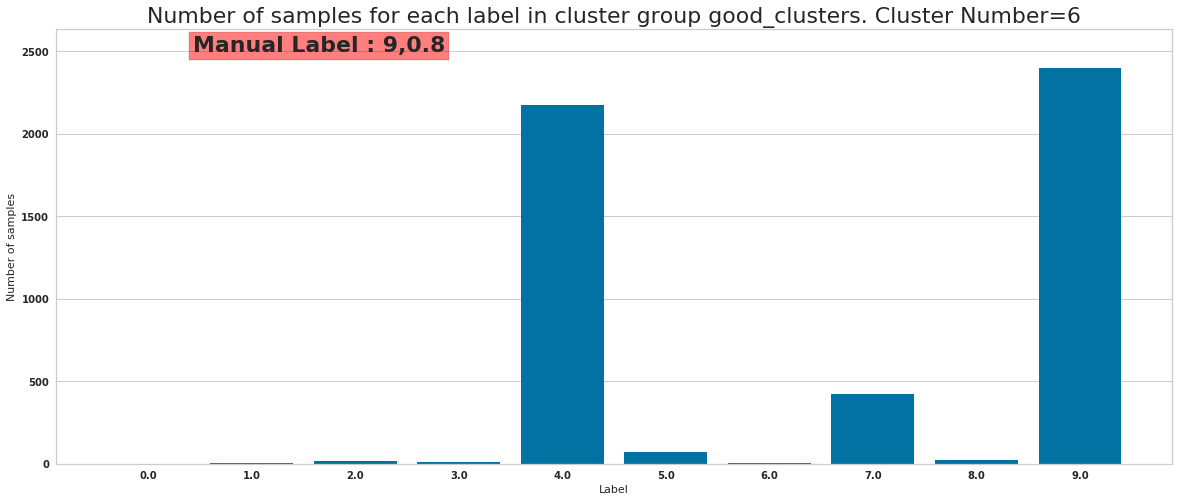

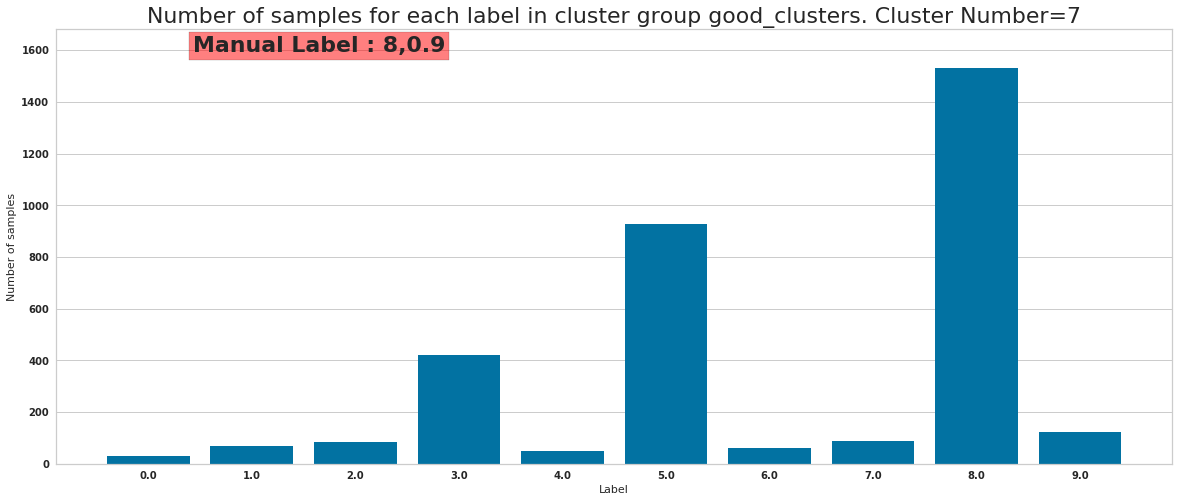

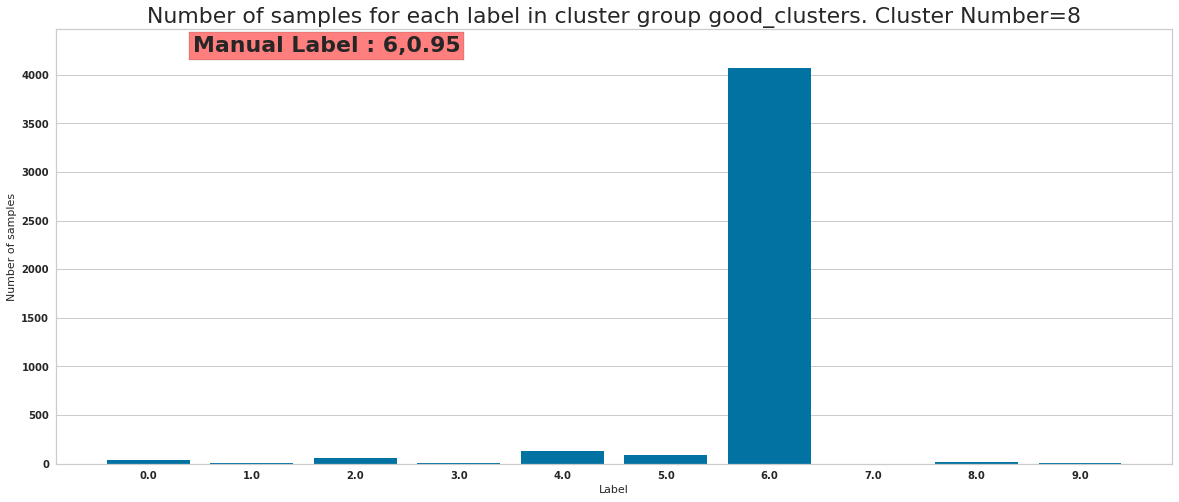

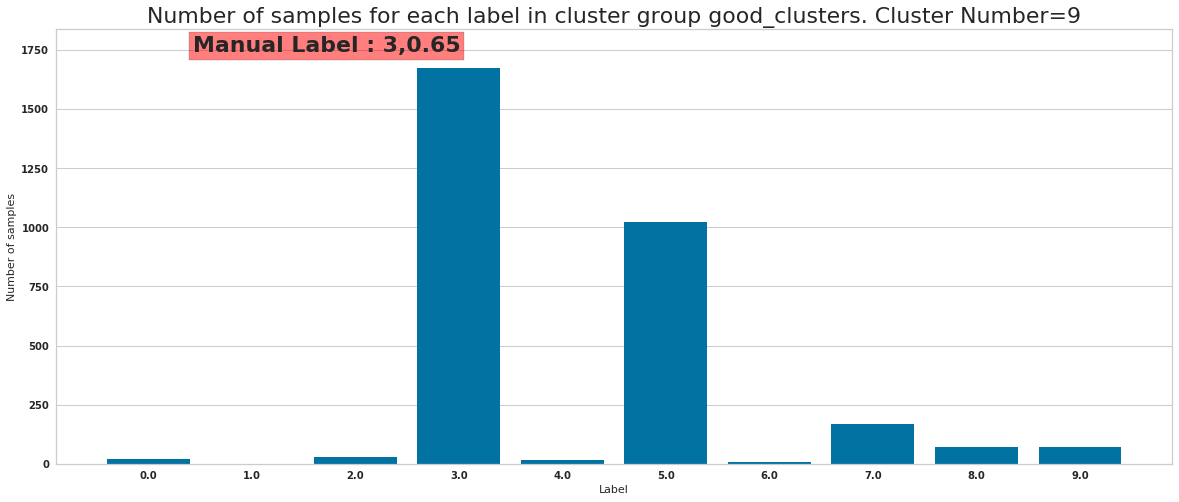

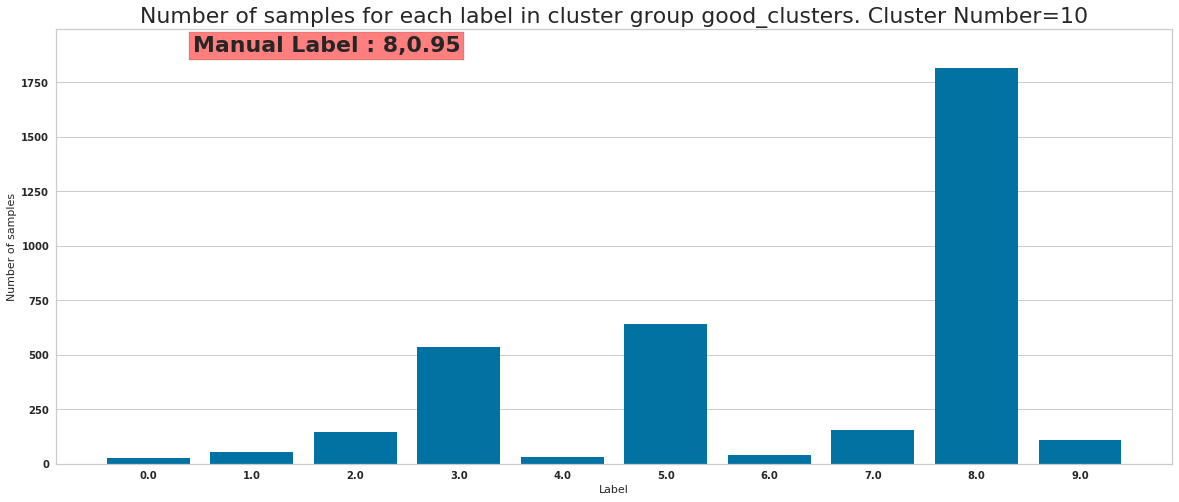

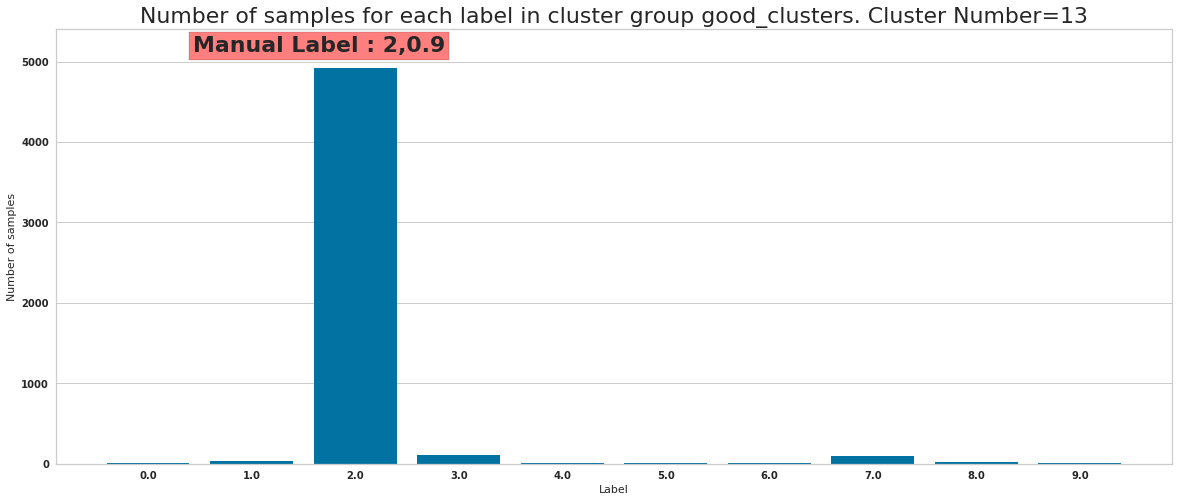

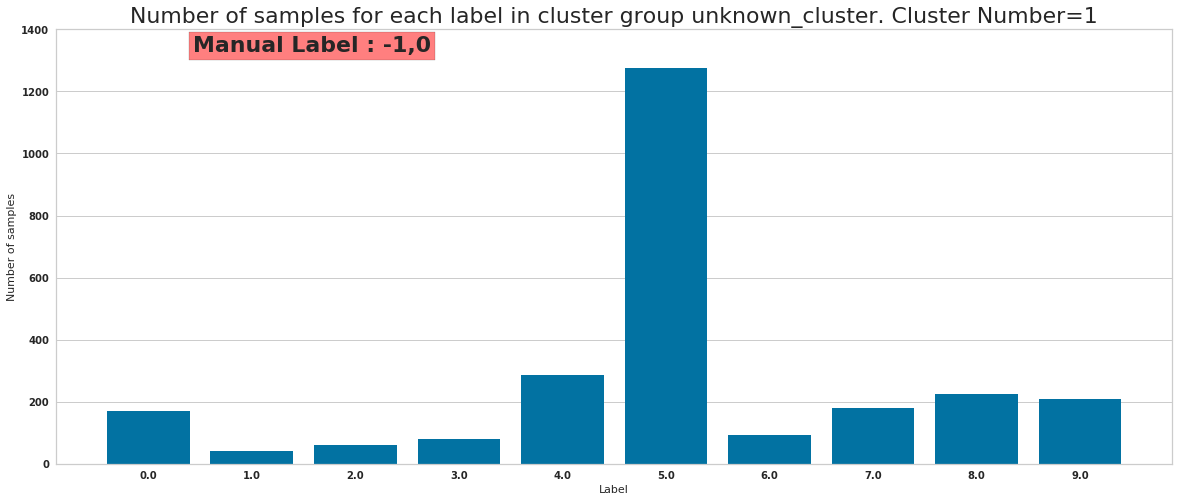

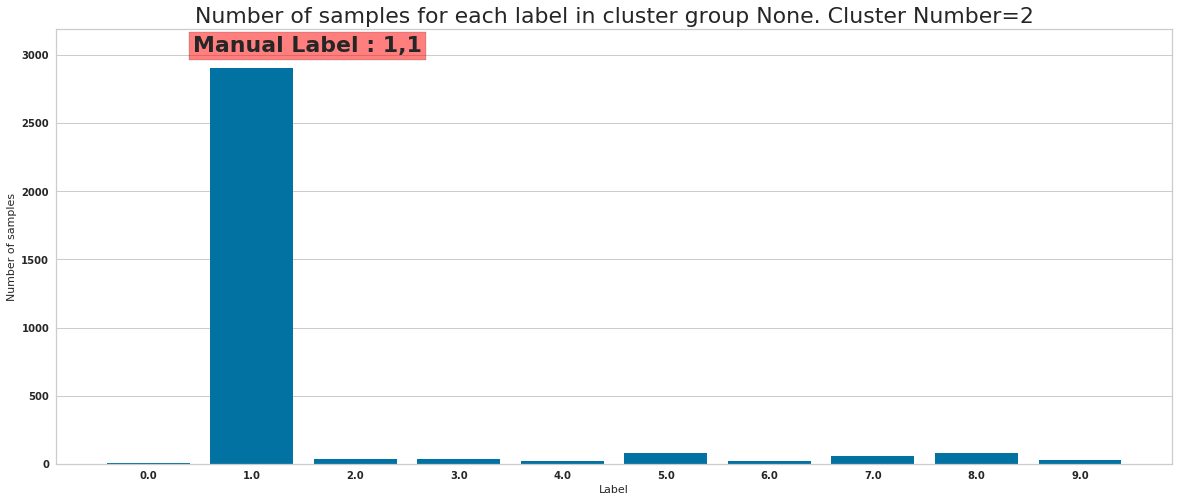

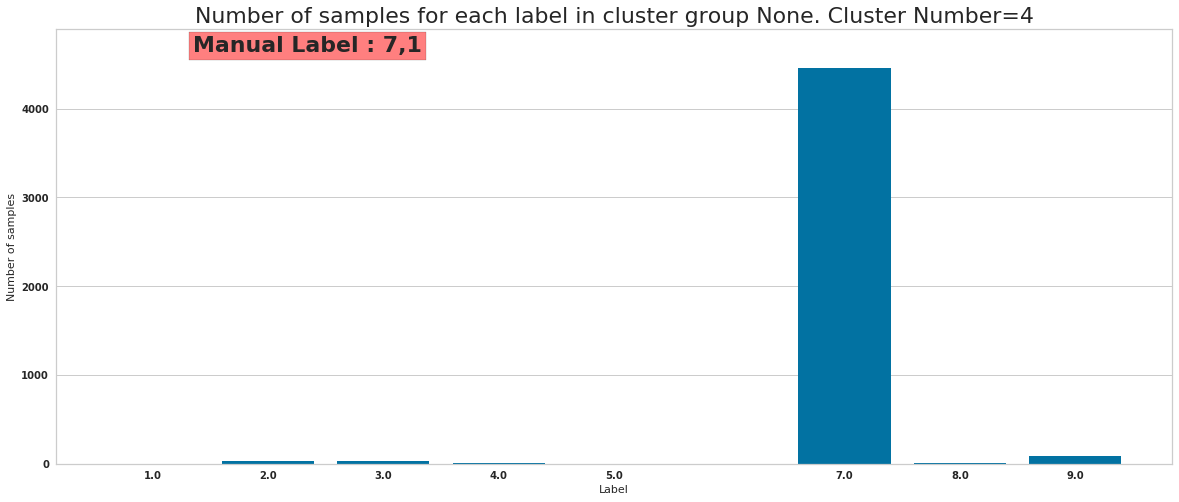

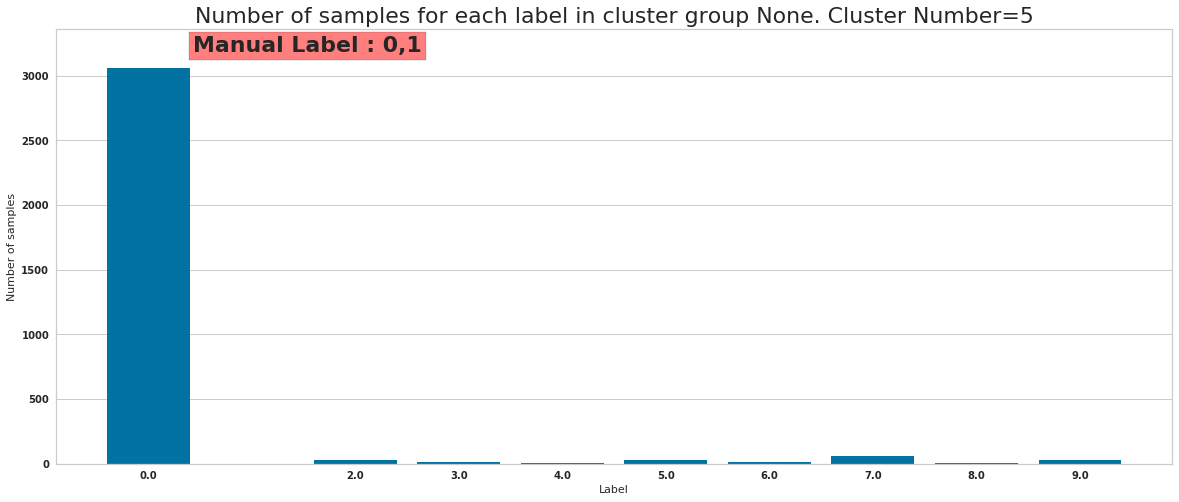

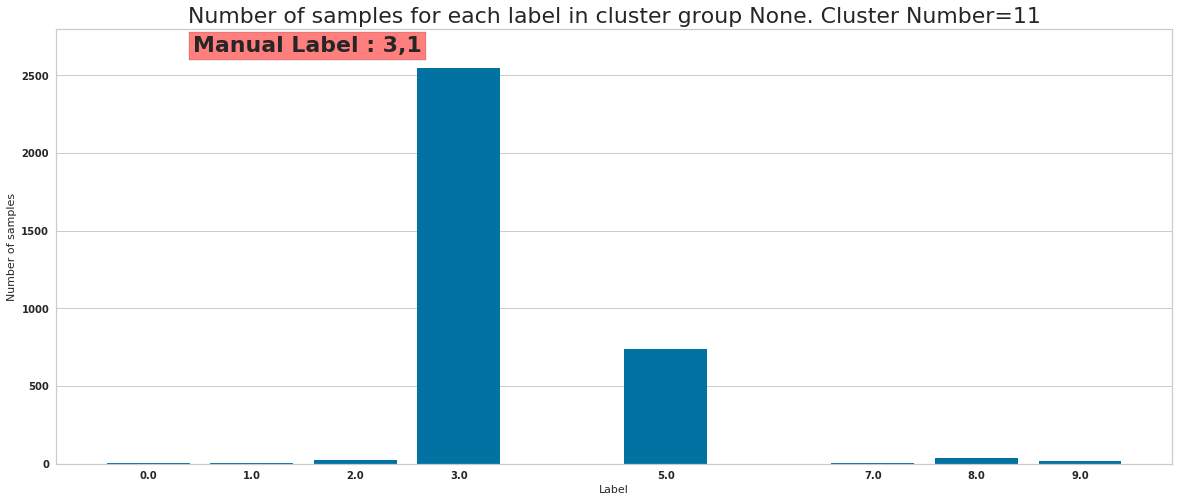

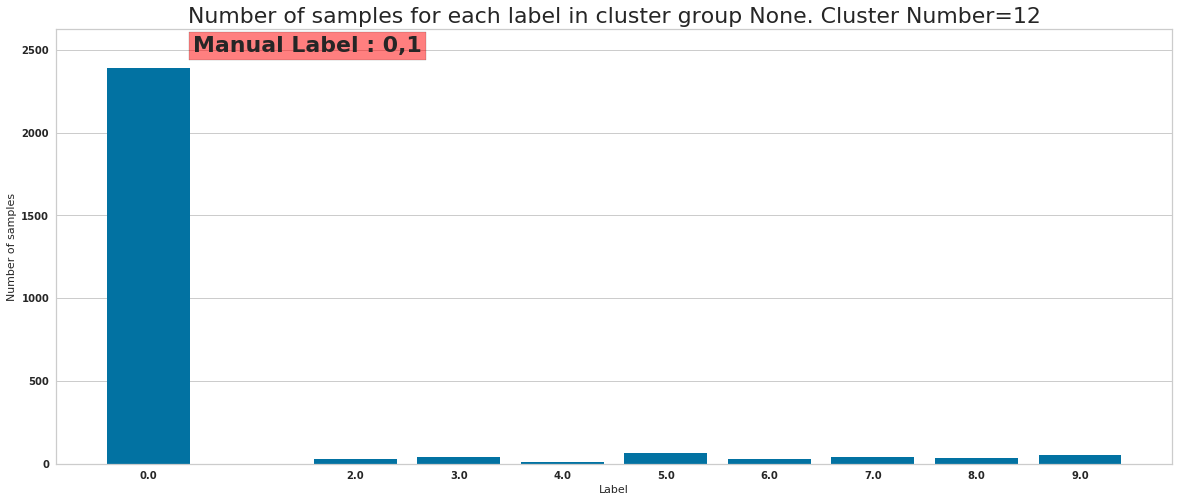

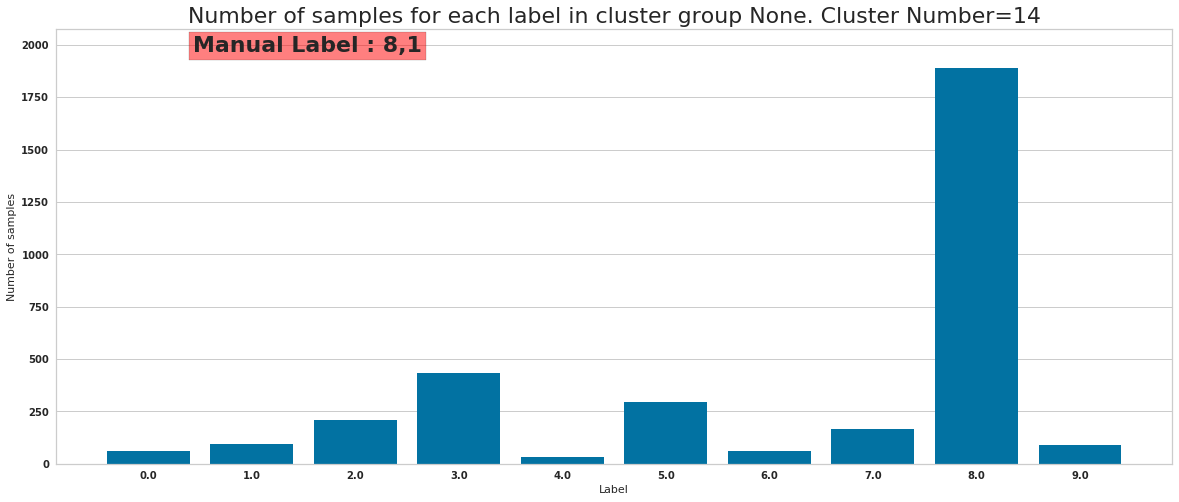

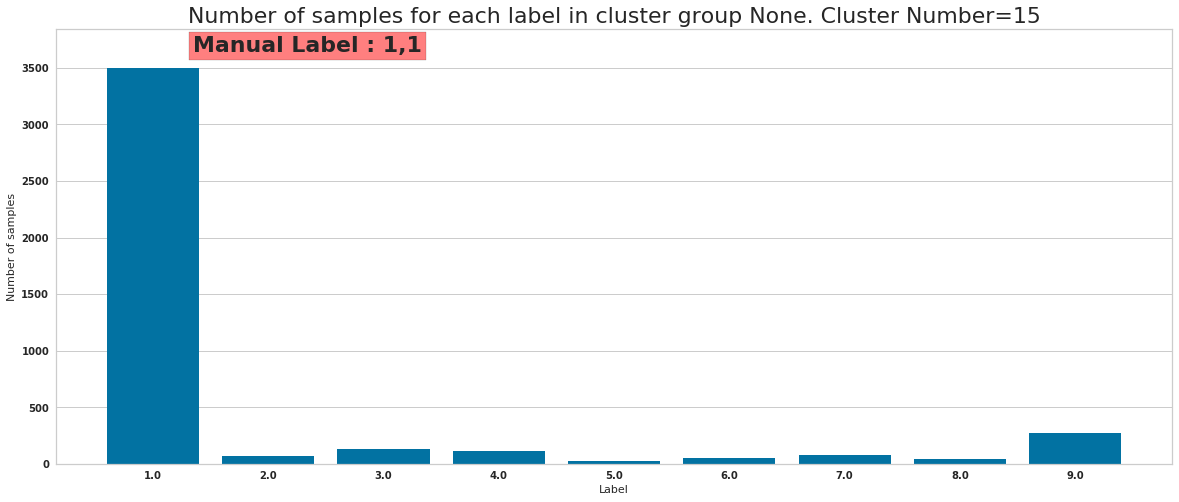

In [122]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,-1,1,6,
                                           7,0,9,8,
                                           6,3,8,3,
                                           0,2,8,1
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0,1,0.7,
                                               1,1,0.8,0.9,
                                               0.95,0.65,0.95,1,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


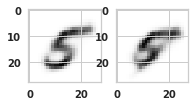

In [123]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [124]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [125]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


1
2
Skipping distance computation for unknown cluster
Manual Label 9
(4878, 54) (4878, 32)
Num correct=2136
Cluster 0 Manual Label 9 Percentage correct 43.788437884378844
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 1
(3259, 54) (3259, 32)
Num correct=2902
Cluster 2 Manual Label 1 Percentage correct 89.04571954587297
********************************
Manual Label 6
(2766, 54) (2766, 32)
Num correct=1440
Cluster 3 Manual Label 6 Percentage correct 52.060737527114966
********************************
Manual Label 7
(4614, 54) (4614, 32)
Num correct=4453
Cluster 4 Manual Label 7 Percentage correct 96.51061985262245
********************************
Manual Label 0
(3247, 54) (3247, 32)
Num correct=3056
Cluster 5 Manual Label 0 Percentage correct 94.11764705882354
********************************
Manual Label 9
(9998, 54) (5120, 32)
Num correct=4532
Cluster 6 Manual Label 9 Percentage correct 45.329065813162636
******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

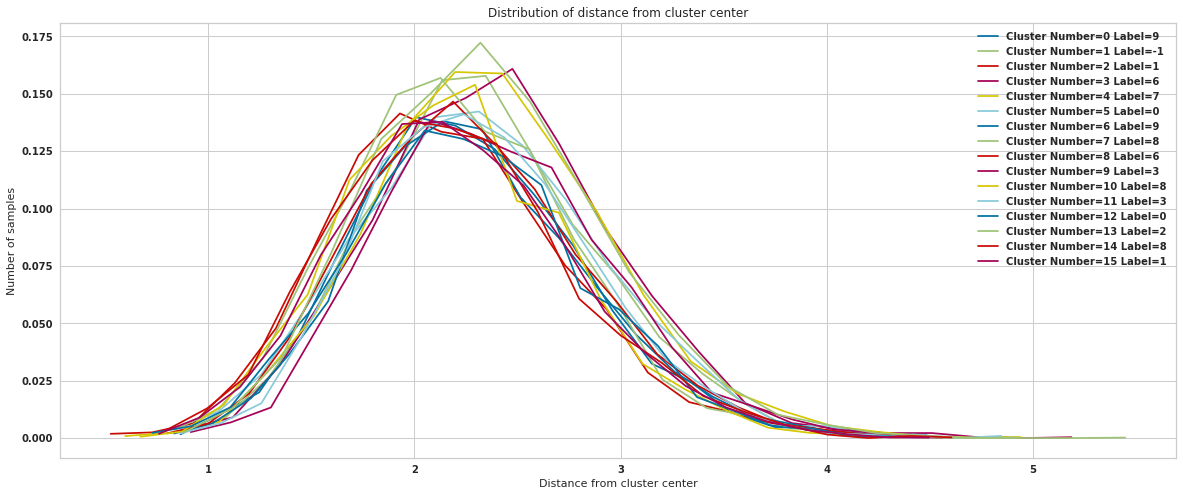

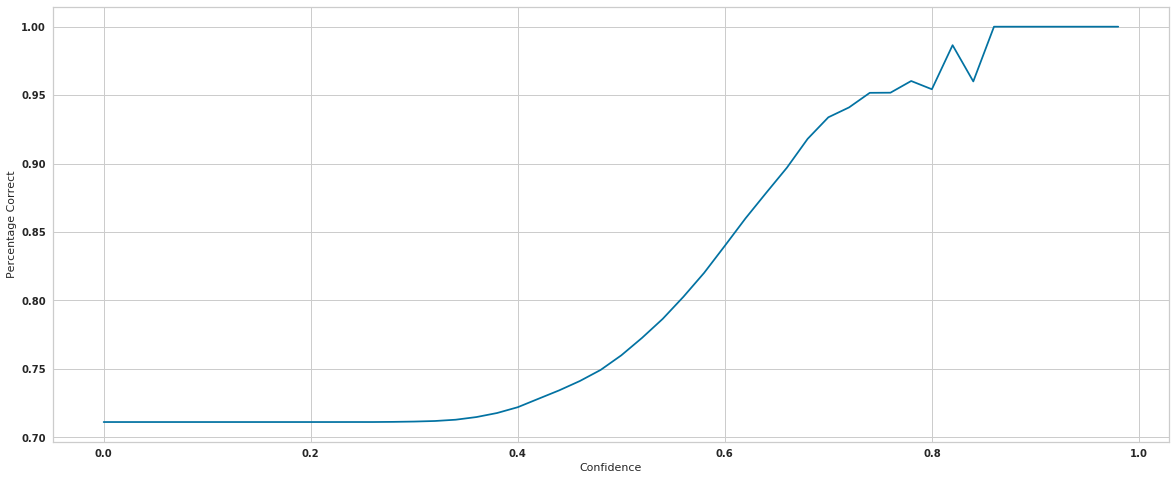

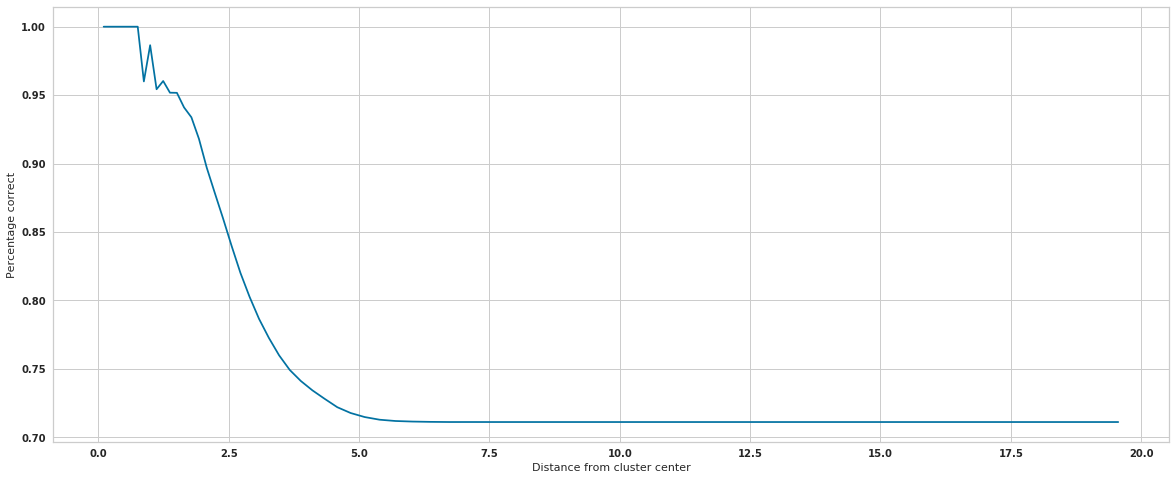

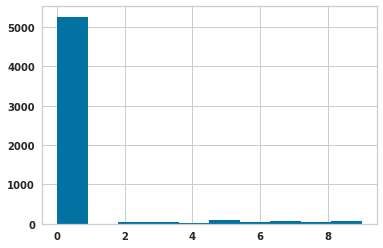

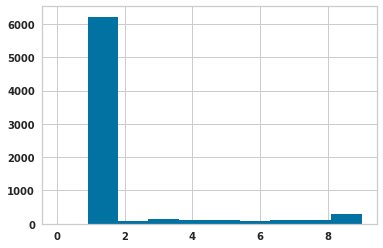

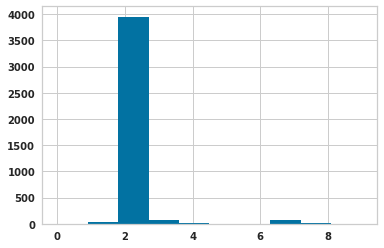

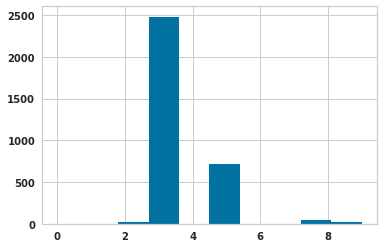

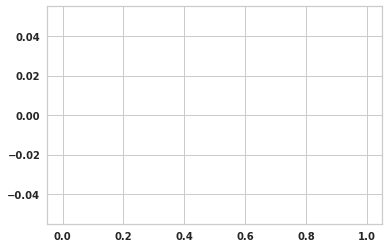

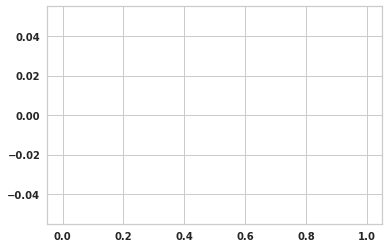

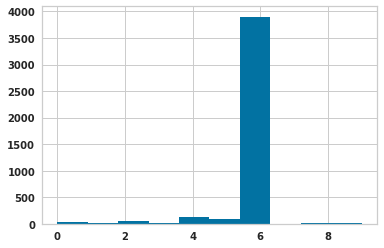

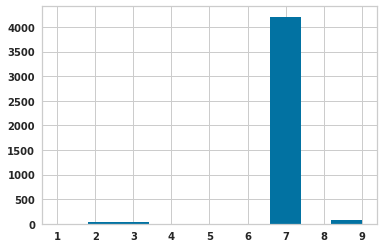

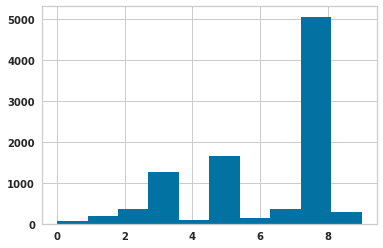

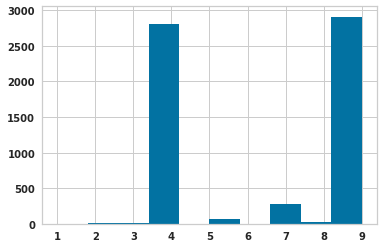

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [127]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 57217
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-7480
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-7480
 [*] Success to read ClassifierModel.model-7480
 [*] Load SUCCESS
Number of steps completed=7480
Number of epochs completed 8.0
run_id=2 z_min=-4.4770355 z_max=4.1615150000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergenc

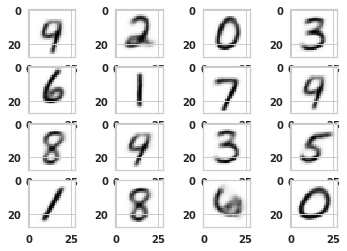

In [128]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


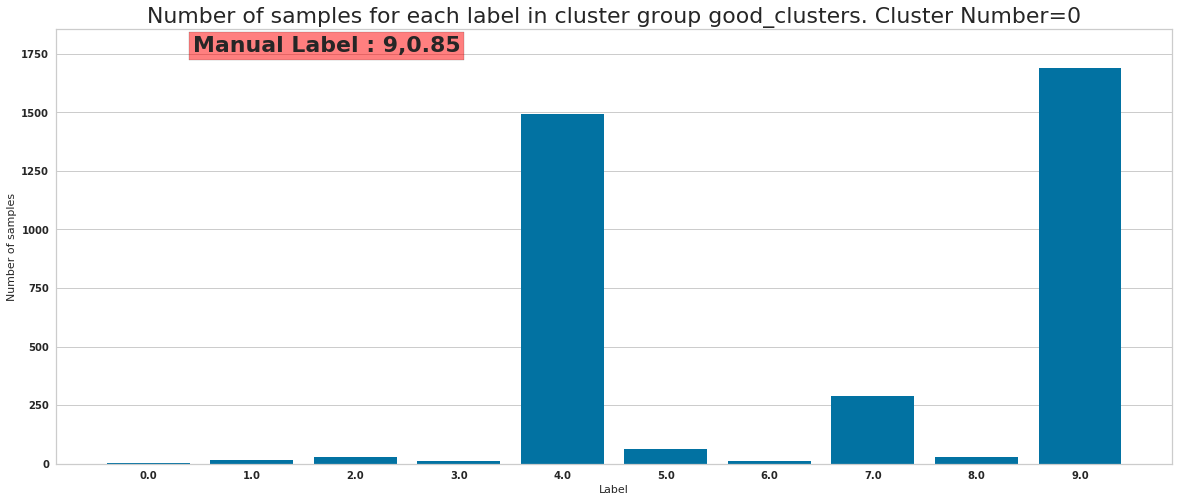

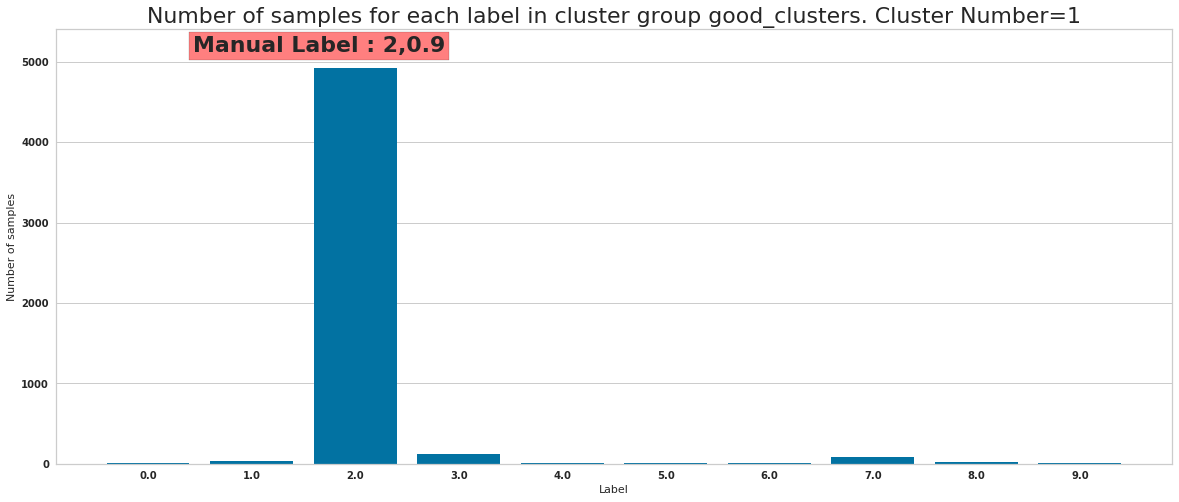

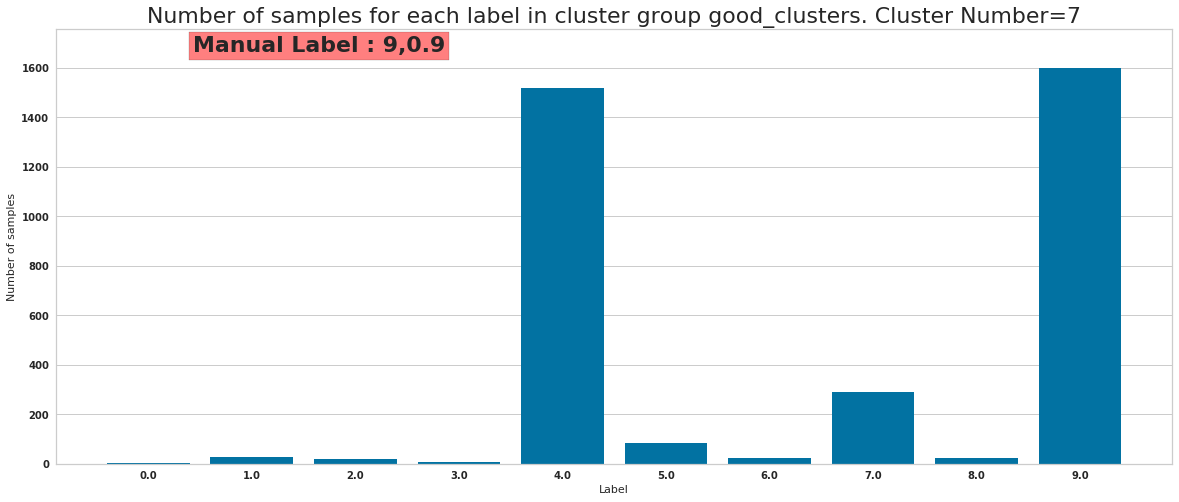

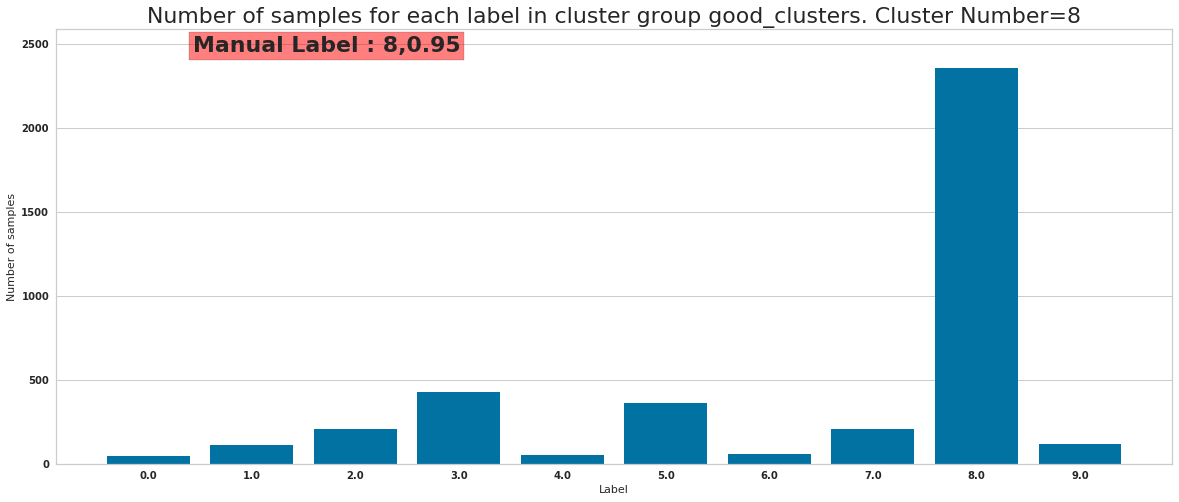

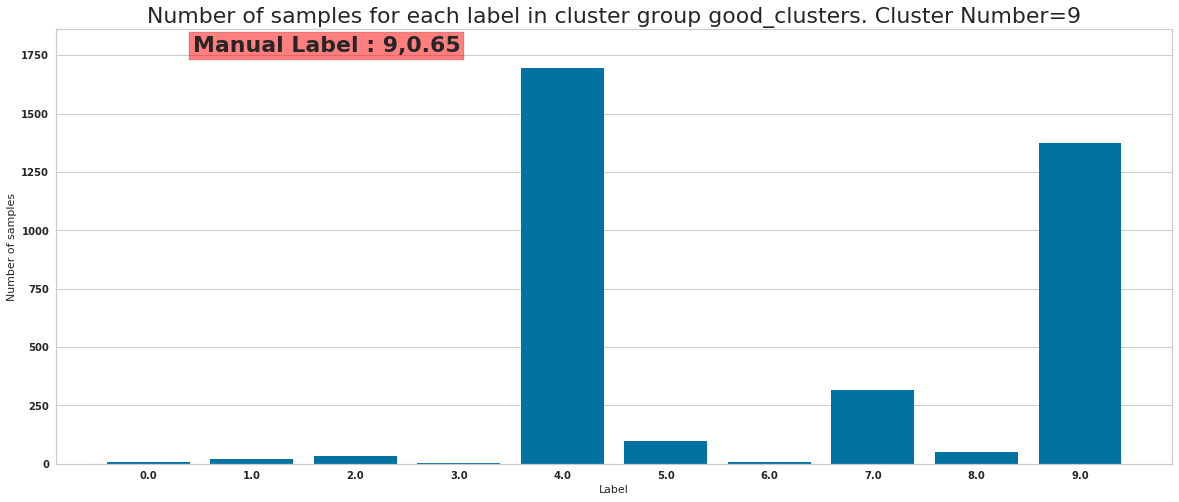

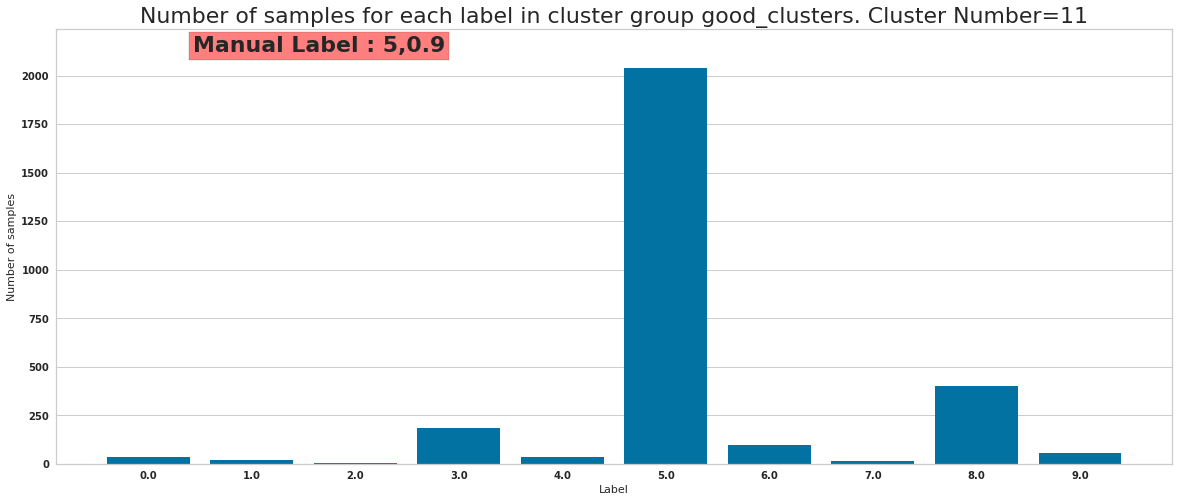

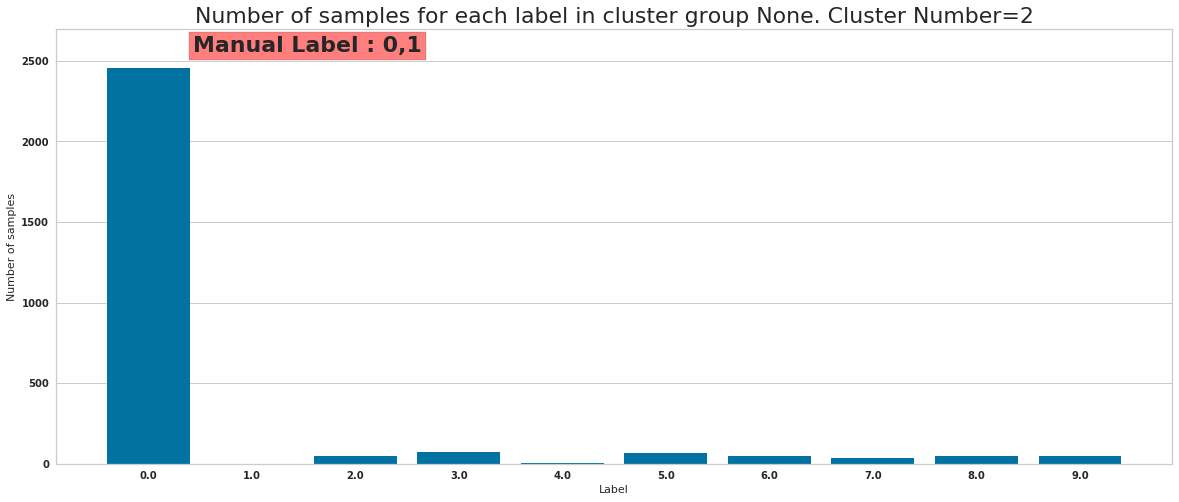

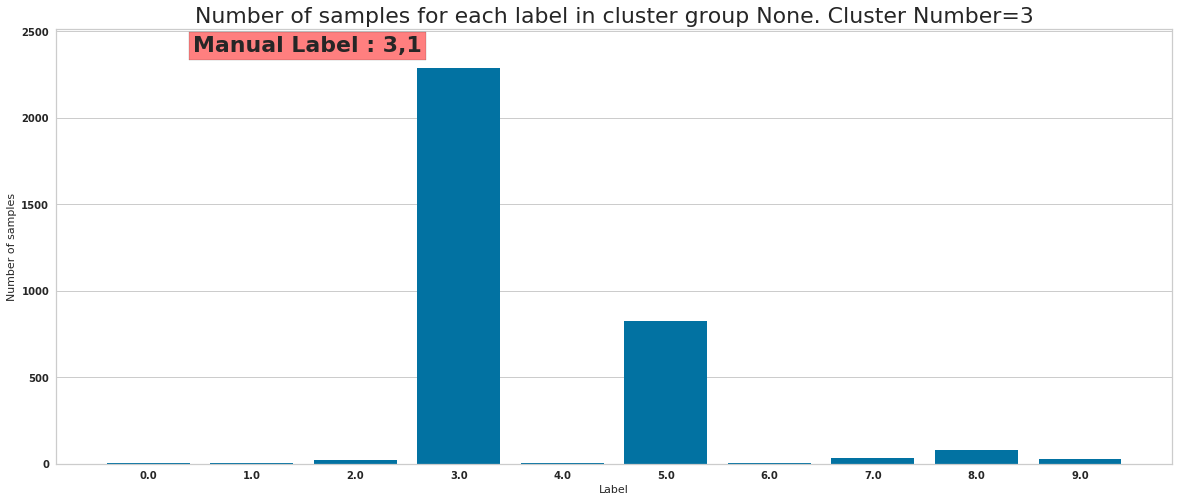

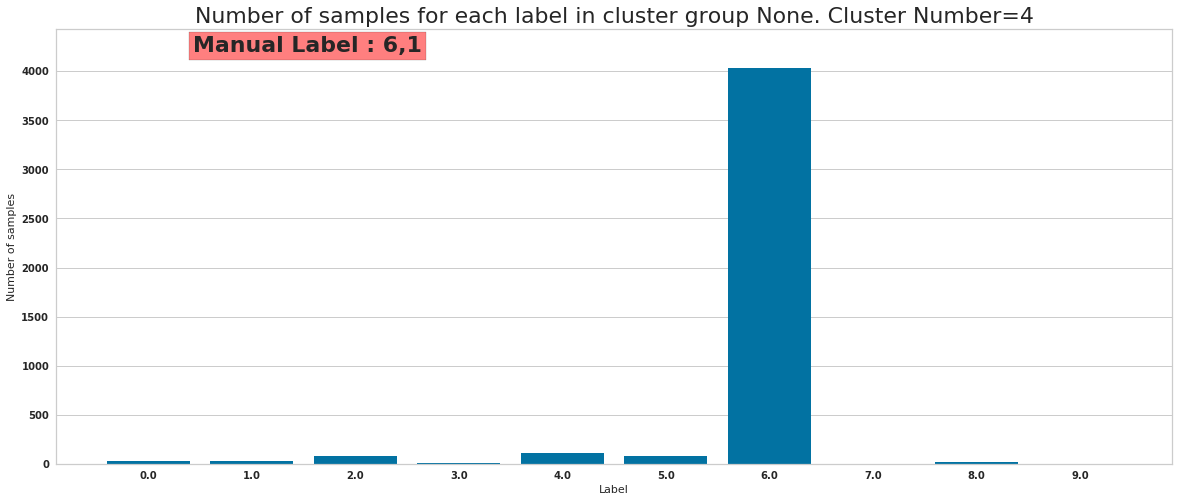

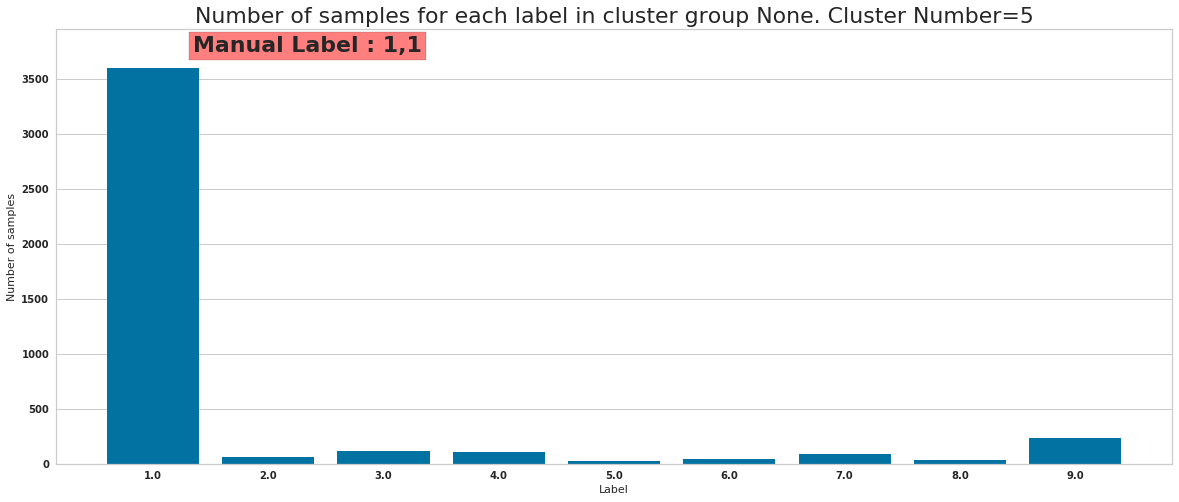

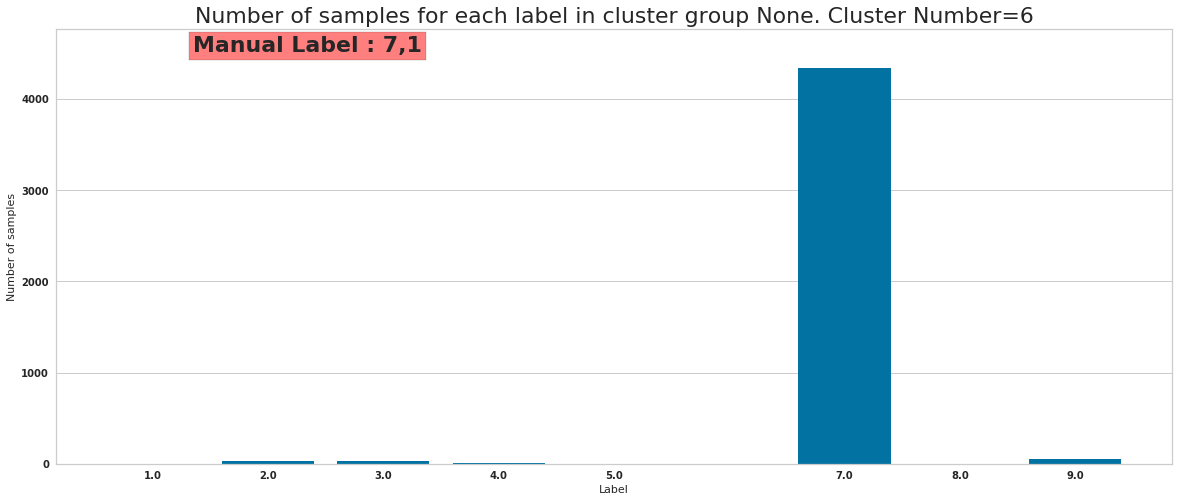

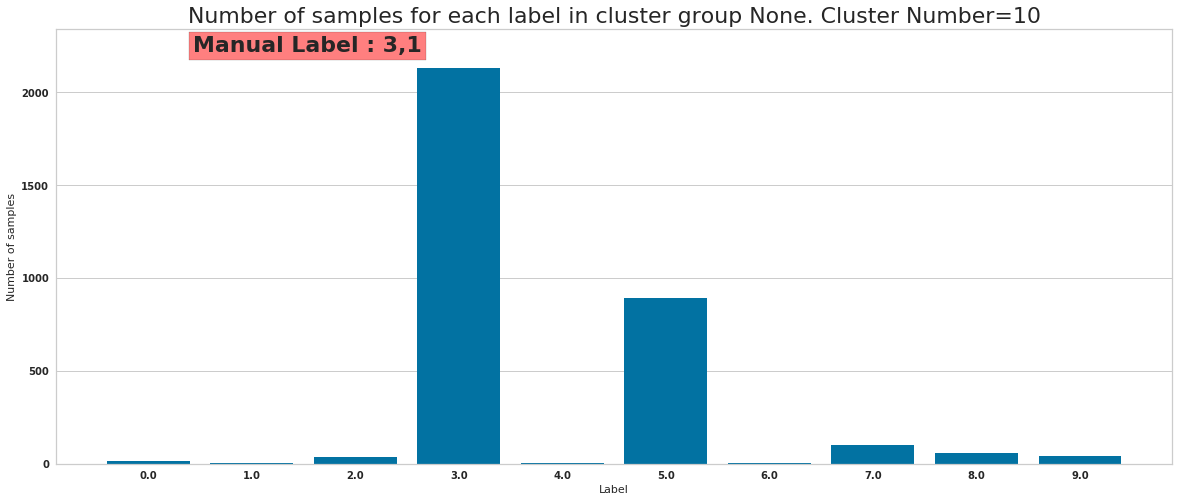

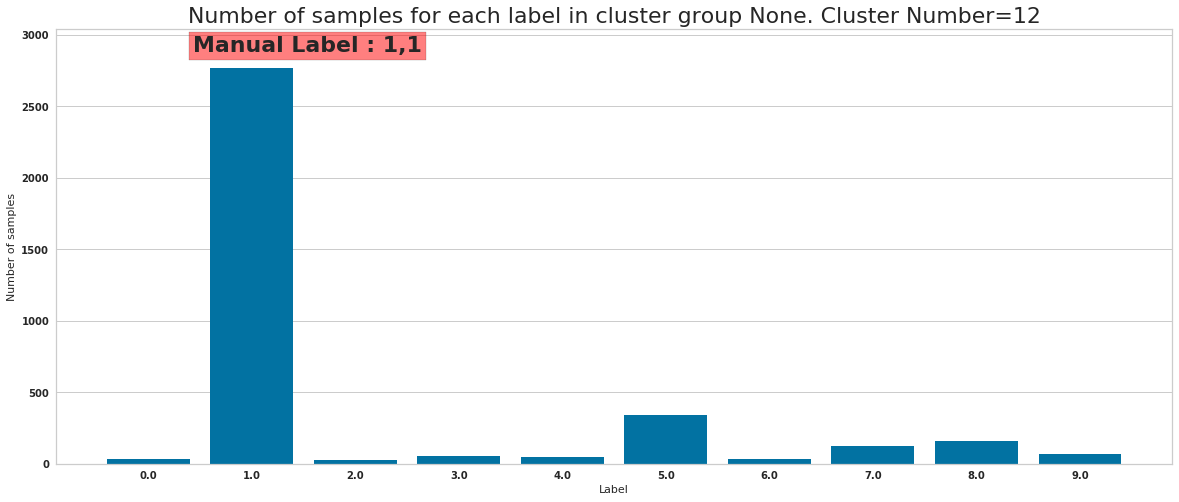

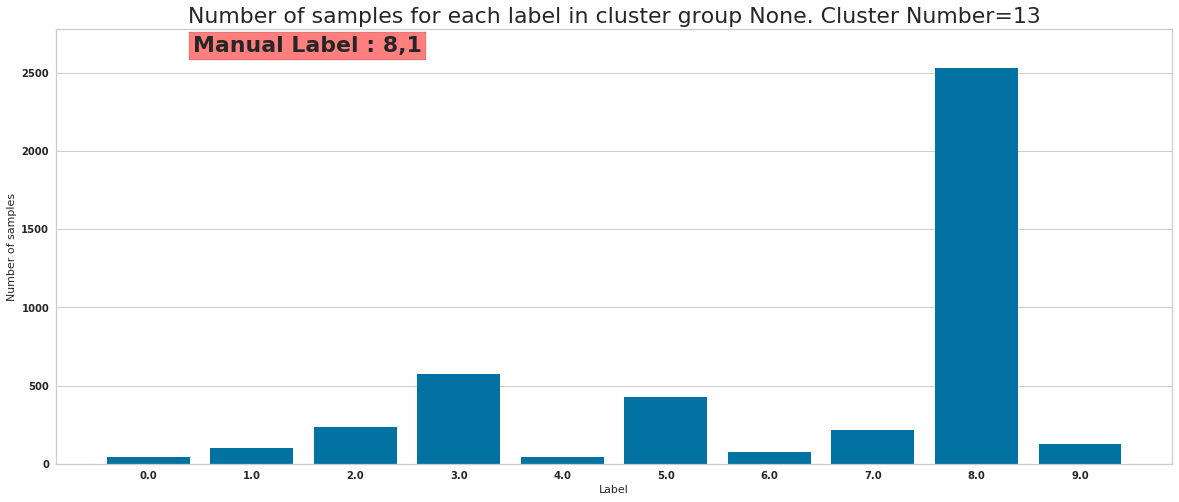

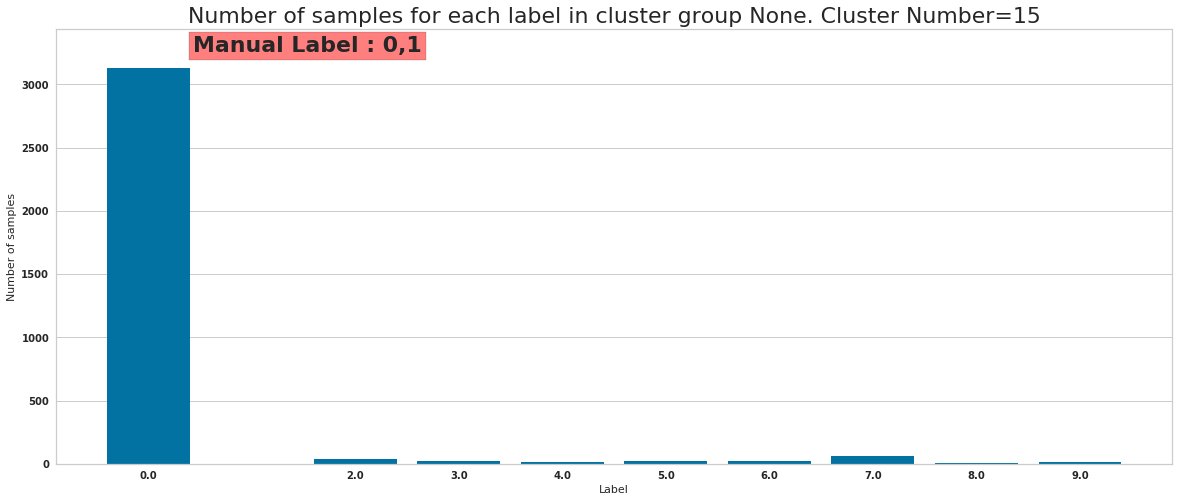

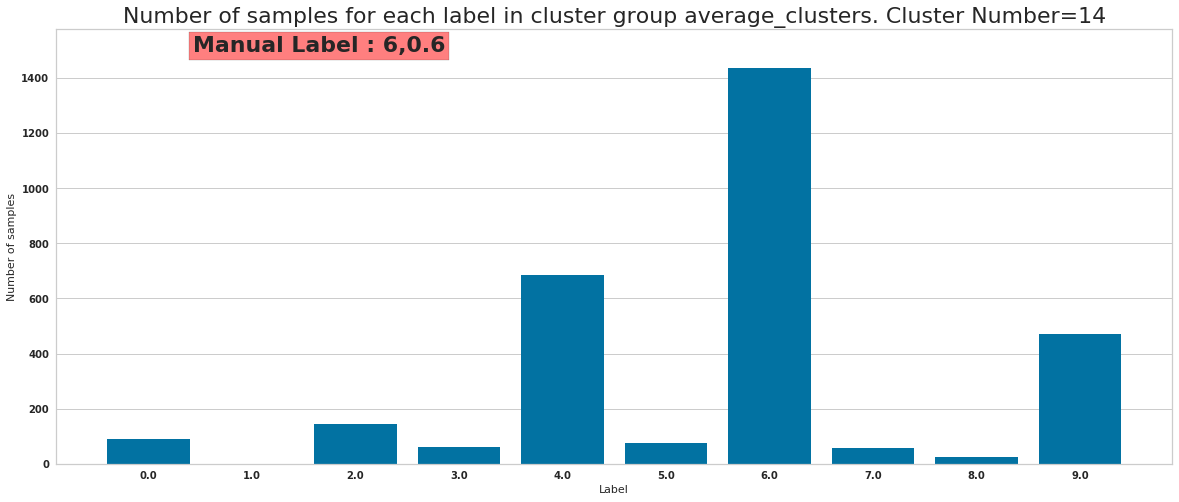

In [129]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,2,0,3,
                                           6,1,7,9,
                                           8,9,3,5,
                                           1,8,6,0
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0.9,1,1,
                                               1,1,1,0.9,
                                               0.95,0.65,1,0.9,
                                               1,1,0.6,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [130]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [132]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


Manual Label 9
(3640, 52) (3640, 32)
Num correct=1687
Cluster 0 Manual Label 9 Percentage correct 46.34615384615385
********************************
Manual Label 2
(5220, 52) (5220, 32)
Num correct=4917
Cluster 1 Manual Label 2 Percentage correct 94.19540229885058
********************************
Manual Label 0
(2829, 52) (2829, 32)
Num correct=2452
Cluster 2 Manual Label 0 Percentage correct 86.67373630258042
********************************
Manual Label 3
(3291, 52) (3291, 32)
Num correct=2285
Cluster 3 Manual Label 3 Percentage correct 69.43178365238529
********************************
Manual Label 6
(4384, 52) (4384, 32)
Num correct=4028
Cluster 4 Manual Label 6 Percentage correct 91.87956204379562
********************************
Manual Label 1
(4299, 52) (4299, 32)
Num correct=3592
Cluster 5 Manual Label 1 Percentage correct 83.55431495696673
********************************
Manual Label 7
(4472, 52) (4472, 32)
Num correct=4336
Cluster 6 Manual Label 7 Percentage correct 96.95885

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

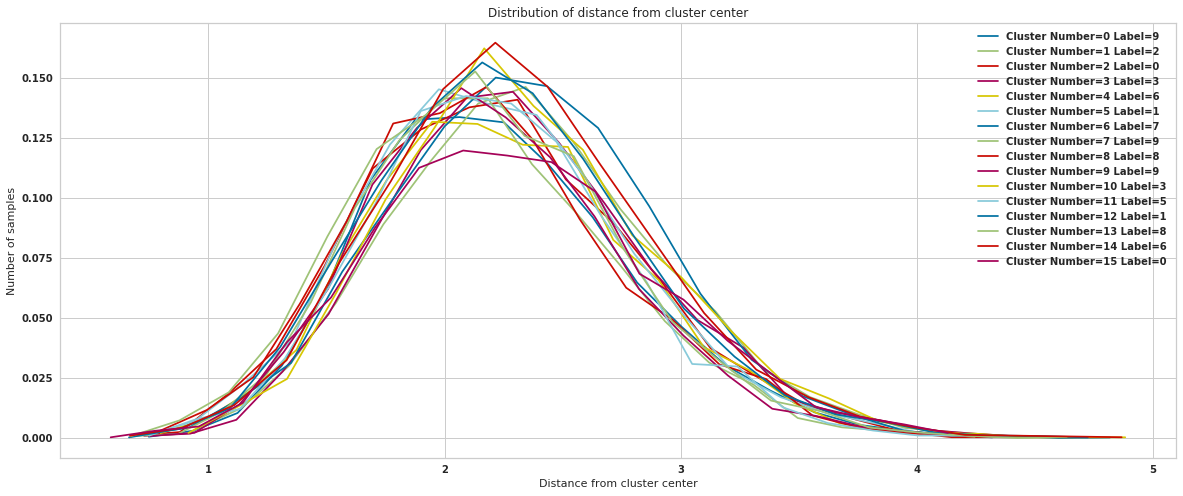

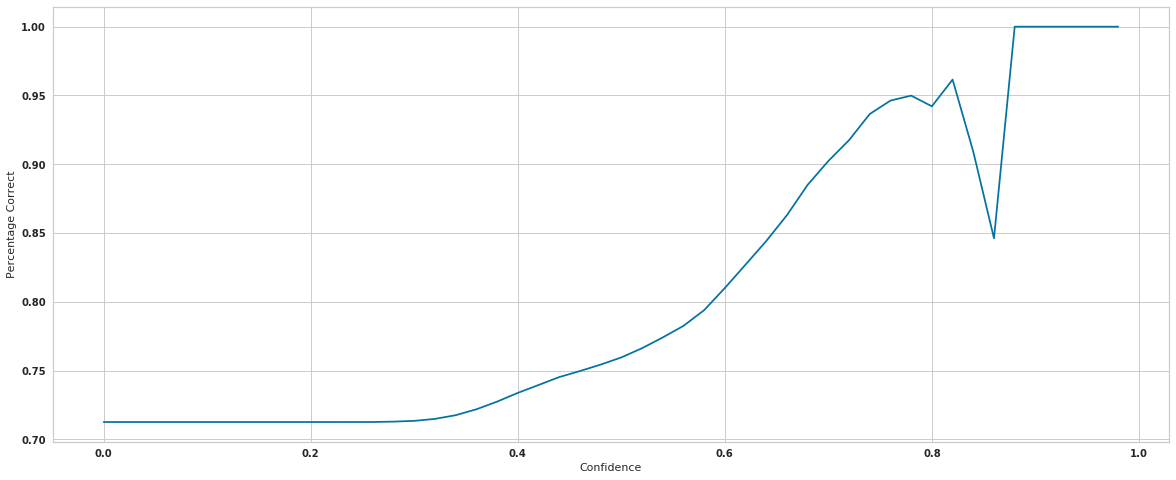

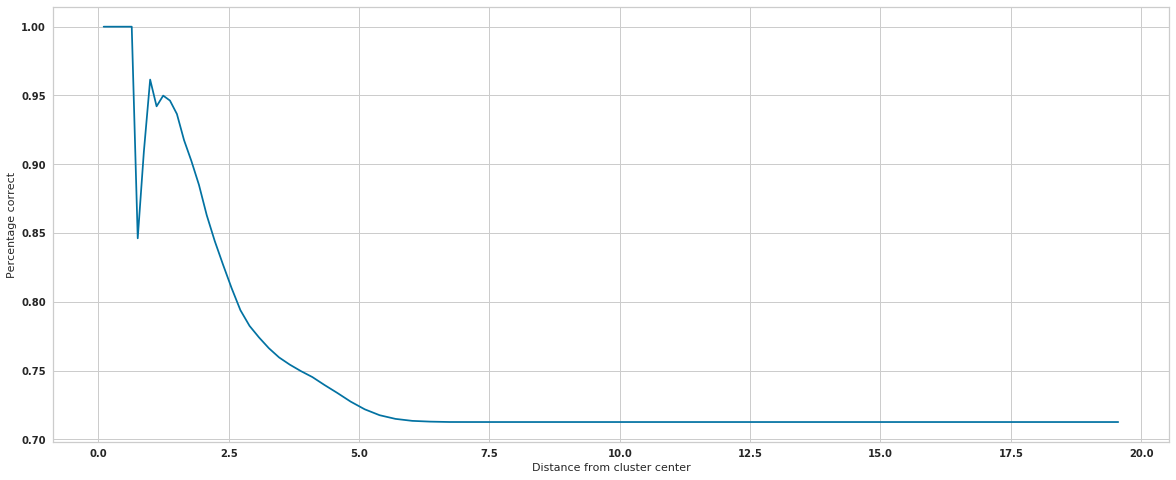

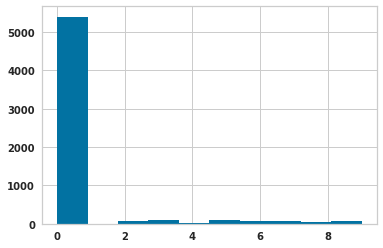

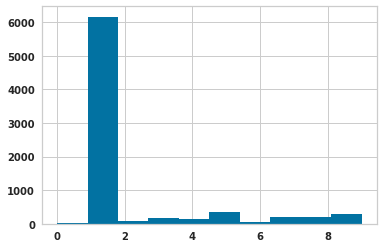

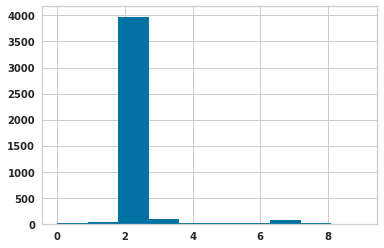

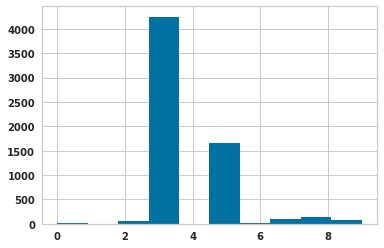

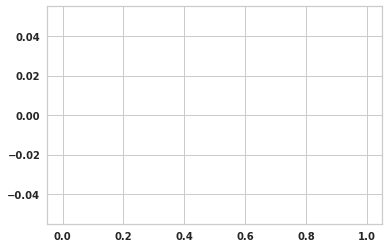

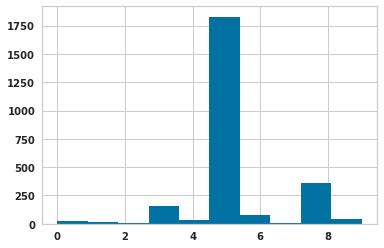

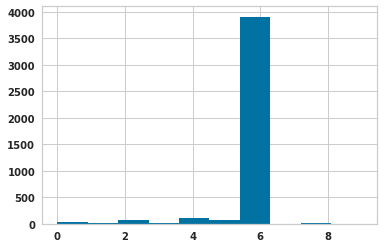

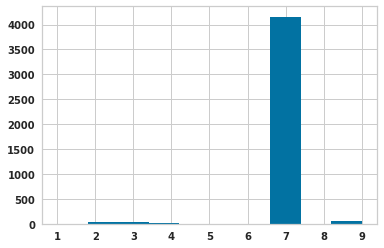

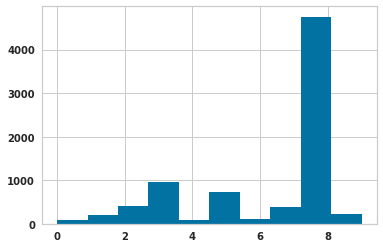

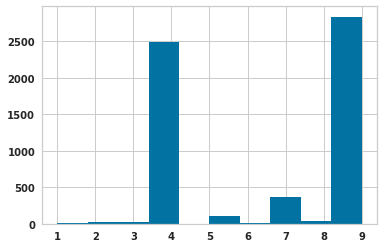

In [133]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [134]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:08 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS
Number of steps completed=8415
Number of epochs completed 9.0
run_id=2 z_min=-4.340634 z_max=4.580414
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.


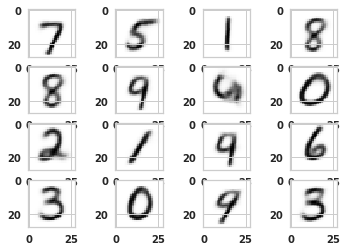

In [135]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


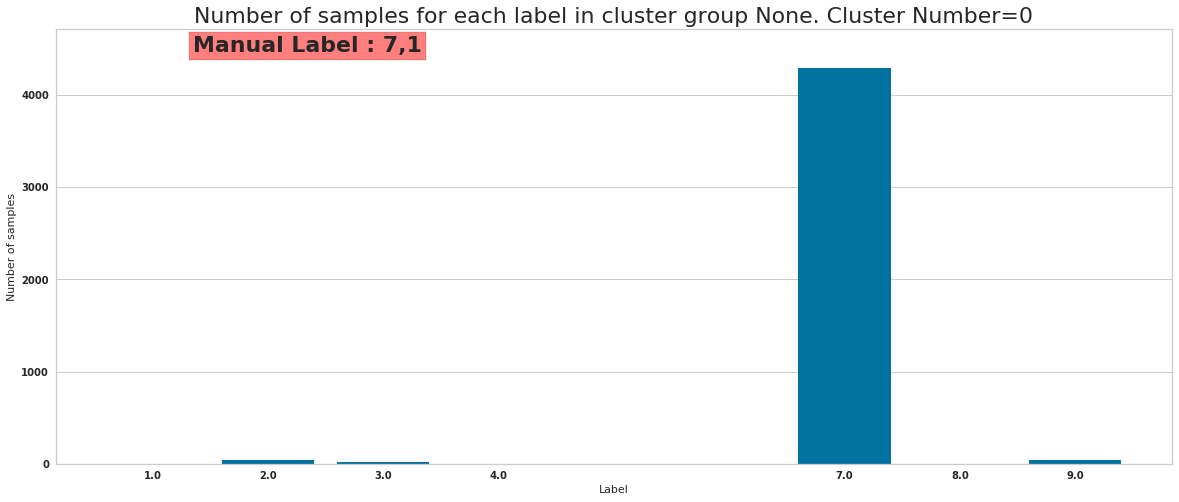

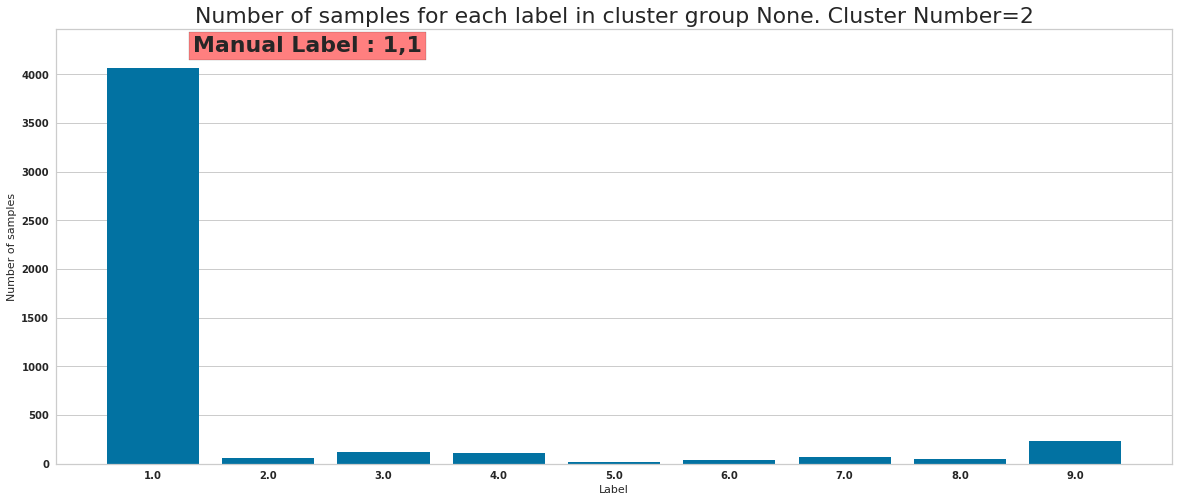

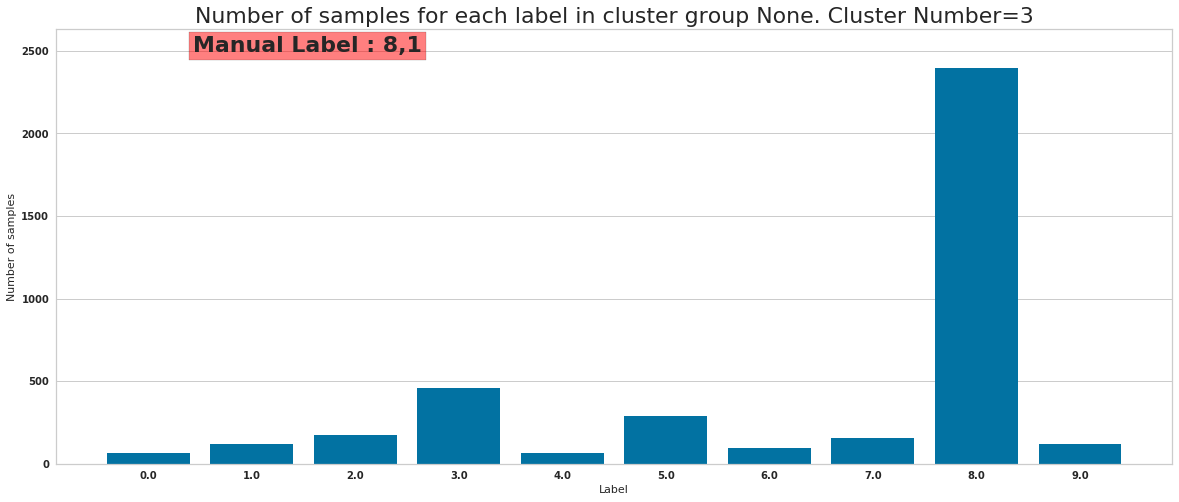

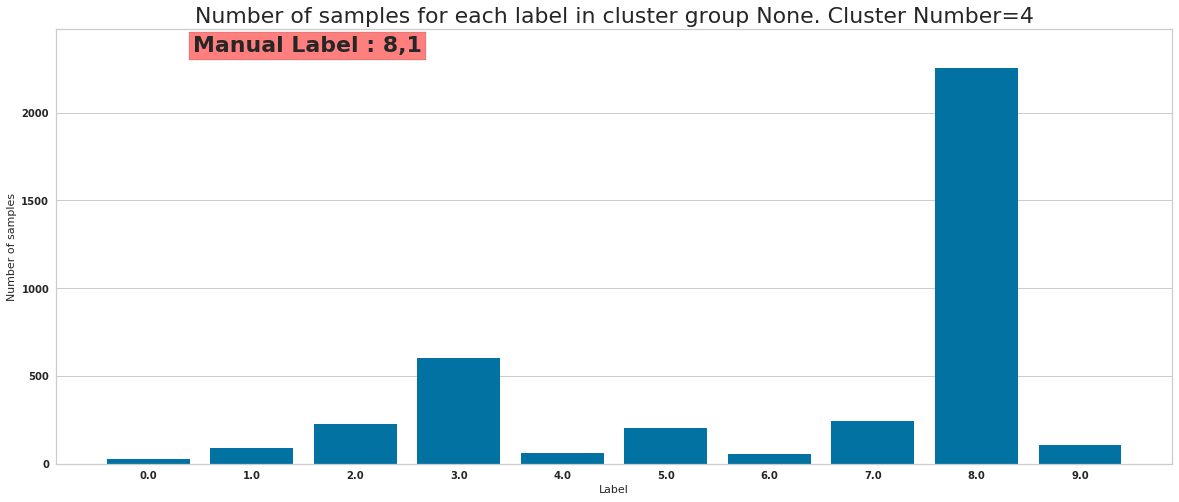

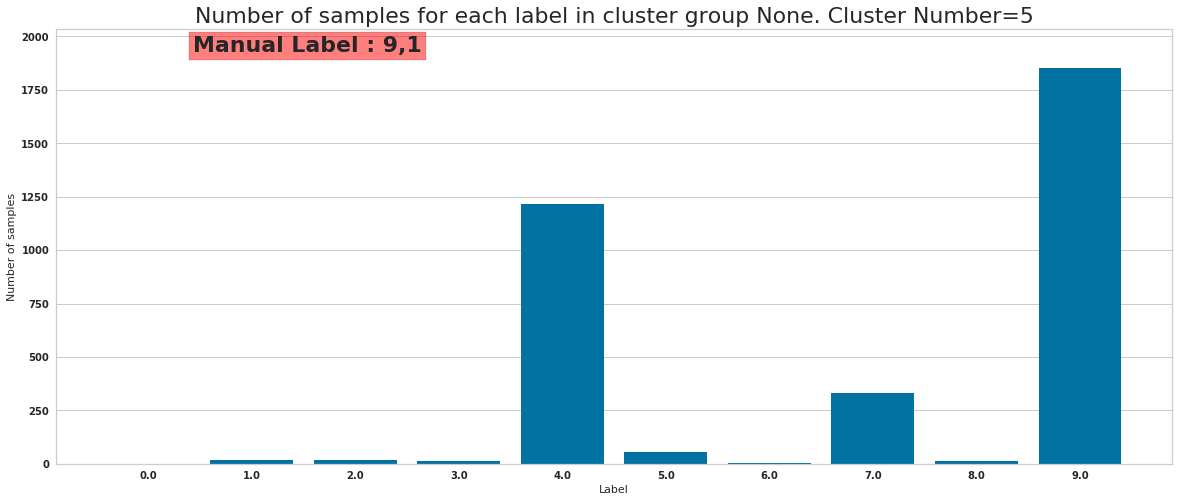

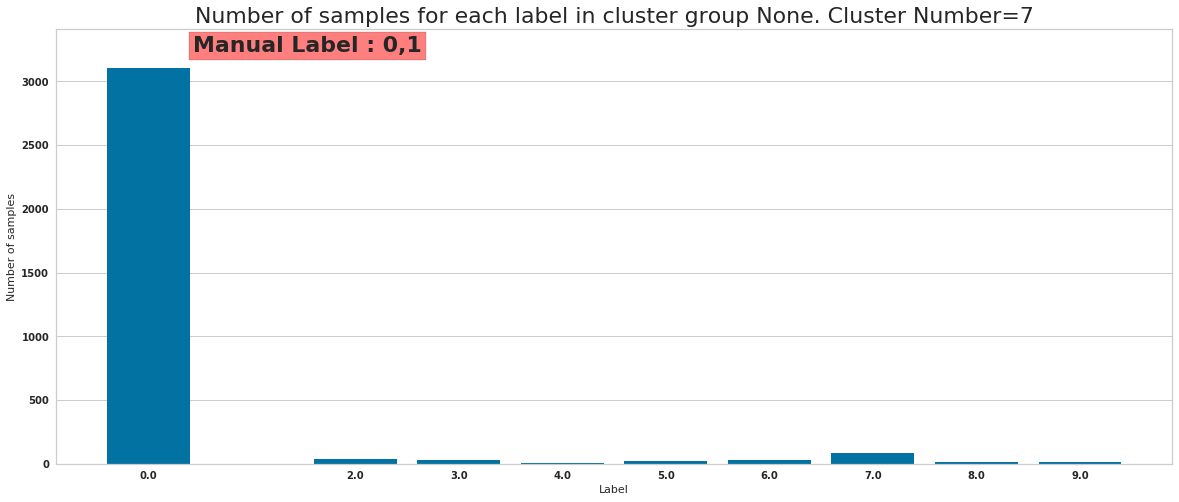

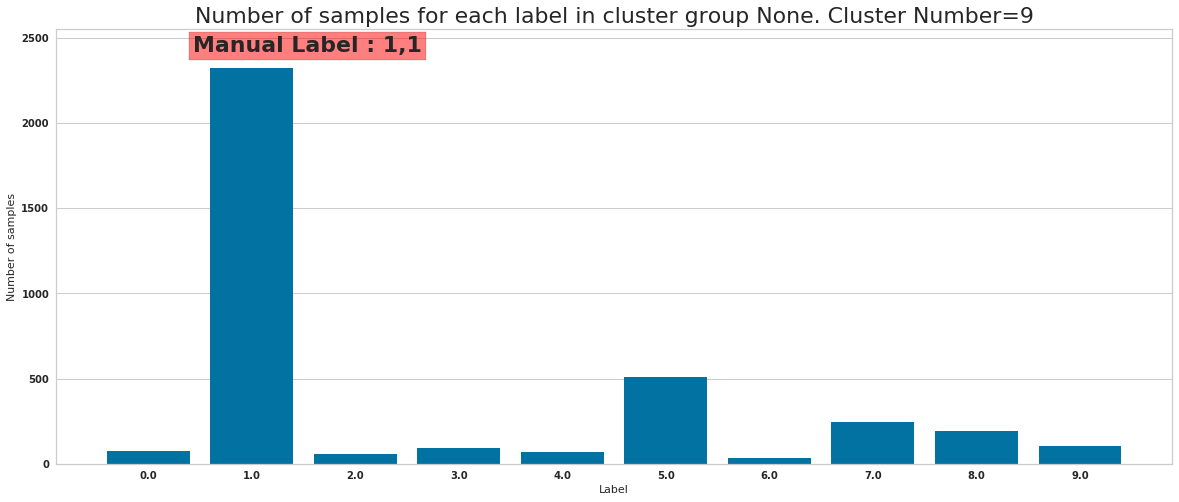

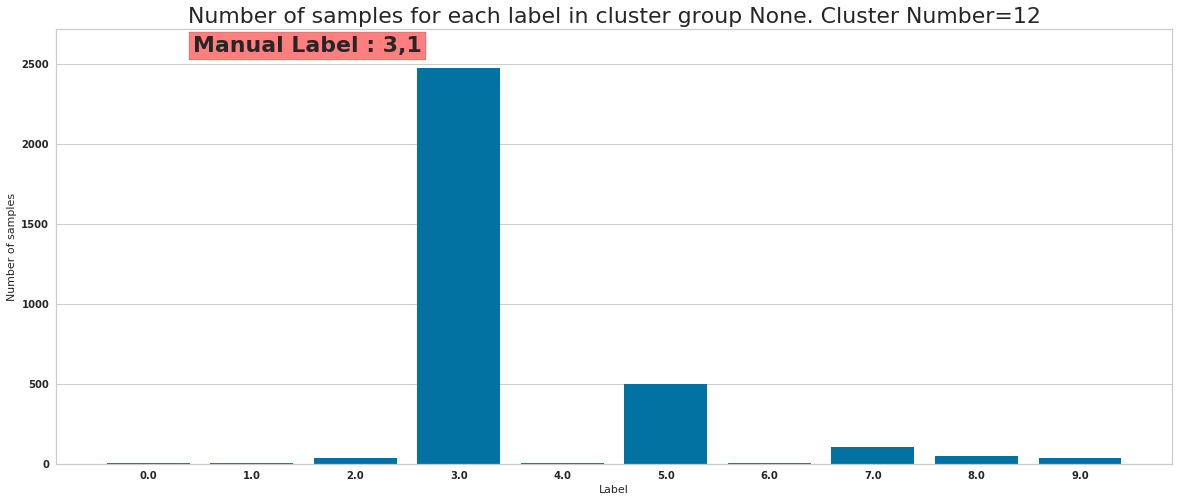

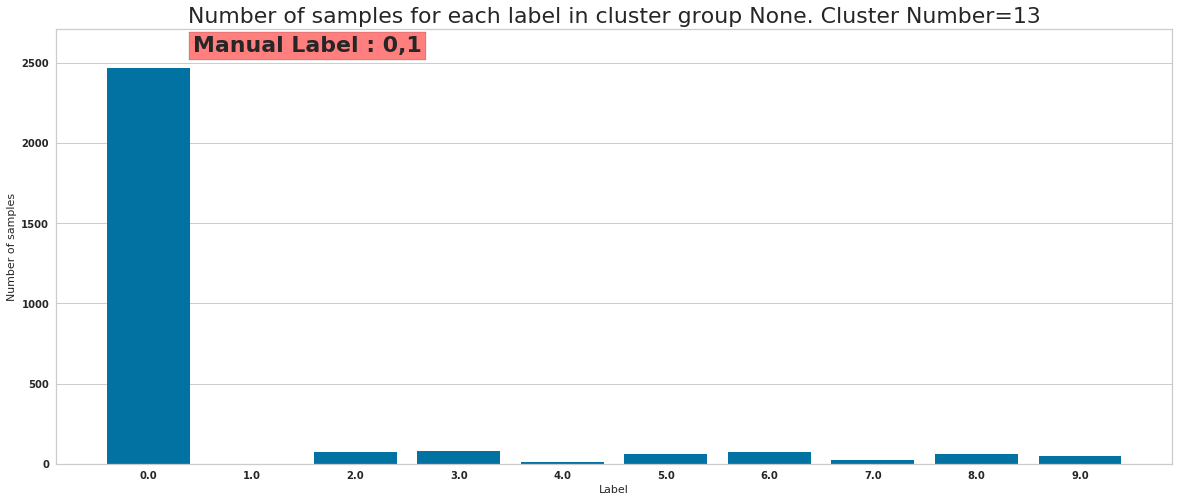

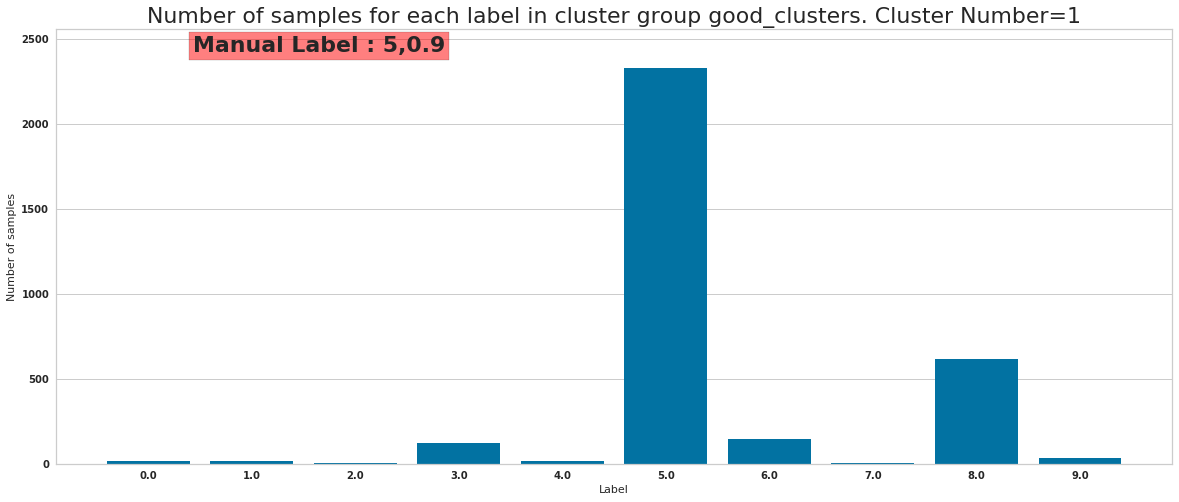

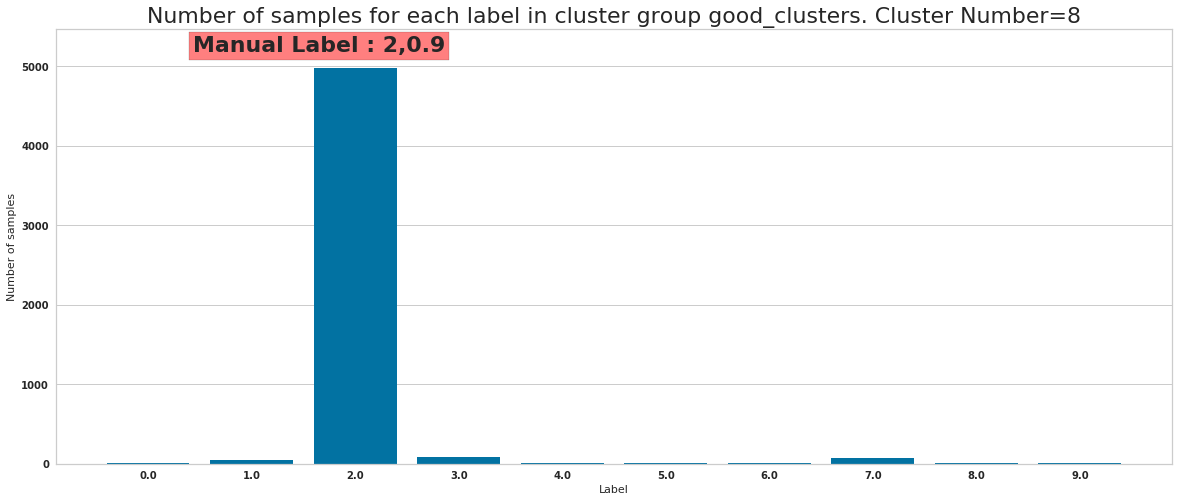

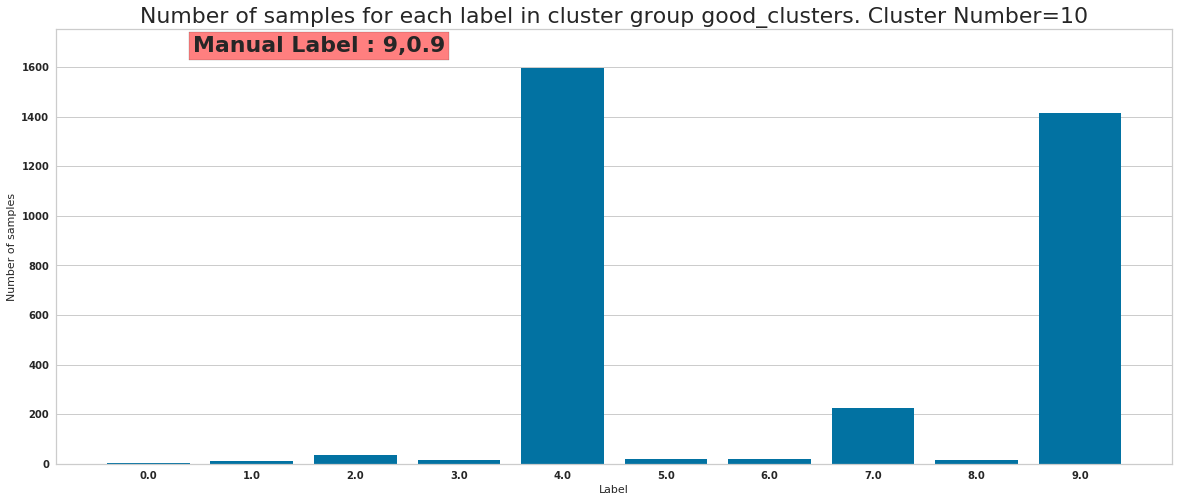

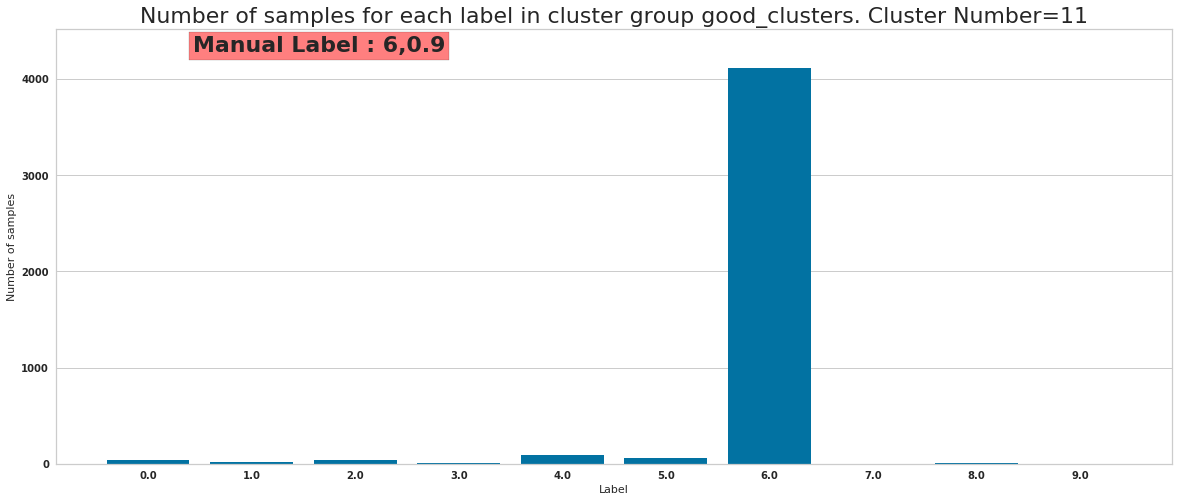

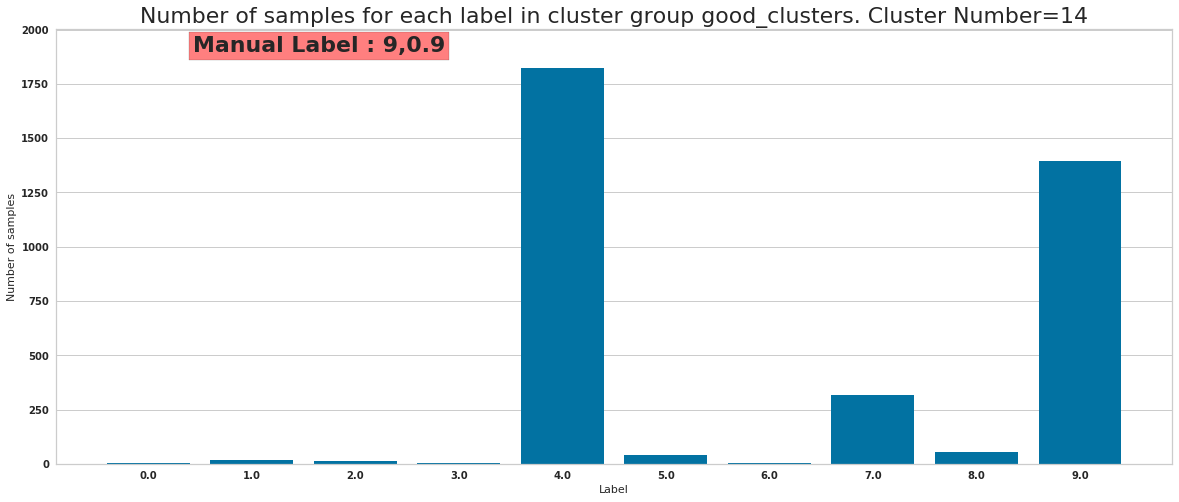

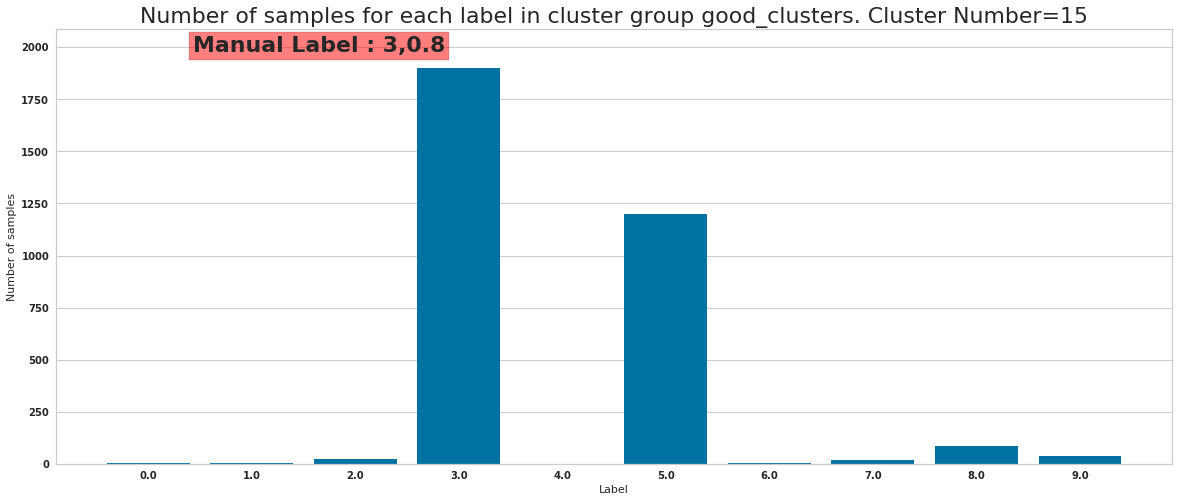

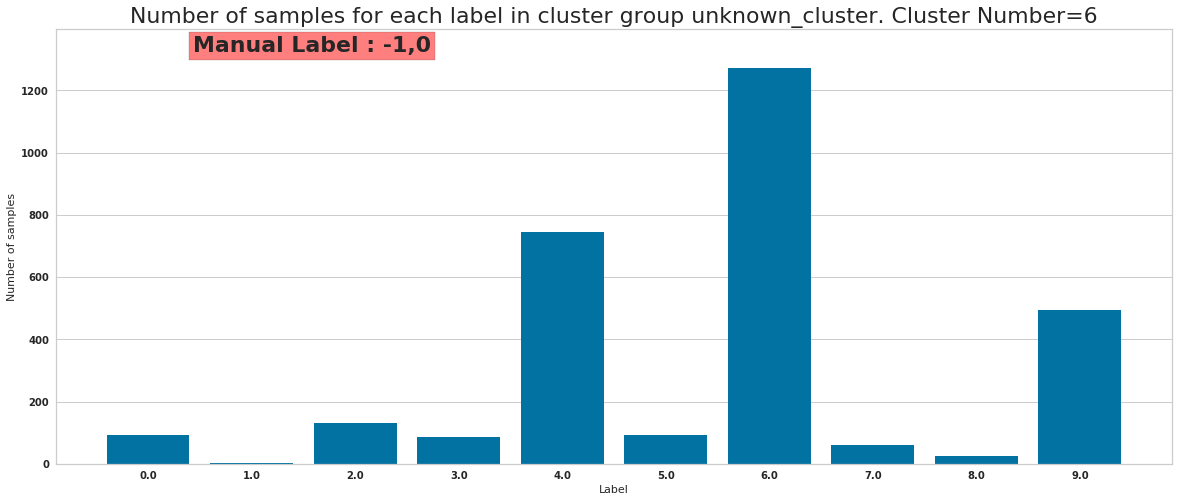

In [136]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,5,1,8,
                                           8,9,-1,0,
                                           2,1,9,6,
                                           3,0,9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,1,
                                               1,1,0,1,
                                               0.9,1,0.9,0.9,
                                               1,1,0.9,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


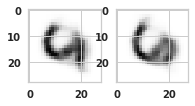

In [137]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [138]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [139]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


6
2
Skipping distance computation for unknown cluster
Manual Label 7
(4396, 54) (4396, 32)
Num correct=4285
Cluster 0 Manual Label 7 Percentage correct 97.47497725204731
********************************
Manual Label 5
(3305, 54) (3305, 32)
Num correct=2327
Cluster 1 Manual Label 5 Percentage correct 70.40847201210288
********************************
Manual Label 1
(4762, 54) (4762, 32)
Num correct=4061
Cluster 2 Manual Label 1 Percentage correct 85.27929441411172
********************************
Manual Label 8
(3938, 54) (3938, 32)
Num correct=2393
Cluster 3 Manual Label 8 Percentage correct 60.76688674454038
********************************
Manual Label 8
(7812, 54) (3874, 32)
Num correct=4645
Cluster 4 Manual Label 8 Percentage correct 59.459805427547366
********************************
Manual Label 9
(3523, 54) (3523, 32)
Num correct=1850
Cluster 5 Manual Label 9 Percentage correct 52.512063582174285
********************************
unknown
<class 'dict'>
['unknown_cluster']
*******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

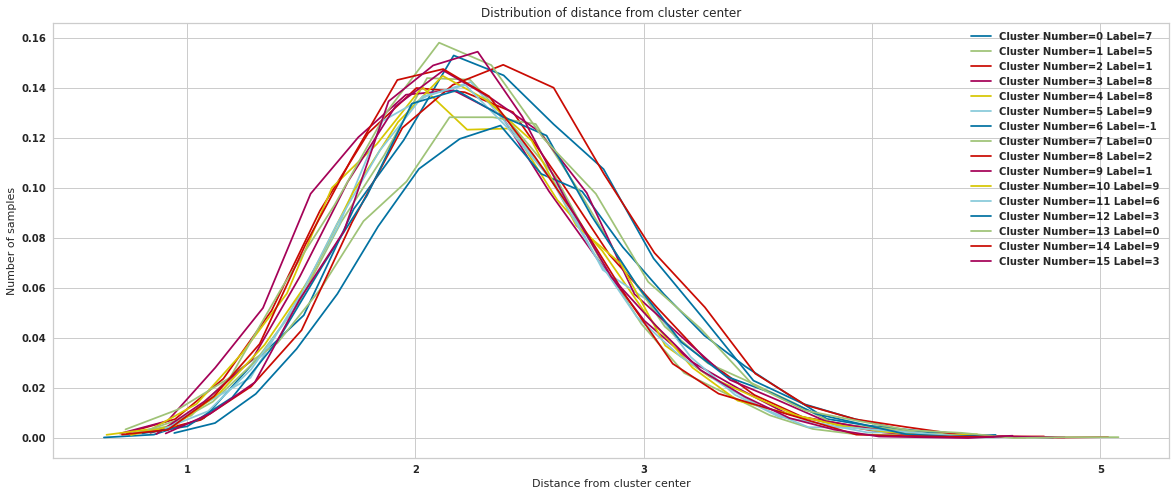

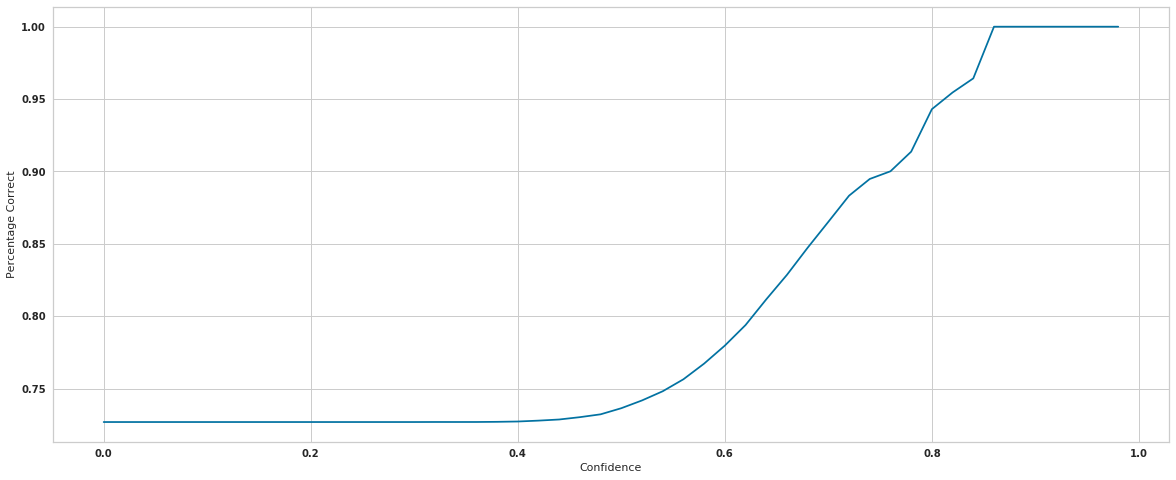

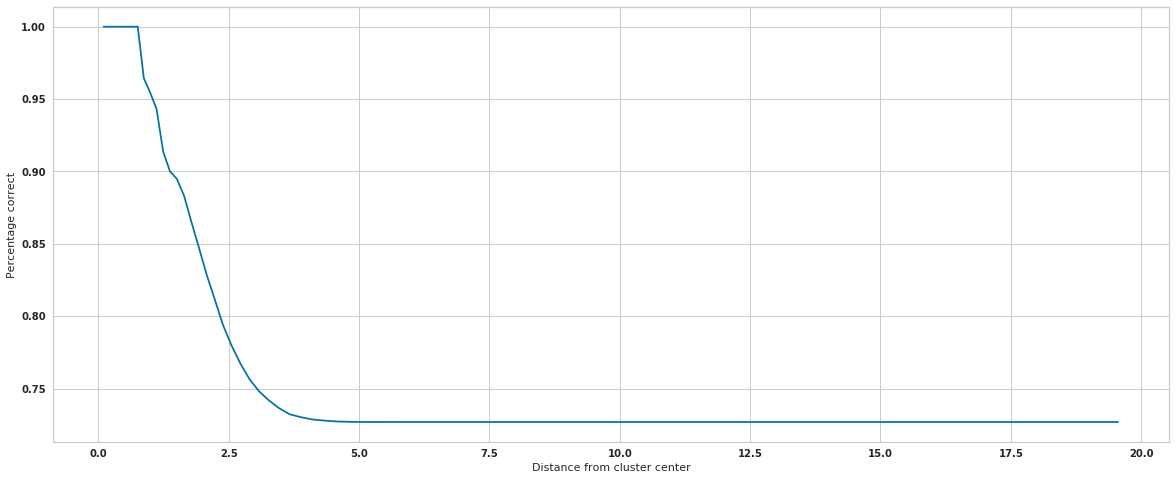

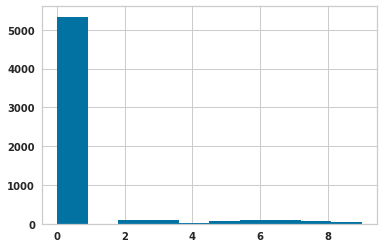

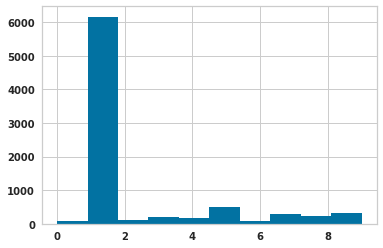

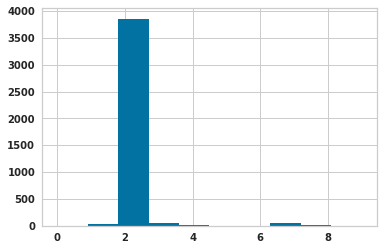

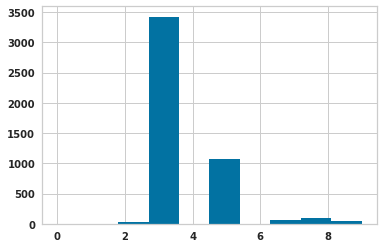

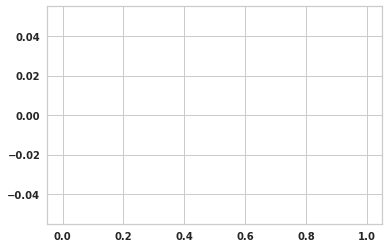

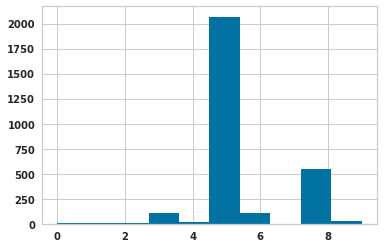

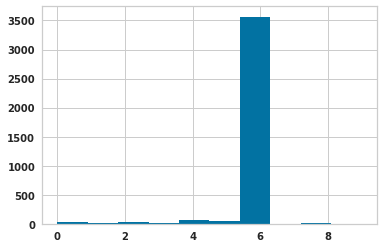

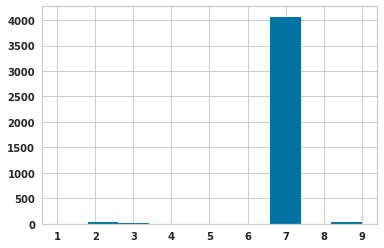

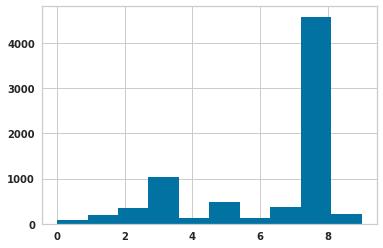

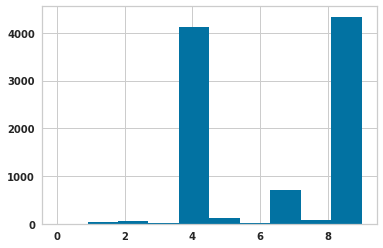

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [142]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56841
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9